In [8]:
# !python3 -m pip install seaborn
# ! pip install pymc3
# ! pip install arviz
! pip install --upgrade pandas

zsh:1: /usr/local/bin/pip: bad interpreter: /System/Library/Frameworks/Python.framework/Versions/2.7/Resources/Python.app/Contents/MacOS/Python: no such file or directory
  Using cached pandas-1.5.2-cp39-cp39-macosx_10_9_x86_64.whl (12.1 MB)
  Attempting uninstall: pandas
    Found existing installation: pandas 1.4.2
    Uninstalling pandas-1.4.2:
      Successfully uninstalled pandas-1.4.2


In [1]:
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import MaxNLocator
import numpy as np
from tqdm import tqdm
import scipy.stats as stats
from scipy.signal import find_peaks, peak_widths
import itertools
import pandas as pd
# import pymc3 as pm
# import arviz as az
from datetime import datetime as dt
# import igraph as ig
# from statsmodels.stats.weightstats import ztest
# from rdkit import Chem
# from rdkit.Chem import Descriptors
import os
from datetime import datetime

In [2]:
## Matplotlib defaults ##
colors = {"5": "#aa0f35", 
         "6": "#fdc799",
         "7": "#a0a75c",
         "8": "#603734",
         "9": "#abdbfc",
         "10": "#313a61",
         "15": "#bfbad5",
         "20": "#f89b00",
         "full": "#313862",
         "new": "#FAB124"}

font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 22}

plt.style.use("default")
plt.rcParams.update({'font.size': 22})
# plt.style.use("dark_background")

# Overview

Analyze assembly index calculations across patent data. These calculations are from random samples of compounds present in each month from 1980-2019.

//TODO: sample from new compounds added in each month

In [3]:
fp = "Data/AssemblyValues/assembly_values_1000_1980.p"
assembly_values = pickle.load(file=open(fp, "rb"))

In [4]:
print(assembly_values[100:199])

[{'month': '1980-01', 'inchi': 'InChI=1S/C17H35Cl.H3N/c1-5-6-7-8-9-10-11-12-13-14-15-16(2)17(3,4)18;/h16H,5-15H2,1-4H3;1H3', 'ai': 16}, {'month': '1980-01', 'inchi': 'InChI=1S/C27H33P/c1-16-10-25(11-17(2)22(16)7)28(26-12-18(3)23(8)19(4)13-26)27-14-20(5)24(9)21(6)15-27/h10-15H,1-9H3', 'ai': 14}, {'month': '1980-01', 'inchi': 'InChI=1S/C27H33P/c1-7-22-10-19(4)13-25(16-22)28(26-14-20(5)11-23(8-2)17-26)27-15-21(6)12-24(9-3)18-27/h10-18H,7-9H2,1-6H3', 'ai': 16}, {'month': '1980-01', 'inchi': 'InChI=1S/C30H39P/c1-28(2,3)22-13-10-16-25(19-22)31(26-17-11-14-23(20-26)29(4,5)6)27-18-12-15-24(21-27)30(7,8)9/h10-21H,1-9H3', 'ai': 20}, {'month': '1980-01', 'inchi': 'InChI=1S/C18H31N/c1-2-3-4-5-15-6-10-17(11-7-15)18-12-8-16(14-19)9-13-18/h15-18H,2-13H2,1H3', 'ai': 9}, {'month': '1980-01', 'inchi': 'InChI=1S/C16H17NO2/c18-16(19)14-10-4-5-11-15(14)17-12-6-9-13-7-2-1-3-8-13/h1-5,7-8,10-11,17H,6,9,12H2,(H,18,19)', 'ai': 14}, {'month': '1980-01', 'inchi': 'InChI=1S/C20H32O2/c1-12-10-14(21)11-13-4-5-15-16

In [5]:
def build_month_increments(start, stop):
    """ Build all monthly increments from the start year to stop year in the
    format YEAR-MONTH

    Args:
        start (int): start year of increments
        stop (int): end year of increments

    Returns:
        list: list of strings holding the YEAR-MONTH increments
    """
    months = []
    while start <= stop:
        for month in [
                "01", "02", "03", "04", "05", "06", "07", "08", "09", "10",
                "11", "12"
        ]:
            months.append(str(start) + "-" + month)
        start += 1

    return months

In [6]:
months = build_month_increments(1980, 1980)
print(months)

['1980-01', '1980-02', '1980-03', '1980-04', '1980-05', '1980-06', '1980-07', '1980-08', '1980-09', '1980-10', '1980-11', '1980-12']


# New / Total Compound Assemblies (AssemblyGo)

Read in AssemblyGo results, split data into months, graph from there


In [3]:
#Read in full and new dataframes
fp = "Data/AssemblyValues/"
full_df = pd.read_csv(fp + "FullDatabase_AssemblyGo.csv")
new_df = pd.read_csv(fp + "NewDatabase_AssemblyGo.csv")

In [5]:
print(full_df.head())

   Unnamed: 0           label  MA_assemblyGo
0           0  1994-03_365031             13
1           1  1994-09_370717             11
2           2   2017-11_80436             22
3           3  2010-04_214306              9
4           4  2005-11_267327             12


In [6]:
def get_month(label):
    """ Isolates the month from the given label

    Args:
        label (str): compound id in the form YYYY-MM_label

    Returns:
        str: YYYY-MM of a particular compound
    """
    return str(label)[:7]

In [7]:
#Apply to full and new dataframes
tqdm.pandas()

full_df["month"] = full_df["label"].apply(get_month)
new_df["month"] = new_df["label"].apply(get_month)

full_df = full_df.dropna()
new_df = new_df.dropna()

print(full_df)


        Unnamed: 0           label  MA_assemblyGo    month
0                0  1994-03_365031             13  1994-03
1                1  1994-09_370717             11  1994-09
2                2   2017-11_80436             22  2017-11
3                3  2010-04_214306              9  2010-04
4                4  2005-11_267327             12  2005-11
...            ...             ...            ...      ...
467872      467872  2018-01_433720             21  2018-01
467873      467873  2016-12_420694             30  2016-12
467874      467874  1997-05_238251              7  1997-05
467875      467875  1993-03_283329             24  1993-03
467876      467876  1982-10_184989             16  1982-10

[466872 rows x 4 columns]


In [8]:
## Change label to match SureChemBL labels (for addition to full dataframe)

## TODO: THIS ISN'T HOW I DID THIS

def change_label(label):
    return "SCHEMBL" + label[8:]

In [9]:
## NOTE: merged this version of full/new_df with MA_df below (goal is to have one figure with MA change over time)

tqdm.pandas()

full_df["label"] = full_df["label"].progress_apply(change_label)
new_df["label"] = new_df["label"].progress_apply(change_label)

print(full_df)

100%|██████████| 467216/467216 [00:01<00:00, 446715.44it/s]

        Unnamed: 0          label  MA_assemblyGo    month
0                0  SCHEMBL365031             13  1994-03
1                1  SCHEMBL370717             11  1994-09
2                2   SCHEMBL80436             22  2017-11
3                3  SCHEMBL214306              9  2010-04
4                4  SCHEMBL267327             12  2005-11
...            ...            ...            ...      ...
467872      467872  SCHEMBL433720             21  2018-01
467873      467873  SCHEMBL420694             30  2016-12
467874      467874  SCHEMBL238251              7  1997-05
467875      467875  SCHEMBL283329             24  1993-03
467876      467876  SCHEMBL184989             16  1982-10

[466872 rows x 4 columns]


In [9]:
full_stats = full_df.groupby(["month"]).agg({"MA_assemblyGo":["mean","std"]})
new_stats = new_df.groupby(["month"]).agg({"MA_assemblyGo":["mean","std"]})

full_stats = full_stats.dropna(axis=0)
new_stats = new_stats.dropna(axis=0)

print(full_stats)
print("----------------------------------")
print(new_stats)


        MA_assemblyGo          
                 mean       std
month                          
1980-01     11.427544  5.496739
1980-02     11.637985  5.959078
1980-03     11.574227  5.817411
1980-04     11.903704  6.119765
1980-05     11.895228  6.340823
...               ...       ...
2019-08     17.795753  8.946237
2019-09     17.927329  9.091736
2019-10     18.435664  9.492319
2019-11     17.867147  9.534088
2019-12     16.433943  9.277880

[480 rows x 2 columns]
----------------------------------
        MA_assemblyGo          
                 mean       std
month                          
1980-01     14.143757  6.157706
1980-02     13.960581  5.858003
1980-03     13.801031  5.717696
1980-04     14.392968  6.179733
1980-05     13.453305  5.613438
...               ...       ...
2019-08     20.486815  8.461578
2019-09     20.653846  8.786538
2019-10     21.712398  9.869216
2019-11     21.838843  9.482737
2019-12     20.366935  9.087557

[480 rows x 2 columns]


In [10]:
#Apply to full and new dataframes
tqdm.pandas()

full_df["month"] = full_df["label"].apply(get_month)
new_df["month"] = new_df["label"].apply(get_month)

full_df = full_df.dropna()
new_df = new_df.dropna()

print(full_df)


        Unnamed: 0          label  MA_assemblyGo    month
0                0  SCHEMBL365031             13  SCHEMBL
1                1  SCHEMBL370717             11  SCHEMBL
2                2   SCHEMBL80436             22  SCHEMBL
3                3  SCHEMBL214306              9  SCHEMBL
4                4  SCHEMBL267327             12  SCHEMBL
...            ...            ...            ...      ...
467872      467872  SCHEMBL433720             21  SCHEMBL
467873      467873  SCHEMBL420694             30  SCHEMBL
467874      467874  SCHEMBL238251              7  SCHEMBL
467875      467875  SCHEMBL283329             24  SCHEMBL
467876      467876  SCHEMBL184989             16  SCHEMBL

[466872 rows x 4 columns]


Text(0, 0.5, 'Assembly Index')

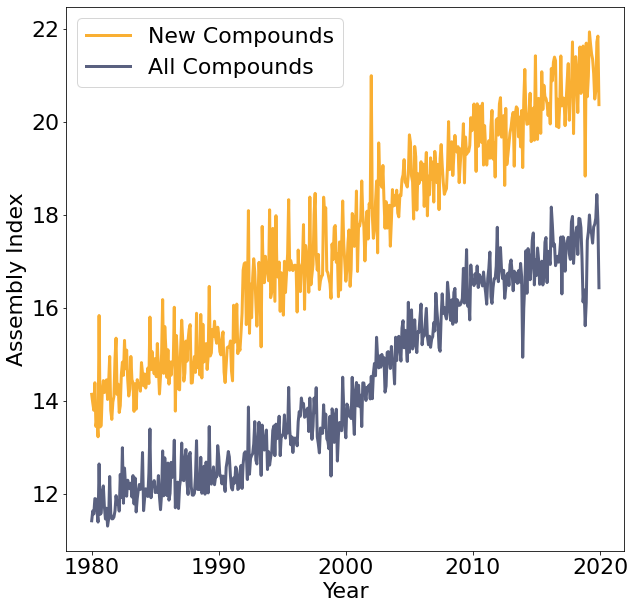

In [78]:
#Assembly values with standard deviation
plt.figure(figsize=(10,10))

plt.plot(np.arange(1980, 2020, 1/12), new_stats["MA_assemblyGo"]["mean"], color="#f89b00",
            linewidth=3, markersize=10, alpha=0.8, label="New Compounds")

plt.plot(np.arange(1980, 2020, 1/12), full_stats["MA_assemblyGo"]["mean"], color="#313a61",
            linewidth=3, markersize=10, alpha=0.8, label="All Compounds")

plt.legend()
plt.xlabel("Year")
plt.ylabel("Assembly Index")

### Full/New SureChemBL labels

The labels in the sampled compounds aren't correct, so I need to:

- Map inchis to SureChemBL labels
- Add labels, inchis, etc to MA_df below

In [3]:
def get_labels(cpd_data, year):
    #Load sampled compounds (without labels)
    month_df = pd.DataFrame(pickle.load(file=open("Data/AssemblyValues/assembly_values_1000_" + str(year) + ".p", "rb")))

    #Find labels by searching inchis
    sample_month_df = cpd_data[cpd_data["InChI"].isin(month_df["inchi"])]

    #Merge the two and rename columns (will have MAs & labels after this)
    month_label_df = pd.merge(month_df, sample_month_df, left_on="inchi", right_on="InChI")

    month_label_df = month_label_df[["ai", "SureChEMBL_ID"]]
    month_label_df.rename(columns={"ai": "MA_assemblyGo", "SureChEMBL_ID": "label"}, inplace=True)

    return month_label_df


In [4]:
fp = "/Volumes/Macintosh HD 4/SureChemBL"
cpd_data = pickle.load(file=open(fp + "/Cpd_Data/SureChemBL_allCpds.p", "rb"))

In [7]:
del (cpd_data)

In [18]:
#Create a MA & label dataframe of sampled compounds

#Full dataset first
samples = []
for year in tqdm(list(np.arange(1980, 2020, 1))):
    samples.append(get_labels(cpd_data, year))

new_df = pd.concat(samples)
new_df.to_csv("Data/AssemblyValues/NewDatabase_AssemblyGo_labeled.csv")

100%|██████████| 40/40 [03:30<00:00,  5.26s/it]


In [20]:
#New dataset second
samples = []
for year in tqdm(list(np.arange(1980, 2020, 1))):
    samples.append(get_labels(cpd_data, "FULL_" + str(year)))

full_df = pd.concat(samples)
full_df.to_csv("Data/AssemblyValues/FullDatabase_AssemblyGo_labeled.csv")

100%|██████████| 40/40 [03:23<00:00,  5.08s/it]


In [25]:
print(full_df)

        Unnamed: 0  MA_assemblyGo            label
0                0              8       SCHEMBL936
1                1              9       SCHEMBL936
2                2             77      SCHEMBL1189
3                3             77   SCHEMBL9013957
4                4             77  SCHEMBL20502357
...            ...            ...              ...
474718       12234             25  SCHEMBL21609690
474719       12235             14  SCHEMBL21609731
474720       12236             60  SCHEMBL21610029
474721       12237             16  SCHEMBL21610093
474722       12238             65  SCHEMBL21610448

[474723 rows x 3 columns]


In [33]:
del(cpd_data)

## Updated assembly change figure 

With more MA values (from patent scraping)

In [10]:
### Testing - need dates for compounds

cpd_dates = pickle.load(file=open("/Volumes/Macintosh HD 4/SureChemBL/CpdPatentIdsDates/Cpd_Date_Dict/cpd_date_dict_1980-01.p", "rb"))

print(list(cpd_dates.items())[0:5])

[('SCHEMBL1812', '1980-01-01'), ('SCHEMBL675157', '1980-01-01'), ('SCHEMBL1102', '1980-01-01'), ('SCHEMBL10855450', '1980-01-01'), ('SCHEMBL14421133', '1980-01-01')]


In [11]:
## Goal - have a dictionary with {ID:[dates]} for all compounds

import os
from collections import defaultdict

cpd_dates_FULL = defaultdict(list)

fp = "/Volumes/Macintosh HD 4/SureChemBL/CpdPatentIdsDates/Cpd_Date_Dict/"
for f in tqdm(os.listdir(fp)):
    cpd_dates = pickle.load(file=open(fp + f, "rb"))

    for k, v in cpd_dates.items():
        cpd_dates_FULL[k].append(v)


 52%|█████▏    | 369/709 [00:18<00:23, 14.47it/s]  

In [55]:
pickle.dump(cpd_dates_FULL, file=open(fp + "cpd_date_dict_FULL.p", "wb"))

In [8]:
fp = "/Volumes/Macintosh HD 4/SureChemBL/CpdPatentIdsDates/Cpd_Date_Dict/"

cpd_dates_FULL = pickle.load(file=open(fp + "cpd_date_dict_FULL.p", "rb"))

In [9]:
cpd_dates_FULL["SCHEMBL13106681"]

['2010-06-09', '2010-10-07', '2013-02-05']

Load all author cpds (eventually assignees too)

In [10]:
def get_MA(fp):
    """ Get AssemblyGo MA value

    Args:
        fp (str): filepath to a particular .txt AssemblyGo output file

    Returns:
        label (str): label of the compound which was analzyed (empty if a failure)
        MA (int): assemblyGo MA value (-1 if a failure)
    """
    with open(fp) as f:
        lines = f.readlines()

    try:
        #molfile will be the last element in 0th line
        label = lines[0].split()[-1].split("/")[-1].split(".")[0]

        #MA will be last elemnt in -2nd line (will be an int)
        MA = int(lines[-2].split()[-1])

        time = float(lines[-1].split()[-1])
        
        return label, MA, time

    except:
        return None, None, None

In [5]:
def get_MA_withDate(fp):
    """ Get AssemblyGo MA value

    Args:
        fp (str): filepath to a particular .txt AssemblyGo output file

    Returns:
        label (str): label of the compound which was analzyed (empty if a failure)
        MA (int): assemblyGo MA value (-1 if a failure)
    """
    with open(fp) as f:
        lines = f.readlines()

    try:
        #label will be everything before the period
        label = lines[0].split()[-1].split("/")[-1].split(".")[0]

        #MA will be last elemnt in -2nd line (will be an int)
        MA = int(lines[-2].split()[-1])

        time = float(lines[-1].split()[-1])
        
        return label, MA, time

    except:
        return None, None, None

In [6]:
## Testing
print(get_MA_withDate("Data/AssemblyValues/FullDatabase_Done/2021-12_10.txt"))

('2021-12_10', 4, 0.005239599)


In [11]:
## Load all author & assignee compounds into one dataframe (will eventually be merged with previously sampled cpds)

MA_values = []
count = 1

fp = "Data/AssemblyValues/AuthorCpds_Done/"
print("----- Analyzing Author Cpds ----- ")
for file in tqdm(os.listdir(fp)):
    if file.endswith(".txt"):
        label, MA, time = get_MA(fp + file)
        MA_values.append({
            "label": label,
            "MA_assemblyGo": MA,
            "time": time,
            "earliest_date": -1
        })

fp = "Data/AssemblyValues/AssigneeCpds_Done/"
print("----- Analyzing Assignee Cpds ----- ")
for file in tqdm(os.listdir(fp)):
    if file.endswith(".txt"):
        label, MA, time = get_MA(fp + file)
        MA_values.append({
            "label": label,
            "MA_assemblyGo": MA,
            "time": time,
            "earliest_date": -1
        })
        
fp = "Data/AssemblyValues/NewDatabase_Done/"
print("----- Analyzing NewDatabase Cpds ----- ")
for file in tqdm(os.listdir(fp)):
    if file.endswith(".txt"):
        date, MA, time = get_MA_withDate(fp + file)
        if date:
            MA_values.append({
                "label": date + "_new",
                "earliest_date": date,
                "MA_assemblyGo": MA,
                "time": time
            })
        else:
            print(file)
            
        
fp = "Data/AssemblyValues/FullDatabase_Done/"
print("----- Analyzing FullDatabase Cpds ----- ")
for file in tqdm(os.listdir(fp)):
    if file.endswith(".txt"):
        date, MA, time = get_MA_withDate(fp + file)
        if date:
            MA_values.append({
                "label": date + "_full",
                "earliest_date": date,
                "MA_assemblyGo": MA,
                "time": time
            })

MA_df = pd.DataFrame(MA_values)

MA_df.to_csv("Data/AssemblyValues/ALLcpds_AssemblyGo.csv")

----- Analyzing Author Cpds ----- 


100%|███████████████████████████████| 1012941/1012941 [10:42<00:00, 1576.34it/s]


----- Analyzing Assignee Cpds ----- 


100%|███████████████████████████████| 1716537/1716537 [15:09<00:00, 1887.49it/s]


----- Analyzing NewDatabase Cpds ----- 


  0%|                                     | 787/551594 [00:00<12:41, 723.61it/s]

1976-01_615.txt


  2%|▌                                  | 9099/551594 [00:06<05:48, 1555.59it/s]

1976-10_29.txt


  4%|█▎                                | 20432/551594 [00:15<06:06, 1449.11it/s]

1977-10_189.txt
1977-10_405.txt


  4%|█▍                                | 23412/551594 [00:16<04:26, 1978.88it/s]

1978-01_150.txt


  5%|█▌                                | 25017/551594 [00:17<06:07, 1432.10it/s]

1978-02_900.txt
1978-03_149.txt


  5%|█▌                                | 25740/551594 [00:18<05:09, 1700.51it/s]

1978-03_905.txt
1978-03_917.txt
1978-03_919.txt
1978-03_920.txt
1978-03_928.txt


  5%|█▋                                | 28000/551594 [00:19<04:12, 2071.90it/s]

1978-05_926.txt


  5%|█▊                                | 28496/551594 [00:19<04:00, 2172.08it/s]

1978-06_496.txt


  6%|█▉                                | 30558/551594 [00:20<04:56, 1757.68it/s]

1978-08_658.txt


  6%|█▉                                | 32158/551594 [00:21<03:58, 2179.79it/s]

1978-10_269.txt
1978-10_515.txt


  6%|██                                | 33732/551594 [00:21<03:29, 2467.53it/s]

1978-11_916.txt
1978-11_919.txt
1978-11_920.txt
1978-11_942.txt
1978-11_964.txt


  6%|██▏                               | 34650/551594 [00:22<04:28, 1925.37it/s]

1978-12_636.txt


  7%|██▎                               | 37503/551594 [00:24<04:15, 2013.62it/s]

1979-03_647.txt
1979-03_902.txt
1979-03_906.txt


  7%|██▎                               | 38285/551594 [00:24<03:36, 2375.54it/s]

1979-04_523.txt


  7%|██▍                               | 39332/551594 [00:24<03:27, 2465.75it/s]

1979-05_498.txt


  8%|██▌                               | 41449/551594 [00:25<04:55, 1729.30it/s]

1979-07_902.txt


  8%|██▊                               | 46085/551594 [00:29<05:02, 1668.97it/s]

1979-12_731.txt


  8%|██▊                               | 46542/551594 [00:29<04:25, 1899.91it/s]

1980-01_293805.txt
1980-01_294227.txt
1980-01_294256.txt


  9%|██▉                               | 47233/551594 [00:30<04:07, 2036.85it/s]

1980-01_294615.txt
1980-02_294997.txt
1980-02_294998.txt


  9%|██▉                               | 47953/551594 [00:30<03:54, 2146.02it/s]

1980-02_295252.txt
1980-02_295268.txt
1980-02_295498.txt


  9%|███                               | 49611/551594 [00:31<03:35, 2332.06it/s]

1980-04_296799.txt
1980-04_296814.txt


  9%|███                               | 50148/551594 [00:31<03:20, 2497.16it/s]

1980-04_297403.txt


  9%|███                               | 50635/551594 [00:31<03:58, 2104.80it/s]

1980-05_297857.txt
1980-05_298032.txt
1980-05_298153.txt
1980-05_298193.txt


  9%|███▏                              | 51051/551594 [00:31<04:52, 1713.02it/s]

1980-05_298454.txt
1980-05_298467.txt


  9%|███▏                              | 51529/551594 [00:32<04:15, 1955.99it/s]

1980-06_299008.txt


 10%|███▍                              | 54814/551594 [00:34<05:03, 1636.71it/s]

1980-09_302080.txt


 10%|███▍                              | 55743/551594 [00:34<04:04, 2028.43it/s]

1980-10_303148.txt


 10%|███▍                              | 56406/551594 [00:35<04:00, 2058.69it/s]

1980-11_303674.txt
1980-11_303831.txt



 10%|███▍                              | 56619/551594 [00:35<03:58, 2078.44it/s]

1980-11_304151.txt


 10%|███▌                              | 57479/551594 [00:35<04:10, 1976.36it/s]

1980-12_304813.txt
1980-12_304881.txt
1980-12_304884.txt


 11%|███▌                              | 57945/551594 [00:35<04:05, 2009.76it/s]

1980-12_305351.txt


 11%|███▋                              | 59354/551594 [00:36<04:15, 1926.28it/s]

1981-02_189207.txt


 11%|███▋                              | 60548/551594 [00:37<03:42, 2206.85it/s]

1981-03_190368.txt


 11%|███▊                              | 61000/551594 [00:37<04:11, 1949.70it/s]

1981-04_190830.txt
1981-04_190897.txt


 11%|███▊                              | 61628/551594 [00:38<07:21, 1108.73it/s]

1981-04_191388.txt
1981-04_191545.txt


 11%|███▊                              | 62622/551594 [00:38<04:32, 1797.14it/s]

1981-05_192419.txt


 11%|███▉                              | 63123/551594 [00:38<03:53, 2091.97it/s]

1981-06_192953.txt
1981-06_193027.txt
1981-06_193160.txt
1981-06_193266.txt


 12%|███▉                              | 64101/551594 [00:39<03:42, 2193.13it/s]

1981-07_193855.txt
1981-07_194340.txt


 12%|███▉                              | 64882/551594 [00:39<03:19, 2435.17it/s]

1981-08_194604.txt


 12%|████                              | 65642/551594 [00:39<03:25, 2369.75it/s]

1981-08_195517.txt


 13%|████▎                             | 69031/551594 [00:41<03:28, 2318.20it/s]

1981-12_198759.txt
1981-12_199033.txt


 13%|████▎                             | 69979/551594 [00:41<04:02, 1982.48it/s]

1982-01_82354.txt


 13%|████▎                             | 70720/551594 [00:42<04:15, 1883.03it/s]

1982-01_82982.txt


 13%|████▍                             | 71779/551594 [00:42<04:15, 1881.08it/s]

1982-03_84272.txt
1982-03_84486.txt


 13%|████▍                             | 72547/551594 [00:43<03:29, 2287.92it/s]

1982-03_84728.txt


 13%|████▌                             | 73040/551594 [00:43<03:22, 2368.98it/s]

1982-04_85397.txt


 13%|████▌                             | 73769/551594 [00:43<03:54, 2034.07it/s]

1982-05_86090.txt
1982-05_86147.txt


 14%|████▌                             | 74641/551594 [00:44<03:47, 2097.69it/s]

1982-06_87019.txt
1982-06_87141.txt


 14%|████▋                             | 75728/551594 [00:44<04:24, 1801.70it/s]

1982-07_88155.txt


 14%|████▊                             | 77646/551594 [00:45<03:26, 2292.78it/s]

1982-09_90082.txt
1982-09_90342.txt


 14%|████▊                             | 78977/551594 [00:46<04:03, 1940.31it/s]

1982-10_91453.txt


 14%|████▉                             | 79795/551594 [00:46<05:03, 1553.50it/s]

1982-11_92239.txt
1982-11_92440.txt


 15%|████▉                             | 80925/551594 [00:47<03:47, 2072.23it/s]

1982-12_93185.txt
1982-12_93212.txt
1982-12_93571.txt


 15%|█████                             | 81617/551594 [00:47<03:55, 1997.94it/s]

1983-01_411457.txt
1983-01_411726.txt
1983-01_411836.txt


 15%|█████                             | 82123/551594 [00:48<03:30, 2234.01it/s]

1983-01_412056.txt


 15%|█████                             | 82565/551594 [00:48<04:45, 1644.02it/s]

1983-02_412699.txt
1983-02_412889.txt


 15%|█████                             | 82976/551594 [00:48<04:20, 1797.05it/s]

1983-02_413000.txt
1983-02_413043.txt
1983-02_413064.txt


 15%|█████▏                            | 84021/551594 [00:49<04:17, 1818.59it/s]

1983-03_413901.txt


 15%|█████▏                            | 84906/551594 [00:49<03:49, 2030.24it/s]

1983-04_414906.txt
1983-04_415042.txt
1983-05_415418.txt


 16%|█████▎                            | 86265/551594 [00:50<03:39, 2121.65it/s]

1983-06_416354.txt


 16%|█████▎                            | 87180/551594 [00:50<03:52, 1995.82it/s]

1983-06_417016.txt
1983-06_417064.txt
1983-06_417065.txt


 16%|█████▍                            | 88319/551594 [00:51<04:11, 1840.16it/s]

1983-08_418131.txt
1983-08_418379.txt



 16%|█████▍                            | 88554/551594 [00:51<03:55, 1967.80it/s]

1983-08_418674.txt
1983-08_418780.txt


 17%|█████▋                            | 91272/551594 [00:53<03:41, 2077.30it/s]

1983-11_421186.txt
1983-11_421245.txt


 17%|█████▋                            | 92296/551594 [00:53<03:26, 2229.04it/s]

1983-12_422172.txt


 17%|█████▋                            | 92796/551594 [00:53<03:32, 2163.38it/s]

1983-12_422721.txt
1983-12_422746.txt
1983-12_422788.txt


 17%|█████▊                            | 93525/551594 [00:54<03:19, 2300.40it/s]

1984-01_329582.txt
1984-01_329912.txt


 17%|█████▊                            | 94503/551594 [00:54<03:15, 2337.68it/s]

1984-02_330734.txt
1984-02_330747.txt


 17%|█████▊                            | 95267/551594 [00:55<05:07, 1483.62it/s]

1984-03_331702.txt
1984-03_331713.txt
1984-03_331942.txt


 17%|█████▉                            | 96378/551594 [00:55<04:16, 1772.75it/s]

1984-04_332473.txt
1984-04_332555.txt
1984-04_332569.txt
1984-04_332717.txt


 18%|█████▉                            | 97117/551594 [00:56<05:02, 1503.97it/s]

1984-05_333107.txt
1984-05_333420.txt


 18%|██████                            | 98370/551594 [00:57<04:14, 1779.43it/s]

1984-06_334735.txt


 18%|██████                            | 98831/551594 [00:57<04:32, 1659.75it/s]

1984-07_335088.txt
1984-07_335354.txt
1984-07_335367.txt



 18%|██████▎                            | 99020/551594 [00:57<08:58, 840.11it/s]

1984-07_335469.txt
1984-07_335470.txt
1984-07_335471.txt
1984-07_335546.txt
1984-07_335547.txt


 18%|██████▏                           | 99770/551594 [00:58<05:19, 1415.93it/s]

1984-08_336024.txt
1984-08_336242.txt


 18%|██████                           | 101147/551594 [00:58<03:35, 2087.18it/s]

1984-09_337266.txt
1984-09_337679.txt


 18%|██████                           | 101591/551594 [00:59<03:58, 1884.49it/s]

1984-10_338002.txt
1984-10_338131.txt


 19%|██████▏                          | 102920/551594 [00:59<03:40, 2036.54it/s]

1984-11_339204.txt
1984-11_339250.txt
1984-11_339565.txt


 19%|██████▏                          | 103620/551594 [01:00<03:31, 2113.62it/s]

1984-11_339719.txt


 19%|██████▎                          | 105246/551594 [01:00<03:11, 2334.56it/s]

1985-01_212121.txt
1985-01_212353.txt
1985-01_212510.txt


 19%|██████▎                          | 105970/551594 [01:01<03:09, 2350.81it/s]

1985-02_212866.txt


 19%|██████▎                          | 106472/551594 [01:01<03:04, 2412.17it/s]

1985-02_213381.txt
1985-03_213818.txt
1985-03_213851.txt


 19%|██████▍                          | 106954/551594 [01:01<03:22, 2191.45it/s]

1985-03_214008.txt
1985-03_214420.txt


 20%|██████▍                          | 108566/551594 [01:02<04:44, 1558.45it/s]

1985-05_215689.txt


 20%|██████▌                          | 109597/551594 [01:03<03:17, 2238.71it/s]

1985-06_216603.txt


 20%|██████▋                          | 110804/551594 [01:03<03:15, 2251.30it/s]

1985-07_217833.txt


 20%|██████▋                          | 111289/551594 [01:03<03:08, 2330.33it/s]

1985-07_218384.txt
1985-08_218635.txt


 20%|██████▋                          | 112233/551594 [01:04<03:13, 2266.26it/s]

1985-08_219159.txt
1985-08_219380.txt


 20%|██████▋                          | 112693/551594 [01:04<03:12, 2279.11it/s]

1985-09_219689.txt


 21%|██████▊                          | 113476/551594 [01:04<02:56, 2482.99it/s]

1985-10_220433.txt


 21%|██████▊                          | 114475/551594 [01:05<02:58, 2453.32it/s]

1985-10_221388.txt


 21%|██████▉                          | 114969/551594 [01:05<03:09, 2306.30it/s]

1985-11_222048.txt
1985-11_222124.txt
1985-11_222253.txt
1985-11_222347.txt


 21%|██████▉                          | 116108/551594 [01:06<06:20, 1145.69it/s]

1986-01_93750.txt
1986-01_93942.txt


 21%|██████▉                          | 116669/551594 [01:06<05:11, 1395.05it/s]

1986-01_94115.txt
1986-01_94254.txt


 21%|███████                          | 117625/551594 [01:07<03:37, 1995.78it/s]

1986-02_95022.txt
1986-02_95171.txt


 21%|███████                          | 118120/551594 [01:07<05:25, 1332.92it/s]

1986-03_95864.txt



 21%|███████▎                          | 118304/551594 [01:07<07:16, 993.38it/s]

1986-03_95975.txt


 22%|███████                          | 118824/551594 [01:08<06:42, 1075.39it/s]

1986-03_96322.txt


 22%|███████▏                         | 119585/551594 [01:08<04:35, 1569.24it/s]

1986-04_97055.txt


 22%|███████▏                         | 120676/551594 [01:09<04:22, 1641.30it/s]

1986-05_98052.txt


 22%|███████▎                         | 121227/551594 [01:09<04:35, 1559.63it/s]

1986-06_98787.txt
1986-06_98947.txt
1986-06_99067.txt


 22%|███████▎                         | 121640/551594 [01:10<04:02, 1775.74it/s]

1986-06_99197.txt
1986-06_99241.txt



 22%|███████▎                         | 121825/551594 [01:10<06:16, 1142.77it/s]

1986-07_100147.txt


 22%|███████▎                         | 122412/551594 [01:10<05:51, 1221.98it/s]

1986-07_100367.txt


 23%|███████▍                         | 124438/551594 [01:11<04:14, 1675.98it/s]

1986-09_101874.txt
1986-09_101979.txt
1986-09_102009.txt


 23%|███████▍                         | 124787/551594 [01:12<04:22, 1624.32it/s]

1986-09_102259.txt


 23%|███████▍                         | 125148/551594 [01:12<04:21, 1630.29it/s]

1986-10_102635.txt
1986-10_102648.txt
1986-10_102984.txt


 23%|███████▌                         | 126186/551594 [01:12<03:47, 1866.56it/s]

1986-11_103694.txt
1986-11_103819.txt
1986-11_103881.txt


 23%|███████▌                         | 127171/551594 [01:13<04:08, 1706.95it/s]

1986-12_104680.txt



 23%|███████▌                         | 127357/551594 [01:13<04:31, 1564.48it/s]

1986-12_105157.txt
1986-12_105158.txt
1986-12_105159.txt
1986-12_105163.txt
1986-12_105164.txt
1986-12_105166.txt


 23%|███████▊                          | 127656/551594 [01:14<09:31, 741.64it/s]

1987-01_458624.txt
1987-01_458724.txt


 23%|███████▋                         | 128191/551594 [01:14<06:25, 1097.68it/s]

1987-01_458885.txt
1987-01_459127.txt


 23%|███████▋                         | 128634/551594 [01:14<04:46, 1475.78it/s]

1987-01_459394.txt
1987-02_459695.txt
1987-02_459696.txt


 23%|███████▋                         | 129223/551594 [01:15<04:28, 1570.22it/s]

1987-02_459888.txt


 24%|███████▊                         | 130083/551594 [01:15<03:37, 1940.55it/s]

1987-03_460844.txt
1987-03_460914.txt
1987-03_460932.txt


 24%|███████▊                         | 130972/551594 [01:16<03:56, 1779.86it/s]

1987-04_461686.txt
1987-04_461847.txt


 24%|███████▊                         | 131597/551594 [01:16<03:36, 1935.85it/s]

1987-05_462718.txt


 24%|███████▉                         | 131954/551594 [01:16<05:37, 1241.92it/s]

1987-05_462827.txt


 24%|███████▉                         | 132575/551594 [01:17<04:59, 1401.36it/s]

1987-05_463241.txt
1987-06_463466.txt


 24%|███████▉                         | 133479/551594 [01:18<05:31, 1261.07it/s]

1987-07_464321.txt
1987-07_464437.txt


 24%|████████                         | 133950/551594 [01:18<05:44, 1213.71it/s]

1987-07_464665.txt


 24%|████████                         | 134886/551594 [01:18<04:15, 1632.90it/s]

1987-08_465690.txt
1987-08_465702.txt
1987-08_465820.txt
1987-08_465873.txt
1987-08_465958.txt


 25%|████████                         | 135747/551594 [01:19<03:45, 1844.04it/s]

1987-09_466580.txt


 25%|████████▏                        | 136129/551594 [01:19<04:03, 1707.11it/s]

1987-09_466899.txt
1987-09_467128.txt
1987-09_467196.txt
1987-09_467200.txt


 25%|████████▏                        | 137187/551594 [01:20<03:48, 1812.07it/s]

1987-10_467862.txt
1987-10_467893.txt
1987-10_467995.txt


 25%|████████▏                        | 137647/551594 [01:20<03:37, 1899.28it/s]

1987-11_468298.txt
1987-11_468651.txt


 25%|████████▎                        | 138835/551594 [01:20<02:59, 2300.95it/s]

1987-12_469381.txt
1987-12_469613.txt


 25%|████████▎                        | 139525/551594 [01:21<03:19, 2067.72it/s]

1988-01_70376.txt


 25%|████████▍                        | 140121/551594 [01:21<04:09, 1649.13it/s]

1988-01_71058.txt
1988-01_71192.txt
1988-01_71274.txt


 26%|████████▍                        | 140942/551594 [01:22<04:11, 1631.48it/s]

1988-02_71950.txt
1988-02_72124.txt


 26%|████████▍                        | 141992/551594 [01:22<04:30, 1515.46it/s]

1988-03_73052.txt


 26%|████████▌                        | 142327/551594 [01:23<04:46, 1426.20it/s]

1988-04_73538.txt


 26%|████████▌                        | 143031/551594 [01:23<06:31, 1042.92it/s]

1988-04_73860.txt
1988-05_74245.txt


 26%|████████▌                        | 143602/551594 [01:24<05:48, 1171.72it/s]

1988-05_74698.txt


 26%|████████▌                        | 144037/551594 [01:24<05:32, 1225.38it/s]

1988-05_75058.txt


 26%|████████▉                         | 144552/551594 [01:25<07:07, 951.06it/s]

1988-06_75545.txt
1988-06_75649.txt
1988-06_75705.txt
1988-06_75879.txt


 26%|████████▋                        | 144951/551594 [01:25<05:17, 1282.44it/s]

1988-06_75923.txt


 26%|████████▋                        | 145587/551594 [01:25<06:07, 1103.85it/s]

1988-07_76727.txt
1988-07_76803.txt
1988-07_76804.txt
1988-07_76805.txt
1988-07_76808.txt
1988-07_76809.txt
1988-07_76810.txt
1988-07_76875.txt
1988-07_76907.txt


 27%|████████▋                        | 146238/551594 [01:26<04:08, 1630.58it/s]

1988-07_76999.txt
1988-07_77004.txt
1988-07_77022.txt
1988-07_77088.txt
1988-07_77106.txt


 27%|████████▊                        | 148061/551594 [01:27<03:31, 1906.11it/s]

1988-10_79362.txt


 27%|█████████▏                        | 148770/551594 [01:28<06:46, 989.90it/s]

1988-10_79673.txt


 27%|████████▉                        | 149969/551594 [01:29<03:59, 1675.88it/s]

1988-11_80976.txt
1988-11_81043.txt
1988-12_81243.txt


 27%|█████████                        | 150774/551594 [01:29<03:34, 1868.29it/s]

1988-12_81734.txt


 28%|█████████                        | 151913/551594 [01:30<04:10, 1598.04it/s]

1989-01_423700.txt
1989-01_423890.txt
1989-01_423945.txt


 28%|█████████▏                       | 152739/551594 [01:30<03:59, 1662.55it/s]

1989-02_424675.txt
1989-03_424961.txt


 28%|█████████▏                       | 153176/551594 [01:31<03:31, 1882.98it/s]

1989-03_425120.txt


 28%|█████████▏                       | 153586/551594 [01:31<03:43, 1779.46it/s]

1989-03_425728.txt


 28%|█████████▏                       | 154117/551594 [01:31<04:25, 1497.94it/s]

1989-04_426158.txt


 28%|█████████▎                       | 154972/551594 [01:32<05:21, 1233.89it/s]

1989-05_426984.txt


 28%|█████████▌                        | 155515/551594 [01:33<06:40, 988.18it/s]

1989-05_427625.txt
1989-05_427664.txt


 28%|█████████▎                       | 156551/551594 [01:34<05:00, 1313.76it/s]

1989-06_428414.txt
1989-06_428504.txt


 28%|█████████▋                        | 156834/551594 [01:34<09:59, 659.02it/s]

1989-07_428874.txt
1989-07_428921.txt


 29%|█████████▋                        | 157899/551594 [01:36<09:55, 661.21it/s]

1989-07_429805.txt


 29%|█████████▍                       | 158785/551594 [01:36<04:51, 1348.82it/s]

1989-08_430676.txt
1989-09_430798.txt


 29%|█████████▌                       | 159291/551594 [01:37<03:43, 1755.41it/s]

1989-09_431174.txt
1989-09_431432.txt
1989-09_431565.txt


 29%|█████████▌                       | 159725/551594 [01:37<04:09, 1570.17it/s]

1989-09_431768.txt


 29%|█████████▌                       | 160460/551594 [01:37<03:09, 2067.54it/s]

1989-10_432272.txt


 29%|█████████▋                       | 160902/551594 [01:37<03:16, 1986.27it/s]

1989-11_432814.txt
1989-11_433037.txt
1989-11_433126.txt


 29%|█████████▋                       | 161641/551594 [01:38<03:07, 2081.92it/s]

1989-11_433704.txt


 29%|█████████▋                       | 162218/551594 [01:39<05:23, 1203.59it/s]

1989-12_434194.txt
1989-12_434253.txt
1989-12_434363.txt


 29%|█████████▋                       | 162617/551594 [01:39<04:19, 1496.44it/s]

1989-12_434581.txt


 30%|█████████▊                       | 163372/551594 [01:39<03:54, 1654.57it/s]

1990-01_270990.txt
1990-01_271344.txt


 30%|█████████▊                       | 164126/551594 [01:40<03:50, 1681.06it/s]

1990-02_271669.txt
1990-02_271830.txt


 30%|█████████▉                       | 165643/551594 [01:40<03:17, 1957.01it/s]

1990-03_273265.txt


 30%|█████████▉                       | 166031/551594 [01:41<03:42, 1734.61it/s]

1990-04_273720.txt
1990-04_273812.txt
1990-04_273909.txt


 30%|██████████                       | 167317/551594 [01:41<03:11, 2005.02it/s]

1990-05_274943.txt


 30%|██████████                       | 167712/551594 [01:42<03:34, 1787.68it/s]

1990-06_275389.txt


 31%|██████████                       | 168778/551594 [01:42<03:14, 1966.77it/s]

1990-07_276244.txt
1990-07_276512.txt
1990-07_276513.txt
1990-07_276594.txt
1990-07_276632.txt


 31%|██████████                       | 169238/551594 [01:42<03:05, 2059.29it/s]

1990-07_276929.txt
1990-07_277089.txt


 31%|██████████▏                      | 170296/551594 [01:43<03:08, 2024.07it/s]

1990-08_277773.txt



 31%|██████████▌                       | 170501/551594 [01:44<08:29, 748.41it/s]

1990-09_278261.txt
1990-09_278414.txt
1990-09_278546.txt
1990-09_278547.txt
1990-09_278556.txt


 31%|██████████▎                      | 171590/551594 [01:44<03:50, 1651.37it/s]

1990-10_279187.txt


 31%|██████████▎                      | 172498/551594 [01:44<03:40, 1716.59it/s]

1990-11_280153.txt


 31%|██████████▎                      | 173157/551594 [01:45<03:19, 1893.73it/s]

1990-11_280658.txt
1990-11_280883.txt


 32%|██████████▍                      | 173801/551594 [01:45<03:40, 1713.26it/s]

1990-12_281503.txt
1990-12_281720.txt
1990-12_281758.txt
1990-12_281825.txt


 32%|██████████▍                      | 174214/551594 [01:45<03:37, 1736.35it/s]

1990-12_281876.txt
1990-12_281917.txt


 32%|██████████▌                      | 175739/551594 [01:46<03:14, 1930.20it/s]

1991-02_165528.txt


 32%|██████████▌                      | 176797/551594 [01:47<03:39, 1710.23it/s]

1991-03_166592.txt
1991-03_166596.txt
1991-03_166603.txt
1991-03_166995.txt


 32%|██████████▋                      | 177786/551594 [01:47<04:16, 1458.15it/s]

1991-04_167527.txt
1991-04_167723.txt


 32%|██████████▋                      | 178315/551594 [01:48<04:16, 1455.61it/s]

1991-05_168190.txt


 32%|██████████▋                      | 178909/551594 [01:48<03:39, 1696.82it/s]

1991-05_168516.txt


 33%|██████████▋                      | 179331/551594 [01:49<04:38, 1336.89it/s]

1991-06_169229.txt
1991-06_169435.txt
1991-06_169463.txt


 33%|██████████▊                      | 180003/551594 [01:49<04:50, 1279.98it/s]

1991-06_169918.txt


 33%|██████████▊                      | 180583/551594 [01:50<05:08, 1202.65it/s]

1991-07_170414.txt
1991-07_170461.txt
1991-07_170602.txt


 33%|██████████▊                      | 181375/551594 [01:50<04:20, 1423.25it/s]

1991-08_171227.txt


 33%|██████████▉                      | 181962/551594 [01:50<03:39, 1685.53it/s]

1991-08_171798.txt
1991-08_171987.txt


 33%|██████████▉                      | 182891/551594 [01:51<03:41, 1667.92it/s]

1991-09_172753.txt



 33%|███████████▎                      | 183064/551594 [01:52<08:16, 742.48it/s]

1991-10_173013.txt
1991-10_173017.txt


 33%|██████████▉                      | 183441/551594 [01:52<05:58, 1027.34it/s]

1991-10_173238.txt
1991-10_173473.txt


 33%|███████████                      | 183886/551594 [01:52<04:19, 1417.86it/s]

1991-10_173618.txt
1991-10_173694.txt
1991-10_173739.txt


 33%|███████████                      | 184735/551594 [01:52<03:40, 1660.01it/s]

1991-11_174420.txt
1991-11_174493.txt
1991-11_174616.txt


 34%|███████████                      | 185742/551594 [01:53<03:23, 1799.39it/s]

1991-12_175518.txt


 34%|███████████▏                     | 186139/551594 [01:53<03:16, 1863.10it/s]

1992-01_46881.txt


 34%|███████████▏                     | 186701/551594 [01:54<03:57, 1535.64it/s]

1992-01_47452.txt
1992-01_47556.txt
1992-01_47616.txt


 34%|███████████▏                     | 187270/551594 [01:54<04:41, 1294.20it/s]

1992-02_47989.txt


 34%|███████████▎                     | 188634/551594 [01:55<04:40, 1291.94it/s]

1992-03_49407.txt


 34%|███████████▎                     | 189797/551594 [01:56<03:50, 1567.53it/s]

1992-04_50490.txt


 34%|███████████▍                     | 190209/551594 [01:56<03:44, 1607.30it/s]

1992-05_50868.txt
1992-05_50890.txt
1992-05_51134.txt


 35%|███████████▍                     | 190541/551594 [01:56<04:02, 1488.52it/s]

1992-05_51276.txt


 35%|███████████▍                     | 191012/551594 [01:57<04:25, 1359.59it/s]

1992-06_51733.txt
1992-06_51739.txt
1992-06_51858.txt


 35%|███████████▊                      | 192017/551594 [01:58<06:46, 884.41it/s]

1992-07_52653.txt
1992-07_52927.txt


 35%|███████████▌                     | 192424/551594 [01:58<04:52, 1228.98it/s]

1992-07_53129.txt
1992-07_53201.txt
1992-07_53389.txt
1992-07_53445.txt


 35%|███████████▌                     | 193672/551594 [01:59<03:04, 1937.07it/s]

1992-08_54239.txt
1992-08_54396.txt
1992-08_54462.txt
1992-09_54610.txt


 36%|███████████▋                     | 195832/551594 [02:00<03:23, 1750.83it/s]

1992-10_56391.txt
1992-10_56455.txt
1992-11_56633.txt
1992-11_56681.txt
1992-11_56683.txt
1992-11_56684.txt
1992-11_56685.txt
1992-11_56790.txt


 36%|███████████▋                     | 196266/551594 [02:00<03:02, 1947.20it/s]

1992-11_56848.txt


 36%|███████████▊                     | 197047/551594 [02:01<04:04, 1448.48it/s]

1992-12_57817.txt
1992-12_57883.txt


 36%|███████████▊                     | 197961/551594 [02:01<03:08, 1879.34it/s]

1993-01_376350.txt


 36%|███████████▉                     | 198524/551594 [02:02<03:35, 1639.38it/s]

1993-01_377027.txt
1993-01_377147.txt


 36%|███████████▉                     | 199388/551594 [02:02<02:57, 1979.61it/s]

1993-02_377755.txt
1993-02_377871.txt
1993-02_377903.txt
1993-02_378096.txt


 36%|███████████▉                     | 200066/551594 [02:02<02:42, 2163.47it/s]

1993-03_378332.txt


 36%|████████████                     | 201064/551594 [02:03<03:46, 1546.31it/s]

1993-04_379584.txt


 37%|████████████                     | 202590/551594 [02:04<03:41, 1574.22it/s]

1993-06_381165.txt


 37%|████████████▏                    | 203114/551594 [02:04<04:41, 1239.48it/s]

1993-06_381544.txt
1993-06_381553.txt
1993-06_381725.txt


 37%|████████████▏                    | 203611/551594 [02:05<03:30, 1656.71it/s]

1993-06_382043.txt
1993-07_382405.txt


 37%|████████████▎                    | 205133/551594 [02:05<03:02, 1895.48it/s]

1993-08_383539.txt


 37%|████████████▎                    | 205525/551594 [02:06<03:20, 1727.41it/s]

1993-08_383910.txt


 37%|████████████▎                    | 205972/551594 [02:06<03:00, 1916.77it/s]

1993-09_384436.txt


 37%|████████████▎                    | 206780/551594 [02:06<03:12, 1789.89it/s]

1993-10_385173.txt
1993-10_385396.txt
1993-10_385471.txt
1993-10_385472.txt


 38%|████████████▍                    | 207501/551594 [02:07<02:41, 2134.52it/s]

1993-10_385777.txt


 38%|████████████▍                    | 207950/551594 [02:07<02:39, 2153.27it/s]

1993-11_386358.txt
1993-11_386377.txt


 38%|████████████▌                    | 208949/551594 [02:07<03:22, 1691.76it/s]

1993-12_387501.txt
1993-12_387666.txt
1993-12_387672.txt


 38%|████████████▌                    | 209806/551594 [02:08<02:54, 1956.83it/s]

1994-01_247126.txt


 38%|████████████▌                    | 210485/551594 [02:08<03:49, 1487.15it/s]

1994-02_248100.txt
1994-02_248103.txt


 38%|████████████▋                    | 211056/551594 [02:09<03:23, 1673.10it/s]

1994-02_248468.txt
1994-02_248682.txt
1994-02_248798.txt
1994-02_248816.txt


 38%|████████████▋                    | 211632/551594 [02:09<04:08, 1365.75it/s]

1994-03_249096.txt
1994-03_249275.txt
1994-03_249290.txt


 38%|████████████▋                    | 212288/551594 [02:09<03:20, 1695.89it/s]

1994-03_249781.txt
1994-04_250001.txt


 39%|████████████▊                    | 213600/551594 [02:10<02:43, 2071.21it/s]

1994-05_251064.txt
1994-05_251550.txt


 39%|████████████▊                    | 214353/551594 [02:10<02:26, 2298.47it/s]

1994-06_251950.txt
1994-06_252228.txt
1994-06_252229.txt
1994-06_252230.txt
1994-06_252231.txt
1994-06_252232.txt


 39%|████████████▊                    | 214847/551594 [02:11<02:44, 2046.43it/s]

1994-06_252278.txt
1994-06_252279.txt
1994-06_252598.txt


 39%|████████████▉                    | 215780/551594 [02:11<02:35, 2157.96it/s]

1994-07_253160.txt


 39%|████████████▉                    | 216486/551594 [02:11<02:27, 2274.81it/s]

1994-08_253766.txt


 39%|████████████▉                    | 216983/551594 [02:12<02:27, 2268.06it/s]

1994-08_254477.txt
1994-08_254648.txt
1994-09_254753.txt


 40%|█████████████                    | 217882/551594 [02:12<02:40, 2081.82it/s]

1994-09_255249.txt


 40%|█████████████                    | 218603/551594 [02:12<02:26, 2279.09it/s]

1994-10_256068.txt
1994-10_256473.txt


 40%|█████████████                    | 219286/551594 [02:13<02:32, 2177.78it/s]

1994-11_256818.txt


 40%|█████████████▏                   | 219722/551594 [02:13<02:36, 2127.11it/s]

1994-11_257263.txt
1994-11_257297.txt


 40%|█████████████▏                   | 221062/551594 [02:14<02:48, 1959.84it/s]

1994-12_258426.txt
1994-12_258438.txt
1995-01_128983.txt
1995-01_129036.txt


 40%|█████████████▎                   | 221520/551594 [02:14<02:51, 1927.90it/s]

1995-01_129408.txt
1995-01_129540.txt
1995-01_129572.txt
1995-01_129671.txt


 40%|█████████████▎                   | 221914/551594 [02:14<03:30, 1567.19it/s]

1995-01_129902.txt
1995-01_129905.txt
1995-02_130192.txt


 40%|█████████████▎                   | 222654/551594 [02:15<02:40, 2053.16it/s]

1995-02_130524.txt
1995-02_130771.txt
1995-03_130996.txt


 41%|█████████████▍                   | 223708/551594 [02:15<02:48, 1944.98it/s]

1995-03_131483.txt
1995-03_131655.txt


 41%|█████████████▍                   | 224193/551594 [02:15<02:41, 2031.43it/s]

1995-04_131996.txt


 41%|█████████████▍                   | 225299/551594 [02:16<02:32, 2135.32it/s]

1995-05_132978.txt
1995-05_133195.txt
1995-05_133424.txt


 41%|█████████████▌                   | 225775/551594 [02:16<02:27, 2214.18it/s]

1995-05_133575.txt
1995-05_133652.txt


 41%|█████████████▌                   | 226440/551594 [02:16<03:08, 1726.58it/s]

1995-06_134335.txt
1995-06_134375.txt


 41%|█████████████▌                   | 226939/551594 [02:17<02:40, 2023.63it/s]

1995-06_134795.txt


 41%|█████████████▌                   | 227397/551594 [02:17<02:40, 2017.83it/s]

1995-07_135270.txt


 41%|█████████████▋                   | 228285/551594 [02:17<02:58, 1808.65it/s]

1995-08_136146.txt
1995-08_136195.txt


 41%|█████████████▋                   | 228691/551594 [02:18<02:49, 1910.06it/s]

1995-08_136503.txt
1995-08_136511.txt
1995-08_136702.txt
1995-08_136703.txt


 42%|█████████████▊                   | 230283/551594 [02:18<02:28, 2157.21it/s]

1995-10_138039.txt
1995-10_138185.txt
1995-10_138306.txt
1995-10_138392.txt


 42%|█████████████▊                   | 231035/551594 [02:19<02:15, 2373.34it/s]

1995-11_138727.txt
1995-11_138913.txt
1995-11_138961.txt


 42%|█████████████▊                   | 231765/551594 [02:19<02:18, 2305.37it/s]

1995-11_139538.txt
1995-11_139647.txt
1995-11_139680.txt


 42%|█████████████▉                   | 232375/551594 [02:20<03:12, 1655.64it/s]

1995-12_140295.txt
1995-12_140470.txt


 42%|█████████████▉                   | 233022/551594 [02:20<02:48, 1894.43it/s]

1996-01_321.txt
1996-01_422.txt
1996-01_565.txt


 42%|█████████████▉                   | 233944/551594 [02:20<02:34, 2053.44it/s]

1996-01_99.txt



 42%|██████████████                   | 234171/551594 [02:20<02:30, 2112.85it/s]

1996-02_1484.txt


 43%|██████████████                   | 234597/551594 [02:21<02:37, 2014.42it/s]

1996-02_1916.txt


 43%|██████████████                   | 235637/551594 [02:21<03:06, 1690.74it/s]

1996-03_2922.txt
1996-04_3095.txt
1996-04_3291.txt


 43%|██████████████▏                  | 236351/551594 [02:22<03:05, 1703.04it/s]

1996-04_3521.txt
1996-04_3851.txt


 43%|██████████████▏                  | 237718/551594 [02:23<03:31, 1484.06it/s]

1996-05_4768.txt
1996-05_4769.txt
1996-06_5121.txt


 43%|██████████████▏                  | 238173/551594 [02:23<02:55, 1786.28it/s]

1996-06_5386.txt
1996-06_5754.txt


 43%|██████████████▎                  | 238863/551594 [02:23<02:50, 1836.70it/s]

1996-07_6124.txt


 43%|██████████████▎                  | 239342/551594 [02:23<02:29, 2088.64it/s]

1996-07_6529.txt


 44%|██████████████▎                  | 240056/551594 [02:24<02:29, 2083.66it/s]

1996-08_7255.txt
1996-08_7389.txt
1996-08_7552.txt


 44%|██████████████▍                  | 240782/551594 [02:24<02:28, 2089.45it/s]

1996-09_7909.txt


 44%|██████████████▍                  | 241719/551594 [02:24<02:20, 2204.62it/s]

1996-10_8805.txt
1996-10_9031.txt
1996-10_9076.txt


 44%|██████████████▍                  | 242164/551594 [02:25<02:27, 2091.97it/s]

1996-10_9368.txt
1996-10_9695.txt
1996-10_9696.txt


 44%|██████████████▌                  | 242646/551594 [02:25<02:19, 2211.94it/s]

1996-11_10187.txt
1996-11_10256.txt
1996-11_10275.txt


 44%|██████████████▌                  | 243371/551594 [02:25<02:20, 2198.32it/s]

1996-11_10609.txt



 44%|██████████████▌                  | 243600/551594 [02:25<02:42, 1890.74it/s]

1996-12_10928.txt
1996-12_11051.txt


 44%|██████████████▋                  | 244490/551594 [02:26<02:37, 1955.81it/s]

1996-12_11627.txt


 44%|██████████████▋                  | 244952/551594 [02:26<02:24, 2122.21it/s]

1997-01_365026.txt
1997-01_365293.txt


 45%|██████████████▋                  | 245605/551594 [02:26<02:28, 2063.75it/s]

1997-01_365466.txt



 45%|██████████████▋                  | 245864/551594 [02:26<02:19, 2196.87it/s]

1997-02_365926.txt
1997-02_365929.txt


 45%|██████████████▊                  | 247181/551594 [02:27<02:48, 1810.55it/s]

1997-03_367221.txt


 45%|██████████████▊                  | 247863/551594 [02:28<02:39, 1906.50it/s]

1997-04_367769.txt
1997-04_368022.txt


 45%|██████████████▊                  | 248505/551594 [02:28<02:36, 1939.24it/s]

1997-05_368438.txt
1997-05_368530.txt
1997-05_368609.txt


 45%|██████████████▉                  | 249524/551594 [02:29<02:40, 1882.19it/s]

1997-06_369458.txt


 45%|██████████████▉                  | 250012/551594 [02:29<02:23, 2103.04it/s]

1997-06_369875.txt
1997-06_369909.txt
1997-06_370083.txt
1997-06_370196.txt


 45%|███████████████                  | 250945/551594 [02:29<02:24, 2081.66it/s]

1997-07_370935.txt
1997-07_370971.txt


 46%|███████████████                  | 252075/551594 [02:30<02:35, 1928.39it/s]

1997-08_372124.txt
1997-08_372189.txt
1997-08_372219.txt
1997-08_372299.txt


 46%|███████████████                  | 252513/551594 [02:30<02:26, 2035.68it/s]

1997-09_372533.txt
1997-09_372549.txt
1997-09_372703.txt


 46%|███████████████▏                 | 253208/551594 [02:30<02:14, 2222.52it/s]

1997-09_373075.txt


 46%|███████████████▏                 | 254113/551594 [02:31<02:22, 2093.84it/s]

1997-10_374003.txt
1997-10_374062.txt


 46%|███████████████▏                 | 254770/551594 [02:31<02:22, 2088.04it/s]

1997-11_374669.txt
1997-11_374965.txt



 46%|███████████████▎                 | 254982/551594 [02:31<03:22, 1467.19it/s]

1997-11_375152.txt



 46%|███████████████▎                 | 255229/551594 [02:31<02:57, 1668.82it/s]

1997-12_375331.txt


 46%|███████████████▎                 | 256106/551594 [02:32<02:35, 1903.31it/s]

1997-12_376035.txt
1998-01_35238.txt


 47%|███████████████▎                 | 256788/551594 [02:32<02:30, 1963.07it/s]

1998-01_35680.txt
1998-01_35918.txt
1998-01_35933.txt
1998-01_35936.txt
1998-01_35941.txt


 47%|███████████████▍                 | 257749/551594 [02:33<02:15, 2173.44it/s]

1998-02_36558.txt
1998-02_36710.txt
1998-02_36898.txt


 47%|███████████████▌                 | 259862/551594 [02:34<02:40, 1819.27it/s]

1998-04_38573.txt
1998-04_38654.txt
1998-04_38797.txt


 47%|███████████████▌                 | 260355/551594 [02:34<02:18, 2101.60it/s]

1998-05_39111.txt
1998-05_39258.txt
1998-05_39547.txt


 47%|███████████████▌                 | 260834/551594 [02:34<02:25, 1996.24it/s]

1998-05_39745.txt
1998-06_40127.txt


 47%|███████████████▋                 | 261598/551594 [02:35<02:04, 2320.54it/s]

1998-06_40411.txt
1998-06_40713.txt
1998-06_40717.txt
1998-06_40720.txt


 48%|███████████████▋                 | 262579/551594 [02:35<02:16, 2112.75it/s]

1998-07_41339.txt


 48%|███████████████▊                 | 263849/551594 [02:36<01:59, 2406.21it/s]

1998-08_42645.txt


 48%|███████████████▊                 | 264320/551594 [02:36<02:11, 2182.34it/s]

1998-09_43186.txt
1998-09_43240.txt
1998-09_43330.txt
1998-09_43404.txt
1998-09_43558.txt


 48%|███████████████▉                 | 265641/551594 [02:37<02:21, 2016.69it/s]

1998-10_44526.txt


 48%|███████████████▉                 | 266416/551594 [02:37<02:01, 2354.04it/s]

1998-11_45065.txt
1998-11_45497.txt



 48%|███████████████▉                 | 266656/551594 [02:37<02:05, 2277.38it/s]

1998-11_45610.txt
1998-11_45729.txt
1998-12_45854.txt


 48%|███████████████▉                 | 267094/551594 [02:37<02:59, 1589.00it/s]

1998-12_46124.txt


 48%|████████████████                 | 267485/551594 [02:38<03:25, 1382.16it/s]

1998-12_46339.txt
1998-12_46484.txt
1999-01_387890.txt


 49%|████████████████                 | 268443/551594 [02:38<02:22, 1992.90it/s]

1999-01_388281.txt
1999-01_388376.txt
1999-01_388563.txt
1999-01_388565.txt
1999-01_388566.txt
1999-01_388568.txt
1999-01_388570.txt
1999-01_388581.txt
1999-01_388693.txt


 49%|████████████████                 | 268957/551594 [02:38<02:05, 2247.77it/s]

1999-01_388783.txt
1999-02_389178.txt


 49%|████████████████▏                | 269932/551594 [02:39<01:59, 2348.87it/s]

1999-02_389811.txt


 49%|████████████████▏                | 270409/551594 [02:39<02:00, 2338.60it/s]

1999-03_390416.txt
1999-03_390443.txt
1999-03_390542.txt
1999-04_390917.txt


 49%|████████████████▏                | 271423/551594 [02:39<01:58, 2367.94it/s]

1999-04_391323.txt
1999-04_391641.txt


 49%|████████████████▎                | 272419/551594 [02:40<02:01, 2290.66it/s]

1999-05_392402.txt
1999-06_392829.txt


 50%|████████████████▎                | 273158/551594 [02:40<02:03, 2256.97it/s]

1999-06_393052.txt
1999-06_393376.txt


 50%|████████████████▍                | 274187/551594 [02:40<01:54, 2423.45it/s]

1999-07_394032.txt


 50%|████████████████▍                | 274956/551594 [02:41<01:50, 2514.35it/s]

1999-08_394819.txt
1999-08_395318.txt
1999-08_395353.txt


 50%|████████████████▌                | 275967/551594 [02:41<02:06, 2172.05it/s]

1999-09_395951.txt
1999-09_396030.txt
1999-09_396103.txt
1999-09_396232.txt
1999-09_396401.txt
1999-09_396408.txt


 50%|████████████████▌                | 277226/551594 [02:42<01:54, 2404.60it/s]

1999-10_397145.txt
1999-10_397432.txt
1999-10_397550.txt


 50%|████████████████▌                | 277732/551594 [02:42<01:55, 2369.72it/s]

1999-11_397697.txt
1999-11_397732.txt


 50%|████████████████▋                | 278441/551594 [02:42<02:00, 2272.64it/s]

1999-11_398404.txt
1999-11_398570.txt
1999-12_398679.txt


 51%|████████████████▋                | 279669/551594 [02:43<01:57, 2313.80it/s]

1999-12_399545.txt
2000-01_11851.txt
2000-01_11864.txt
2000-01_12057.txt


 51%|████████████████▊                | 280143/551594 [02:43<01:57, 2316.86it/s]

2000-01_12243.txt
2000-01_12354.txt
2000-01_12592.txt


 51%|████████████████▊                | 281822/551594 [02:44<01:55, 2341.53it/s]

2000-03_13802.txt
2000-03_13881.txt
2000-03_13908.txt
2000-03_14103.txt
2000-03_14104.txt
2000-03_14105.txt
2000-03_14106.txt


 51%|████████████████▉                | 282243/551594 [02:44<04:16, 1049.33it/s]

2000-03_14600.txt


 51%|████████████████▉                | 283272/551594 [02:45<03:10, 1405.56it/s]

2000-04_15456.txt


 51%|████████████████▉                | 283895/551594 [02:46<03:41, 1206.37it/s]

2000-05_16178.txt
2000-05_16188.txt


 52%|█████████████████                | 284727/551594 [02:46<02:42, 1645.77it/s]

2000-06_16769.txt
2000-06_16822.txt
2000-06_16861.txt
2000-06_17153.txt


 52%|█████████████████                | 285660/551594 [02:47<02:08, 2071.87it/s]

2000-07_17696.txt


 52%|█████████████████                | 286137/551594 [02:47<02:00, 2205.68it/s]

2000-07_18175.txt
2000-07_18194.txt
2000-07_18434.txt
2000-08_18514.txt


 52%|█████████████████▏               | 286630/551594 [02:47<01:54, 2307.09it/s]

2000-08_18757.txt
2000-08_19048.txt


 52%|█████████████████▏               | 287536/551594 [02:48<02:08, 2048.89it/s]

2000-09_19546.txt
2000-09_19547.txt
2000-09_19548.txt
2000-09_19549.txt
2000-09_19550.txt
2000-09_19551.txt
2000-09_19927.txt


 52%|█████████████████▏               | 288046/551594 [02:48<01:55, 2272.86it/s]

2000-09_20095.txt
2000-09_20176.txt
2000-09_20308.txt


 52%|█████████████████▎               | 289312/551594 [02:48<01:50, 2381.26it/s]

2000-10_21287.txt


 53%|█████████████████▎               | 290088/551594 [02:49<01:44, 2511.67it/s]

2000-11_22072.txt
2000-11_22178.txt


 53%|█████████████████▍               | 291139/551594 [02:49<02:43, 1595.10it/s]

2000-12_23230.txt


 53%|█████████████████▍               | 292042/551594 [02:50<03:08, 1375.99it/s]

2001-01_353684.txt


 53%|█████████████████▌               | 292526/551594 [02:50<03:13, 1340.37it/s]

2001-02_354210.txt
2001-02_354417.txt


 53%|█████████████████▌               | 292984/551594 [02:51<02:31, 1703.31it/s]

2001-02_354462.txt
2001-03_354727.txt



 53%|█████████████████▌               | 293232/551594 [02:51<02:17, 1879.86it/s]

2001-03_355062.txt
2001-03_355275.txt


 53%|█████████████████▋               | 294824/551594 [02:52<02:17, 1863.53it/s]

2001-04_356464.txt
2001-05_356775.txt
2001-05_356851.txt
2001-05_356870.txt


 54%|█████████████████▋               | 296106/551594 [02:52<02:22, 1794.39it/s]

2001-06_357699.txt
2001-06_357726.txt
2001-06_357932.txt
2001-06_358099.txt


 54%|█████████████████▋               | 296579/551594 [02:52<02:04, 2045.85it/s]

2001-06_358240.txt


 54%|█████████████████▊               | 297410/551594 [02:53<02:07, 1988.45it/s]

2001-07_358998.txt
2001-07_359435.txt


 54%|█████████████████▊               | 297845/551594 [02:53<02:02, 2073.13it/s]

2001-07_359499.txt


 54%|█████████████████▉               | 298950/551594 [02:54<02:34, 1635.89it/s]

2001-08_360545.txt
2001-09_360632.txt


 54%|█████████████████▉               | 299570/551594 [02:54<02:19, 1804.75it/s]

2001-09_361073.txt
2001-09_361396.txt


 54%|█████████████████▉               | 299971/551594 [02:55<02:21, 1779.83it/s]

2001-09_361568.txt


 54%|█████████████████▉               | 300471/551594 [02:55<02:00, 2091.87it/s]

2001-10_362028.txt
2001-10_362158.txt
2001-10_362279.txt
2001-10_362297.txt
2001-10_362339.txt
2001-10_362469.txt
2001-10_362508.txt


 55%|██████████████████               | 301213/551594 [02:55<02:02, 2047.10it/s]

2001-11_362965.txt
2001-11_363093.txt


 55%|██████████████████               | 301896/551594 [02:55<01:56, 2138.00it/s]

2001-11_363491.txt
2001-12_363768.txt
2001-12_363886.txt


 55%|██████████████████               | 302660/551594 [02:56<01:45, 2365.65it/s]

2001-12_364102.txt
2001-12_364201.txt


 55%|██████████████████▏              | 303394/551594 [02:56<01:51, 2232.54it/s]

2002-01_235637.txt
2002-01_235768.txt


 55%|██████████████████▏              | 304401/551594 [02:56<01:44, 2361.23it/s]

2002-02_236736.txt
2002-02_237001.txt


 55%|██████████████████▏              | 305003/551594 [02:57<03:25, 1200.74it/s]

2002-03_237277.txt


 55%|██████████████████▎              | 305466/551594 [02:58<02:34, 1593.20it/s]

2002-03_237976.txt


 55%|██████████████████▎              | 305830/551594 [02:58<03:42, 1106.86it/s]

2002-04_238326.txt


 56%|██████████████████▉               | 306225/551594 [02:59<04:45, 858.83it/s]

2002-04_238694.txt
2002-04_238695.txt
2002-04_238817.txt
2002-04_238828.txt


 56%|██████████████████▎              | 306945/551594 [02:59<02:47, 1460.88it/s]

2002-05_239224.txt
2002-05_239601.txt


 56%|██████████████████▍              | 307374/551594 [02:59<02:20, 1734.18it/s]

2002-05_239726.txt


 56%|██████████████████▍              | 308354/551594 [02:59<01:48, 2242.31it/s]

2002-06_240603.txt
2002-06_240672.txt
2002-06_240964.txt
2002-06_241013.txt
2002-06_241030.txt


 56%|██████████████████▍              | 309116/551594 [03:00<01:40, 2422.81it/s]

2002-07_241367.txt
2002-07_241691.txt


 56%|██████████████████▌              | 310642/551594 [03:00<01:39, 2417.89it/s]

2002-08_242916.txt
2002-08_242987.txt
2002-09_242993.txt
2002-09_243366.txt


 56%|██████████████████▋              | 311373/551594 [03:01<01:46, 2246.74it/s]

2002-09_243617.txt
2002-09_243760.txt
2002-09_243801.txt
2002-10_244011.txt
2002-10_244013.txt
2002-10_244014.txt
2002-10_244015.txt
2002-10_244017.txt
2002-10_244018.txt


 57%|██████████████████▋              | 312086/551594 [03:01<01:46, 2246.14it/s]

2002-10_244375.txt
2002-10_244613.txt
2002-10_244635.txt
2002-10_244791.txt


 57%|██████████████████▋              | 312538/551594 [03:01<01:52, 2122.11it/s]

2002-10_244873.txt


 57%|██████████████████▋              | 313032/551594 [03:01<01:44, 2277.11it/s]

2002-11_245324.txt
2002-11_245778.txt


 57%|██████████████████▊              | 314649/551594 [03:02<01:59, 1990.39it/s]

2003-01_140668.txt
2003-01_140885.txt


 57%|██████████████████▊              | 315291/551594 [03:03<03:03, 1290.08it/s]

2003-01_141375.txt
2003-02_141853.txt


 57%|██████████████████▉              | 316028/551594 [03:03<02:06, 1861.28it/s]

2003-02_142012.txt
2003-02_142396.txt


 57%|██████████████████▉              | 316516/551594 [03:03<01:50, 2123.57it/s]

2003-02_142575.txt
2003-03_142639.txt
2003-03_142952.txt


 57%|██████████████████▉              | 317023/551594 [03:04<01:41, 2317.73it/s]

2003-03_143104.txt
2003-03_143113.txt
2003-03_143114.txt
2003-03_143361.txt
2003-03_143388.txt
2003-03_143399.txt
2003-03_143448.txt
2003-03_143472.txt


 58%|███████████████████              | 318028/551594 [03:04<01:38, 2367.05it/s]

2003-04_144014.txt
2003-04_144314.txt
2003-04_144395.txt


 58%|███████████████████              | 318502/551594 [03:04<01:58, 1970.95it/s]

2003-05_144570.txt


 58%|███████████████████              | 318964/551594 [03:04<01:52, 2062.44it/s]

2003-05_144981.txt
2003-05_145016.txt
2003-05_145138.txt
2003-05_145391.txt


 58%|███████████████████▏             | 319691/551594 [03:05<01:42, 2251.54it/s]

2003-06_145580.txt
2003-06_145645.txt
2003-06_145876.txt
2003-06_145941.txt
2003-06_145976.txt


 58%|███████████████████▏             | 320696/551594 [03:05<01:35, 2429.24it/s]

2003-07_146600.txt


 58%|███████████████████▏             | 321436/551594 [03:06<01:38, 2335.47it/s]

2003-07_147311.txt


 58%|███████████████████▎             | 322192/551594 [03:06<01:33, 2451.95it/s]

2003-08_148175.txt
2003-09_148455.txt
2003-09_148636.txt


 59%|███████████████████▎             | 323207/551594 [03:06<01:31, 2496.72it/s]

2003-09_149247.txt
2003-10_149435.txt
2003-10_149464.txt
2003-10_149547.txt


 59%|███████████████████▎             | 323720/551594 [03:06<01:35, 2381.26it/s]

2003-10_150214.txt


 59%|███████████████████▍             | 324958/551594 [03:07<01:51, 2028.28it/s]

2003-11_150952.txt
2003-11_151180.txt
2003-11_151263.txt
2003-12_151461.txt


 59%|███████████████████▍             | 325751/551594 [03:08<01:34, 2392.21it/s]

2003-12_151747.txt
2003-12_151769.txt
2003-12_152172.txt
2003-12_152232.txt


 59%|███████████████████▌             | 326262/551594 [03:08<01:31, 2470.09it/s]

2004-01_23335.txt
2004-01_23407.txt
2004-01_23440.txt
2004-01_23652.txt


 59%|███████████████████▌             | 326783/551594 [03:08<01:31, 2448.56it/s]

2004-01_23899.txt
2004-01_24189.txt


 59%|███████████████████▌             | 327552/551594 [03:08<01:30, 2472.74it/s]

2004-02_24484.txt
2004-02_24631.txt


 59%|███████████████████▋             | 328068/551594 [03:08<01:28, 2527.03it/s]

2004-02_25064.txt
2004-03_25324.txt


 60%|███████████████████▋             | 328589/551594 [03:09<01:29, 2492.14it/s]

2004-03_25607.txt
2004-03_26090.txt


 60%|███████████████████▋             | 329349/551594 [03:09<01:33, 2376.44it/s]

2004-04_26265.txt


 60%|███████████████████▋             | 329826/551594 [03:09<01:38, 2259.99it/s]

2004-04_26841.txt
2004-04_27023.txt


 60%|███████████████████▊             | 331063/551594 [03:10<01:35, 2313.50it/s]

2004-05_28052.txt
2004-06_28187.txt
2004-06_28507.txt


 60%|███████████████████▊             | 331556/551594 [03:10<01:34, 2327.41it/s]

2004-06_28533.txt
2004-06_28604.txt
2004-06_28916.txt
2004-06_28983.txt


 60%|███████████████████▊             | 332056/551594 [03:10<01:33, 2355.22it/s]

2004-07_29149.txt


 60%|███████████████████▉             | 332830/551594 [03:11<01:27, 2495.53it/s]

2004-07_29892.txt
2004-07_29948.txt
2004-07_30071.txt


 61%|███████████████████▉             | 333845/551594 [03:11<02:05, 1734.46it/s]

2004-08_30742.txt
2004-08_31083.txt
2004-09_31145.txt


 61%|████████████████████             | 334881/551594 [03:12<01:33, 2316.13it/s]

2004-09_31728.txt
2004-09_31825.txt
2004-09_31943.txt


 61%|████████████████████             | 335636/551594 [03:12<01:35, 2249.89it/s]

2004-10_32714.txt


 61%|████████████████████             | 336140/551594 [03:12<01:33, 2309.39it/s]

2004-11_33197.txt
2004-11_33606.txt


 61%|████████████████████▏            | 336594/551594 [03:12<01:44, 2049.82it/s]

2004-11_33682.txt
2004-11_33737.txt


 61%|████████████████████▏            | 337068/551594 [03:13<01:41, 2115.02it/s]

2004-12_34119.txt
2004-12_34133.txt
2004-12_34407.txt


 61%|████████████████████▏            | 338006/551594 [03:13<01:35, 2241.49it/s]

2004-12_34955.txt
2004-12_35007.txt
2004-12_35021.txt


 61%|████████████████████▎            | 338727/551594 [03:13<01:37, 2183.53it/s]

2005-01_400469.txt


 62%|████████████████████▎            | 339508/551594 [03:14<01:27, 2428.87it/s]

2005-02_401040.txt
2005-02_401273.txt
2005-02_401324.txt
2005-02_401394.txt


 62%|████████████████████▎            | 340017/551594 [03:14<01:26, 2458.68it/s]

2005-03_401706.txt
2005-03_402028.txt


 62%|████████████████████▍            | 341968/551594 [03:15<01:36, 2179.56it/s]

2005-04_403501.txt


 62%|████████████████████▌            | 342991/551594 [03:15<01:58, 1767.18it/s]

2005-05_404482.txt
2005-05_404483.txt
2005-05_404485.txt
2005-06_404494.txt


 62%|████████████████████▌            | 343491/551594 [03:16<01:40, 2069.23it/s]

2005-06_405118.txt
2005-07_405565.txt


 62%|████████████████████▌            | 344502/551594 [03:16<01:26, 2406.15it/s]

2005-07_406142.txt
2005-07_406374.txt
2005-08_406458.txt
2005-08_406499.txt


 63%|████████████████████▋            | 345240/551594 [03:16<01:54, 1801.95it/s]

2005-08_406905.txt
2005-08_406983.txt
2005-08_407115.txt


 63%|████████████████████▋            | 345730/551594 [03:17<01:58, 1742.68it/s]

2005-09_407462.txt
2005-09_407588.txt


 63%|████████████████████▋            | 346163/551594 [03:17<01:45, 1938.73it/s]

2005-09_407816.txt


 63%|████████████████████▋            | 346619/551594 [03:17<01:41, 2013.28it/s]

2005-09_408328.txt
2005-10_408622.txt


 63%|████████████████████▊            | 347525/551594 [03:18<01:37, 2097.49it/s]

2005-10_409116.txt
2005-10_409246.txt
2005-10_409270.txt
2005-11_409349.txt
2005-11_409562.txt


 63%|████████████████████▊            | 348029/551594 [03:18<01:28, 2291.11it/s]

2005-11_409672.txt


 63%|████████████████████▉            | 349231/551594 [03:18<01:27, 2309.29it/s]

2005-12_410850.txt
2006-01_282081.txt


 64%|████████████████████▉            | 350916/551594 [03:19<01:48, 1854.05it/s]

2006-02_283392.txt


 64%|█████████████████████            | 351353/551594 [03:20<02:21, 1416.13it/s]

2006-02_283750.txt
2006-02_283762.txt
2006-02_283841.txt
2006-02_283980.txt


 64%|█████████████████████            | 351830/551594 [03:20<01:53, 1762.88it/s]

2006-03_284205.txt


 64%|█████████████████████            | 352496/551594 [03:20<01:37, 2044.57it/s]

2006-03_284954.txt
2006-04_285327.txt
2006-04_285404.txt


 64%|█████████████████████▏           | 353214/551594 [03:20<01:27, 2256.31it/s]

2006-04_285620.txt
2006-04_285909.txt


 64%|█████████████████████▏           | 354137/551594 [03:21<01:32, 2138.38it/s]

2006-05_286530.txt
2006-05_286539.txt
2006-05_286747.txt
2006-05_286889.txt


 64%|█████████████████████▏           | 354614/551594 [03:21<01:34, 2087.87it/s]

2006-06_286994.txt


 64%|█████████████████████▎           | 355518/551594 [03:21<01:37, 2007.92it/s]

2006-07_287926.txt
2006-07_288059.txt
2006-07_288257.txt


 65%|█████████████████████▎           | 355992/551594 [03:22<01:31, 2145.13it/s]

2006-07_288431.txt
2006-07_288486.txt
2006-07_288487.txt
2006-07_288679.txt
2006-07_288799.txt


 65%|█████████████████████▎           | 356969/551594 [03:22<01:22, 2352.95it/s]

2006-08_289221.txt
2006-08_289644.txt


 65%|█████████████████████▍           | 357440/551594 [03:22<01:28, 2181.69it/s]

2006-08_289863.txt
2006-09_290151.txt



 65%|█████████████████████▍           | 357662/551594 [03:22<01:39, 1949.03it/s]

2006-09_290204.txt


 65%|█████████████████████▍           | 358457/551594 [03:23<01:56, 1659.35it/s]

2006-10_290912.txt
2006-10_291028.txt
2006-10_291096.txt



 65%|█████████████████████▍           | 358697/551594 [03:23<01:45, 1826.02it/s]

2006-10_291271.txt


 65%|█████████████████████▍           | 359332/551594 [03:24<02:25, 1323.00it/s]

2006-10_291691.txt
2006-10_291734.txt
2006-10_291814.txt
2006-10_291821.txt
2006-10_291822.txt


 65%|█████████████████████▌           | 360082/551594 [03:24<01:43, 1857.34it/s]

2006-11_292467.txt
2006-11_292560.txt


 65%|█████████████████████▌           | 360914/551594 [03:25<02:15, 1410.32it/s]

2006-12_293374.txt
2006-12_293529.txt


 66%|█████████████████████▋           | 361669/551594 [03:25<01:40, 1888.44it/s]

2007-01_152698.txt
2007-01_153137.txt


 66%|█████████████████████▋           | 362456/551594 [03:25<01:30, 2084.13it/s]

2007-02_153427.txt
2007-02_153431.txt
2007-02_153466.txt
2007-02_153777.txt
2007-02_153856.txt


 66%|█████████████████████▋           | 362952/551594 [03:26<01:27, 2148.23it/s]

2007-02_153964.txt
2007-02_154055.txt
2007-02_154107.txt
2007-02_154113.txt
2007-02_154138.txt
2007-02_154140.txt
2007-02_154145.txt
2007-02_154254.txt
2007-02_154285.txt


 66%|█████████████████████▋           | 363398/551594 [03:26<01:30, 2073.80it/s]

2007-03_154658.txt


 66%|█████████████████████▊           | 364566/551594 [03:26<01:29, 2089.20it/s]

2007-04_155481.txt
2007-04_155630.txt
2007-04_155948.txt
2007-04_155953.txt


 66%|█████████████████████▊           | 365002/551594 [03:27<01:31, 2029.27it/s]

2007-04_156147.txt
2007-05_156317.txt
2007-05_156443.txt


 66%|█████████████████████▊           | 365413/551594 [03:27<01:37, 1917.35it/s]

2007-05_156546.txt
2007-05_156820.txt


 66%|█████████████████████▉           | 365926/551594 [03:28<02:54, 1065.96it/s]

2007-05_157123.txt


 66%|█████████████████████▉           | 366574/551594 [03:28<01:56, 1585.13it/s]

2007-06_157664.txt


 67%|█████████████████████▉           | 367007/551594 [03:28<01:40, 1840.79it/s]

2007-06_158086.txt
2007-06_158108.txt
2007-06_158115.txt
2007-06_158125.txt
2007-06_158259.txt


 67%|█████████████████████▉           | 367404/551594 [03:29<02:37, 1167.37it/s]

2007-07_158626.txt
2007-07_158647.txt


 67%|█████████████████████▉           | 367728/551594 [03:29<02:23, 1281.57it/s]

2007-07_158910.txt
2007-07_159014.txt
2007-07_159109.txt
2007-07_159162.txt
2007-07_159166.txt


 67%|██████████████████████           | 368887/551594 [03:29<01:28, 2052.91it/s]

2007-08_159791.txt
2007-08_159890.txt
2007-08_159931.txt
2007-08_159962.txt
2007-08_160080.txt
2007-08_160121.txt
2007-08_160210.txt


 67%|██████████████████████           | 369560/551594 [03:30<01:41, 1794.30it/s]

2007-09_160577.txt
2007-09_160750.txt
2007-09_160845.txt
2007-09_160846.txt
2007-09_160931.txt


 67%|██████████████████████▏          | 369993/551594 [03:30<01:32, 1969.03it/s]

2007-09_161024.txt
2007-10_161399.txt
2007-10_161440.txt



 67%|██████████████████████▏          | 370198/551594 [03:30<01:32, 1971.08it/s]

2007-10_161467.txt
2007-10_161661.txt


 67%|██████████████████████▏          | 370792/551594 [03:30<01:41, 1780.50it/s]

2007-10_161964.txt
2007-10_162080.txt
2007-10_162086.txt
2007-10_162171.txt


 67%|██████████████████████▏          | 371730/551594 [03:31<01:31, 1972.73it/s]

2007-11_162827.txt
2007-11_162980.txt
2007-11_163052.txt
2007-11_163053.txt


 67%|██████████████████████▎          | 372145/551594 [03:31<01:32, 1935.49it/s]

2007-12_163195.txt


 68%|██████████████████████▎          | 372624/551594 [03:31<01:23, 2149.20it/s]

2007-12_163704.txt
2007-12_163814.txt
2007-12_163857.txt
2007-12_163885.txt
2007-12_163900.txt
2007-12_163955.txt
2007-12_163981.txt
2007-12_163993.txt
2007-12_164002.txt
2007-12_164155.txt
2007-12_164163.txt


 68%|██████████████████████▎          | 373628/551594 [03:32<01:18, 2280.02it/s]

2008-01_258953.txt
2008-01_259129.txt
2008-01_259151.txt


 68%|██████████████████████▍          | 374138/551594 [03:32<01:13, 2409.72it/s]

2008-01_259431.txt
2008-01_259438.txt
2008-01_259483.txt
2008-01_259530.txt
2008-02_259653.txt



 68%|██████████████████████▍          | 374394/551594 [03:32<01:12, 2451.78it/s]

2008-02_260034.txt


 68%|██████████████████████▍          | 374858/551594 [03:32<01:29, 1964.18it/s]

2008-02_260368.txt
2008-02_260369.txt
2008-02_260370.txt
2008-02_260371.txt
2008-02_260372.txt
2008-02_260373.txt
2008-02_260483.txt
2008-02_260518.txt
2008-03_260696.txt


 68%|██████████████████████▍          | 375831/551594 [03:33<01:16, 2293.23it/s]

2008-03_261176.txt
2008-03_261177.txt
2008-03_261414.txt
2008-04_261664.txt


 68%|██████████████████████▌          | 376547/551594 [03:33<01:16, 2290.40it/s]

2008-04_262021.txt
2008-04_262112.txt
2008-04_262354.txt



 68%|██████████████████████▌          | 376779/551594 [03:33<02:00, 1444.80it/s]

2008-04_262440.txt
2008-04_262470.txt


 68%|██████████████████████▌          | 377490/551594 [03:34<01:29, 1939.62it/s]

2008-05_262871.txt
2008-05_263100.txt
2008-05_263143.txt
2008-05_263145.txt
2008-05_263244.txt
2008-05_263295.txt
2008-05_263296.txt
2008-05_263338.txt
2008-05_263339.txt


 69%|██████████████████████▌          | 377937/551594 [03:34<01:23, 2067.58it/s]

2008-05_263432.txt
2008-06_263472.txt
2008-06_263556.txt


 69%|██████████████████████▋          | 378668/551594 [03:34<01:15, 2293.52it/s]

2008-06_263999.txt
2008-06_264038.txt
2008-06_264083.txt
2008-06_264180.txt



 69%|██████████████████████▋          | 378904/551594 [03:34<01:15, 2296.55it/s]

2008-07_264633.txt


 69%|██████████████████████▋          | 379541/551594 [03:35<01:33, 1846.25it/s]

2008-07_264937.txt
2008-07_265215.txt


 69%|██████████████████████▊          | 380293/551594 [03:35<01:22, 2081.55it/s]

2008-08_265911.txt


 69%|██████████████████████▊          | 380705/551594 [03:35<01:41, 1688.74it/s]

2008-08_266315.txt
2008-08_266387.txt
2008-09_266456.txt
2008-09_266521.txt


 69%|██████████████████████▊          | 381338/551594 [03:35<01:35, 1791.88it/s]

2008-09_266745.txt
2008-09_266921.txt
2008-09_266974.txt
2008-09_267023.txt
2008-09_267031.txt
2008-09_267035.txt


 69%|██████████████████████▊          | 381911/551594 [03:36<01:34, 1802.81it/s]

2008-09_267323.txt
2008-09_267368.txt
2008-10_267549.txt
2008-10_267617.txt


 69%|██████████████████████▉          | 383167/551594 [03:36<01:19, 2127.26it/s]

2008-11_268686.txt
2008-11_268981.txt


 70%|██████████████████████▉          | 383912/551594 [03:37<01:12, 2304.66it/s]

2008-11_269294.txt
2008-11_269381.txt
2008-11_269387.txt


 70%|███████████████████████          | 384660/551594 [03:37<01:09, 2407.31it/s]

2008-12_270152.txt
2008-12_270308.txt
2008-12_270343.txt
2008-12_270349.txt
2009-01_117207.txt
2009-01_117342.txt


 70%|███████████████████████          | 385421/551594 [03:37<01:10, 2360.80it/s]

2009-01_117451.txt
2009-01_117502.txt



 70%|███████████████████████          | 385660/551594 [03:37<01:12, 2292.91it/s]

2009-02_118108.txt
2009-02_118245.txt


 70%|███████████████████████          | 386345/551594 [03:38<01:26, 1915.40it/s]

2009-02_118474.txt
2009-02_118785.txt
2009-02_118818.txt


 70%|███████████████████████▏         | 386765/551594 [03:38<01:23, 1972.14it/s]

2009-02_118973.txt


 70%|███████████████████████▏         | 387422/551594 [03:38<01:24, 1947.18it/s]

2009-03_119677.txt
2009-03_119972.txt
2009-03_119985.txt


 70%|███████████████████████▏         | 387825/551594 [03:39<01:28, 1841.50it/s]

2009-03_120053.txt


 70%|███████████████████████▏         | 388461/551594 [03:39<01:20, 2023.78it/s]

2009-04_120494.txt
2009-04_120674.txt
2009-04_120685.txt
2009-04_120706.txt
2009-04_120851.txt
2009-04_120882.txt
2009-04_120895.txt
2009-04_120897.txt



 70%|███████████████████████▎         | 388666/551594 [03:39<01:22, 1983.33it/s]

2009-04_121006.txt


 71%|███████████████████████▎         | 389557/551594 [03:39<01:29, 1820.05it/s]

2009-05_121642.txt
2009-05_121713.txt
2009-05_121959.txt


 71%|███████████████████████▎         | 390541/551594 [03:40<01:18, 2051.10it/s]

2009-06_122589.txt
2009-06_122615.txt
2009-06_122618.txt
2009-06_122655.txt
2009-06_122656.txt
2009-06_122657.txt
2009-06_122658.txt
2009-06_122659.txt
2009-06_122660.txt
2009-06_122967.txt


 71%|███████████████████████▍         | 391475/551594 [03:40<01:17, 2060.36it/s]

2009-07_123593.txt
2009-07_123781.txt
2009-07_123979.txt


 71%|███████████████████████▍         | 391969/551594 [03:41<01:12, 2189.32it/s]

2009-08_124155.txt
2009-08_124281.txt
2009-08_124331.txt
2009-08_124493.txt


 71%|███████████████████████▍         | 392667/551594 [03:41<01:12, 2181.41it/s]

2009-08_124663.txt
2009-08_124792.txt
2009-08_124810.txt
2009-08_124817.txt
2009-08_124827.txt
2009-08_124830.txt
2009-08_124831.txt
2009-08_124880.txt


 71%|███████████████████████▌         | 393125/551594 [03:41<01:11, 2206.98it/s]

2009-09_125422.txt
2009-09_125587.txt
2009-09_125717.txt
2009-09_125728.txt


 71%|███████████████████████▌         | 393837/551594 [03:41<01:13, 2139.96it/s]

2009-09_125963.txt
2009-10_126312.txt
2009-10_126356.txt


 72%|███████████████████████▌         | 394556/551594 [03:42<01:12, 2155.20it/s]

2009-10_126756.txt
2009-10_126797.txt
2009-10_126927.txt
2009-11_127040.txt
2009-11_127061.txt


 72%|███████████████████████▋         | 395372/551594 [03:42<01:26, 1811.37it/s]

2009-11_127485.txt
2009-11_127609.txt
2009-11_127636.txt
2009-11_127678.txt
2009-11_127850.txt
2009-11_127859.txt
2009-11_127860.txt
2009-11_127861.txt
2009-11_127864.txt


 72%|███████████████████████▋         | 395841/551594 [03:43<01:16, 2047.73it/s]

2009-11_127929.txt
2009-12_128028.txt
2009-12_128099.txt
2009-12_128248.txt
2009-12_128401.txt


 72%|███████████████████████▋         | 396334/551594 [03:43<01:09, 2246.53it/s]

2009-12_128441.txt
2009-12_128453.txt
2009-12_128548.txt
2009-12_128631.txt
2009-12_128700.txt
2009-12_128702.txt
2009-12_128739.txt
2009-12_128741.txt
2009-12_128870.txt


 72%|███████████████████████▊         | 397307/551594 [03:43<01:06, 2303.26it/s]

2010-01_105570.txt
2010-01_105779.txt
2010-01_105934.txt
2010-01_105940.txt


 72%|███████████████████████▊         | 397814/551594 [03:43<01:09, 2207.99it/s]

2010-01_106109.txt
2010-02_106324.txt


 72%|███████████████████████▊         | 398555/551594 [03:44<01:04, 2375.06it/s]

2010-02_106838.txt
2010-02_106839.txt
2010-02_106876.txt
2010-02_106886.txt
2010-03_107267.txt


 72%|███████████████████████▉         | 399290/551594 [03:44<01:08, 2239.20it/s]

2010-03_107653.txt
2010-03_107805.txt
2010-03_107961.txt
2010-03_107964.txt
2010-03_107965.txt
2010-03_107966.txt
2010-03_107999.txt
2010-03_108017.txt
2010-03_108065.txt


 72%|███████████████████████▉         | 399791/551594 [03:44<01:04, 2368.19it/s]

2010-03_108077.txt
2010-04_108476.txt
2010-04_108553.txt


 73%|███████████████████████▉         | 400557/551594 [03:45<01:02, 2404.73it/s]

2010-04_109047.txt
2010-04_109075.txt
2010-04_109076.txt
2010-04_109077.txt
2010-04_109135.txt
2010-04_109171.txt
2010-04_109172.txt
2010-05_109349.txt


 73%|████████████████████████         | 401533/551594 [03:45<01:05, 2278.10it/s]

2010-05_109857.txt
2010-05_109873.txt
2010-05_109938.txt
2010-05_109980.txt
2010-05_110137.txt
2010-05_110143.txt


 73%|████████████████████████         | 402003/551594 [03:45<01:08, 2199.61it/s]

2010-06_110463.txt
2010-06_110781.txt



 73%|████████████████████████         | 402226/551594 [03:45<01:16, 1952.74it/s]

2010-06_110860.txt
2010-06_110944.txt
2010-06_111052.txt


 73%|████████████████████████▏        | 403399/551594 [03:46<01:08, 2169.05it/s]

2010-07_111749.txt
2010-07_111811.txt
2010-07_111866.txt
2010-07_111891.txt
2010-07_111936.txt
2010-08_112154.txt


 73%|████████████████████████▏        | 403867/551594 [03:46<01:07, 2192.06it/s]

2010-08_112268.txt
2010-08_112424.txt
2010-08_112567.txt


 73%|████████████████████████▏        | 404265/551594 [03:47<01:49, 1349.35it/s]

2010-08_112849.txt
2010-08_112960.txt
2010-08_113036.txt


 73%|████████████████████████▏        | 404872/551594 [03:47<01:25, 1707.19it/s]

2010-09_113317.txt
2010-09_113567.txt
2010-09_113568.txt
2010-09_113569.txt


 73%|████████████████████████▏        | 405325/551594 [03:47<01:17, 1880.28it/s]

2010-09_113822.txt
2010-09_113862.txt
2010-09_113960.txt
2010-09_114010.txt
2010-09_114053.txt
2010-09_114112.txt
2010-10_114227.txt


 74%|████████████████████████▎        | 405762/551594 [03:47<01:13, 1973.67it/s]

2010-10_114276.txt
2010-10_114319.txt
2010-10_114637.txt


 74%|████████████████████████▎        | 406396/551594 [03:48<01:12, 2004.40it/s]

2010-10_114903.txt
2010-10_114906.txt
2010-10_114929.txt
2010-11_115237.txt


 74%|████████████████████████▎        | 407082/551594 [03:48<01:09, 2072.37it/s]

2010-11_115432.txt
2010-11_115824.txt
2010-11_115831.txt


 74%|████████████████████████▍        | 408077/551594 [03:48<01:05, 2201.52it/s]

2010-12_116391.txt
2010-12_116760.txt



 74%|████████████████████████▍        | 408309/551594 [03:49<01:04, 2234.39it/s]

2010-12_117016.txt
2011-01_446630.txt
2011-01_446688.txt


 74%|████████████████████████▍        | 408989/551594 [03:49<01:17, 1836.32it/s]

2011-01_446801.txt
2011-01_447133.txt


 74%|████████████████████████▍        | 409416/551594 [03:49<01:16, 1850.84it/s]

2011-01_447290.txt
2011-01_447326.txt
2011-01_447338.txt
2011-01_447347.txt
2011-01_447348.txt
2011-01_447349.txt
2011-01_447350.txt
2011-01_447351.txt
2011-01_447420.txt
2011-01_447488.txt
2011-01_447489.txt
2011-01_447563.txt



 74%|████████████████████████▌        | 409619/551594 [03:49<01:19, 1782.15it/s]

2011-02_447736.txt


 74%|████████████████████████▌        | 410315/551594 [03:50<01:09, 2027.88it/s]

2011-02_448240.txt
2011-02_448263.txt
2011-02_448264.txt
2011-02_448317.txt
2011-02_448394.txt
2011-02_448402.txt
2011-02_448408.txt
2011-02_448409.txt
2011-02_448478.txt


 74%|████████████████████████▌        | 410748/551594 [03:50<01:14, 1879.65it/s]

2011-03_448777.txt
2011-03_449040.txt


 75%|████████████████████████▌        | 411459/551594 [03:50<01:03, 2193.53it/s]

2011-03_449213.txt
2011-03_449267.txt
2011-03_449293.txt
2011-03_449349.txt
2011-03_449547.txt



 75%|████████████████████████▋        | 411687/551594 [03:50<01:15, 1859.58it/s]

2011-04_449727.txt


 75%|████████████████████████▋        | 412531/551594 [03:51<01:08, 2034.29it/s]

2011-04_450389.txt
2011-04_450514.txt
2011-05_450746.txt
2011-05_450757.txt


 75%|████████████████████████▋        | 413129/551594 [03:51<01:22, 1687.48it/s]

2011-05_451158.txt
2011-05_451352.txt


 75%|████████████████████████▊        | 414126/551594 [03:52<01:37, 1414.80it/s]

2011-06_452123.txt


 75%|████████████████████████▊        | 414571/551594 [03:52<01:20, 1712.74it/s]

2011-06_452484.txt
2011-07_452552.txt
2011-07_452681.txt
2011-07_452701.txt
2011-07_452806.txt


 75%|████████████████████████▊        | 414986/551594 [03:52<01:14, 1832.85it/s]

2011-07_453031.txt
2011-07_453047.txt
2011-07_453093.txt
2011-07_453169.txt
2011-07_453187.txt
2011-07_453195.txt
2011-07_453212.txt
2011-07_453213.txt
2011-07_453214.txt
2011-07_453283.txt


 75%|████████████████████████▊        | 415662/551594 [03:53<01:05, 2083.13it/s]

2011-07_453505.txt
2011-07_453506.txt
2011-08_453792.txt


 75%|████████████████████████▉        | 416121/551594 [03:53<01:04, 2090.81it/s]

2011-08_453998.txt
2011-08_454091.txt
2011-08_454140.txt
2011-08_454177.txt
2011-08_454277.txt
2011-08_454354.txt
2011-08_454376.txt


 76%|████████████████████████▉        | 416963/551594 [03:53<01:09, 1935.36it/s]

2011-09_454916.txt
2011-09_455016.txt
2011-09_455100.txt
2011-09_455113.txt
2011-09_455236.txt
2011-09_455281.txt


 76%|████████████████████████▉        | 417831/551594 [03:54<01:21, 1650.66it/s]

2011-10_455717.txt
2011-10_455724.txt
2011-10_455806.txt


 76%|█████████████████████████        | 418221/551594 [03:54<01:21, 1643.37it/s]

2011-10_456218.txt
2011-10_456241.txt
2011-10_456334.txt
2011-10_456370.txt
2011-11_456504.txt
2011-11_456597.txt


 76%|█████████████████████████        | 418993/551594 [03:54<01:01, 2148.42it/s]

2011-11_456979.txt
2011-11_457046.txt
2011-11_457047.txt
2011-11_457049.txt
2011-11_457109.txt
2011-11_457208.txt
2011-11_457274.txt
2011-11_457359.txt
2011-11_457364.txt


 76%|█████████████████████████▏       | 419982/551594 [03:55<00:55, 2362.76it/s]

2011-12_457905.txt
2011-12_458131.txt
2011-12_458187.txt
2011-12_458277.txt
2011-12_458379.txt
2011-12_458390.txt
2011-12_458394.txt


 76%|█████████████████████████▏       | 420965/551594 [03:55<00:59, 2190.00it/s]

2012-01_317598.txt
2012-01_317789.txt
2012-01_317831.txt
2012-01_317909.txt


 76%|█████████████████████████▏       | 421463/551594 [03:56<00:59, 2184.42it/s]

2012-01_318253.txt
2012-01_318269.txt
2012-01_318272.txt


 76%|█████████████████████████▏       | 421944/551594 [03:56<00:57, 2268.19it/s]

2012-02_318734.txt
2012-02_318741.txt
2012-02_318742.txt
2012-02_318864.txt
2012-02_319000.txt
2012-02_319026.txt
2012-02_319138.txt
2012-02_319256.txt


 77%|█████████████████████████▎       | 422455/551594 [03:56<00:53, 2404.02it/s]

2012-03_319362.txt
2012-03_319365.txt
2012-03_319516.txt
2012-03_319741.txt


 77%|█████████████████████████▎       | 422955/551594 [03:56<00:57, 2218.05it/s]

2012-03_319767.txt
2012-03_319810.txt
2012-03_319838.txt
2012-03_319882.txt
2012-03_319943.txt
2012-03_319957.txt
2012-03_320035.txt
2012-03_320071.txt
2012-03_320073.txt
2012-03_320088.txt
2012-03_320097.txt
2012-03_320115.txt
2012-03_320141.txt
2012-03_320143.txt
2012-03_320169.txt


 77%|█████████████████████████▎       | 423921/551594 [03:57<00:55, 2290.96it/s]

2012-04_320661.txt
2012-04_321070.txt


 77%|█████████████████████████▍       | 424674/551594 [03:57<01:42, 1241.67it/s]

2012-05_321547.txt


 77%|█████████████████████████▍       | 425057/551594 [03:57<01:27, 1444.37it/s]

2012-05_321972.txt
2012-05_322097.txt
2012-05_322098.txt


 77%|█████████████████████████▍       | 425759/551594 [03:58<01:08, 1836.98it/s]

2012-06_322533.txt
2012-06_322605.txt
2012-06_322728.txt


 77%|█████████████████████████▌       | 426243/551594 [03:58<00:59, 2100.13it/s]

2012-06_323033.txt
2012-06_323087.txt


 77%|█████████████████████████▌       | 426737/551594 [03:58<00:55, 2265.61it/s]

2012-07_323549.txt
2012-07_323550.txt
2012-07_323612.txt
2012-07_323856.txt
2012-07_323857.txt
2012-07_323958.txt
2012-07_323971.txt
2012-07_324035.txt
2012-07_324046.txt
2012-07_324064.txt


 78%|█████████████████████████▌       | 427506/551594 [03:59<00:50, 2450.78it/s]

2012-07_324085.txt
2012-07_324135.txt
2012-08_324276.txt
2012-08_324473.txt
2012-08_324485.txt
2012-08_324494.txt
2012-08_324495.txt
2012-08_324598.txt


 78%|█████████████████████████▌       | 428030/551594 [03:59<00:48, 2533.63it/s]

2012-08_324667.txt
2012-08_324715.txt
2012-08_324878.txt
2012-08_325000.txt
2012-08_325166.txt


 78%|█████████████████████████▋       | 428541/551594 [03:59<00:48, 2529.76it/s]

2012-08_325190.txt
2012-09_325287.txt
2012-09_325332.txt
2012-09_325333.txt
2012-09_325433.txt
2012-09_325438.txt
2012-09_325450.txt


 78%|█████████████████████████▋       | 429251/551594 [03:59<00:59, 2044.49it/s]

2012-09_326029.txt
2012-09_326097.txt
2012-09_326140.txt
2012-09_326178.txt
2012-09_326189.txt
2012-10_326333.txt
2012-10_326335.txt
2012-10_326359.txt
2012-10_326386.txt
2012-10_326480.txt


 78%|█████████████████████████▋       | 429915/551594 [04:00<01:03, 1910.61it/s]

2012-10_326710.txt
2012-10_326816.txt
2012-10_326887.txt


 78%|█████████████████████████▋       | 430336/551594 [04:00<01:02, 1930.08it/s]

2012-11_327238.txt
2012-11_327323.txt
2012-11_327395.txt
2012-11_327408.txt
2012-11_327483.txt


 78%|█████████████████████████▊       | 430788/551594 [04:00<01:03, 1896.81it/s]

2012-11_327577.txt
2012-11_327734.txt
2012-11_327904.txt
2012-11_327960.txt


 78%|█████████████████████████▊       | 431298/551594 [04:00<00:55, 2179.52it/s]

2012-11_328118.txt
2012-11_328129.txt
2012-12_328467.txt
2012-12_328498.txt
2012-12_328617.txt


 78%|█████████████████████████▊       | 432028/551594 [04:01<00:54, 2192.44it/s]

2012-12_328906.txt
2012-12_329155.txt


 78%|█████████████████████████▉       | 432511/551594 [04:01<00:51, 2305.21it/s]

2013-01_223549.txt
2013-01_223585.txt
2013-01_223646.txt
2013-01_223664.txt
2013-01_223714.txt
2013-01_224010.txt


 79%|█████████████████████████▉       | 433244/551594 [04:01<00:51, 2298.82it/s]

2013-01_224110.txt
2013-01_224229.txt
2013-01_224237.txt
2013-01_224275.txt
2013-01_224315.txt
2013-02_224361.txt
2013-02_224461.txt
2013-02_224582.txt



 79%|█████████████████████████▉       | 433477/551594 [04:01<01:13, 1599.84it/s]

2013-02_224691.txt
2013-02_224772.txt
2013-02_224802.txt


 79%|█████████████████████████▉       | 434216/551594 [04:02<01:15, 1548.32it/s]

2013-02_225228.txt
2013-02_225278.txt


 79%|██████████████████████████       | 435340/551594 [04:03<01:29, 1295.46it/s]

2013-04_226372.txt
2013-04_226444.txt


 79%|██████████████████████████       | 435672/551594 [04:03<01:21, 1429.09it/s]

2013-04_226658.txt
2013-04_226699.txt


 79%|██████████████████████████       | 436326/551594 [04:03<01:04, 1795.13it/s]

2013-05_227278.txt
2013-05_227406.txt
2013-05_227680.txt


 79%|██████████████████████████▏      | 437048/551594 [04:04<00:52, 2168.63it/s]

2013-05_227843.txt
2013-05_227882.txt
2013-05_227956.txt
2013-06_228293.txt


 79%|██████████████████████████▏      | 437537/551594 [04:04<00:49, 2304.96it/s]

2013-06_228401.txt
2013-06_228420.txt
2013-06_228421.txt
2013-06_228422.txt
2013-06_228423.txt
2013-06_228424.txt
2013-06_228436.txt


 79%|██████████████████████████▏      | 438033/551594 [04:04<00:50, 2268.29it/s]

2013-06_229096.txt
2013-06_229144.txt
2013-07_229265.txt
2013-07_229361.txt
2013-07_229396.txt


 79%|██████████████████████████▏      | 438487/551594 [04:04<00:58, 1917.15it/s]

2013-07_229412.txt
2013-07_229451.txt
2013-07_229581.txt
2013-07_229602.txt
2013-07_229604.txt
2013-07_229605.txt
2013-07_229611.txt
2013-07_229614.txt
2013-07_229615.txt
2013-07_229656.txt


 80%|██████████████████████████▎      | 439239/551594 [04:05<00:51, 2164.22it/s]

2013-07_230064.txt
2013-07_230243.txt
2013-08_230270.txt
2013-08_230349.txt



 80%|██████████████████████████▎      | 439467/551594 [04:05<00:51, 2197.49it/s]

2013-08_230770.txt


 80%|██████████████████████████▎      | 439877/551594 [04:05<01:21, 1373.09it/s]

2013-08_230938.txt
2013-08_231106.txt



 80%|██████████████████████████▎      | 440080/551594 [04:05<01:13, 1519.11it/s]

2013-08_231187.txt
2013-08_231216.txt
2013-09_231283.txt
2013-09_231285.txt
2013-09_231451.txt


 80%|██████████████████████████▎      | 440399/551594 [04:06<01:45, 1052.91it/s]

2013-09_231546.txt
2013-09_231569.txt
2013-09_231727.txt


 80%|██████████████████████████▍      | 441242/551594 [04:06<01:04, 1713.04it/s]

2013-09_232142.txt
2013-10_232259.txt
2013-10_232415.txt
2013-10_232440.txt
2013-10_232505.txt
2013-10_232588.txt


 80%|██████████████████████████▍      | 441718/551594 [04:06<00:57, 1894.99it/s]

2013-10_232805.txt
2013-10_233011.txt
2013-10_233065.txt
2013-10_233125.txt


 80%|██████████████████████████▍      | 442187/551594 [04:07<00:54, 2009.51it/s]

2013-11_233394.txt
2013-11_233396.txt
2013-11_233596.txt


 80%|██████████████████████████▍      | 442586/551594 [04:07<01:05, 1666.99it/s]

2013-11_233843.txt
2013-11_233844.txt
2013-11_233850.txt
2013-11_233958.txt


 80%|██████████████████████████▌      | 443580/551594 [04:08<01:08, 1577.17it/s]

2013-12_234628.txt


 81%|██████████████████████████▌      | 444200/551594 [04:08<01:00, 1772.64it/s]

2014-01_58476.txt
2014-01_58734.txt
2014-01_58815.txt


 81%|██████████████████████████▌      | 444598/551594 [04:08<01:03, 1682.88it/s]

2014-01_58972.txt
2014-01_59199.txt


 81%|██████████████████████████▋      | 445179/551594 [04:08<00:57, 1839.71it/s]

2014-01_59354.txt
2014-01_59355.txt
2014-02_59649.txt
2014-02_59671.txt


 81%|██████████████████████████▋      | 445622/551594 [04:09<00:53, 1994.48it/s]

2014-02_59801.txt
2014-02_60180.txt
2014-02_60238.txt


 81%|██████████████████████████▋      | 446091/551594 [04:09<00:53, 1969.87it/s]

2014-02_60382.txt
2014-03_60441.txt
2014-03_60480.txt
2014-03_60490.txt
2014-03_60558.txt


 81%|██████████████████████████▋      | 446736/551594 [04:09<00:52, 1982.78it/s]

2014-03_60944.txt
2014-03_61023.txt
2014-03_61045.txt
2014-03_61057.txt
2014-03_61111.txt
2014-03_61339.txt
2014-03_61340.txt
2014-04_61404.txt


 81%|██████████████████████████▊      | 447423/551594 [04:09<00:48, 2138.99it/s]

2014-04_61540.txt



 81%|██████████████████████████▊      | 447642/551594 [04:10<01:00, 1718.80it/s]

2014-04_62051.txt
2014-04_62132.txt
2014-04_62176.txt
2014-04_62367.txt


 81%|██████████████████████████▊      | 448365/551594 [04:10<00:48, 2115.48it/s]

2014-05_62459.txt
2014-05_62613.txt
2014-05_62903.txt



 81%|██████████████████████████▊      | 448589/551594 [04:10<00:55, 1853.99it/s]

2014-05_63016.txt
2014-05_63042.txt
2014-05_63149.txt


 81%|██████████████████████████▊      | 449000/551594 [04:10<00:56, 1819.25it/s]

2014-05_63330.txt
2014-06_63625.txt


 81%|██████████████████████████▉      | 449363/551594 [04:11<01:32, 1104.59it/s]

2014-06_63732.txt
2014-06_63769.txt
2014-06_63783.txt
2014-06_63994.txt


 82%|██████████████████████████▉      | 449861/551594 [04:11<01:11, 1421.39it/s]

2014-06_64087.txt
2014-06_64301.txt


 82%|██████████████████████████▉      | 450274/551594 [04:11<01:00, 1665.77it/s]

2014-07_64494.txt
2014-07_64563.txt
2014-07_64715.txt
2014-07_64764.txt


 82%|██████████████████████████▉      | 450665/551594 [04:12<00:55, 1805.59it/s]

2014-07_65030.txt
2014-07_65045.txt
2014-07_65071.txt
2014-07_65076.txt
2014-07_65304.txt


 82%|███████████████████████████      | 451538/551594 [04:12<00:57, 1745.84it/s]

2014-08_65793.txt
2014-08_65841.txt
2014-08_65971.txt


 82%|███████████████████████████      | 451952/551594 [04:12<00:53, 1854.87it/s]

2014-08_66272.txt
2014-08_66278.txt
2014-09_66376.txt
2014-09_66397.txt
2014-09_66506.txt
2014-09_66518.txt
2014-09_66586.txt
2014-09_66605.txt


 82%|███████████████████████████      | 452337/551594 [04:13<00:57, 1723.79it/s]

2014-09_66669.txt


 82%|███████████████████████████      | 452776/551594 [04:13<00:50, 1938.57it/s]

2014-09_66985.txt
2014-09_67057.txt
2014-09_67098.txt
2014-09_67210.txt
2014-09_67314.txt
2014-09_67315.txt
2014-09_67317.txt
2014-09_67318.txt
2014-09_67320.txt
2014-09_67321.txt


 82%|███████████████████████████      | 453183/551594 [04:13<00:53, 1822.72it/s]

2014-10_67524.txt
2014-10_67542.txt
2014-10_67545.txt
2014-10_67703.txt
2014-10_67721.txt


 82%|███████████████████████████▏     | 453555/551594 [04:13<00:56, 1721.76it/s]

2014-10_67933.txt
2014-10_68035.txt
2014-10_68148.txt


 82%|███████████████████████████▏     | 453891/551594 [04:13<01:09, 1407.99it/s]

2014-10_68247.txt
2014-10_68286.txt
2014-10_68288.txt
2014-11_68446.txt
2014-11_68485.txt
2014-11_68500.txt


 82%|███████████████████████████▏     | 454245/551594 [04:14<01:07, 1442.87it/s]

2014-11_68560.txt
2014-11_68775.txt


 82%|███████████████████████████▏     | 454796/551594 [04:14<01:06, 1466.59it/s]

2014-11_69250.txt
2014-12_69446.txt
2014-12_69473.txt
2014-12_69478.txt
2014-12_69500.txt
2014-12_69501.txt
2014-12_69502.txt


 83%|███████████████████████████▏     | 455409/551594 [04:14<00:55, 1738.91it/s]

2014-12_69656.txt
2014-12_69658.txt
2014-12_69660.txt
2014-12_69661.txt
2014-12_69677.txt
2014-12_69877.txt
2014-12_69878.txt
2014-12_69900.txt
2014-12_69930.txt
2014-12_70012.txt


 83%|███████████████████████████▎     | 455797/551594 [04:15<00:53, 1803.22it/s]

2014-12_70136.txt
2014-12_70212.txt
2014-12_70243.txt
2015-01_434846.txt


 83%|███████████████████████████▎     | 456259/551594 [04:15<00:54, 1733.78it/s]

2015-01_435043.txt
2015-01_435205.txt


 83%|███████████████████████████▎     | 456798/551594 [04:15<00:57, 1644.01it/s]

2015-01_435547.txt
2015-02_435834.txt
2015-02_435836.txt
2015-02_435868.txt
2015-02_435870.txt
2015-02_435871.txt
2015-02_435872.txt



 83%|███████████████████████████▎     | 457012/551594 [04:15<00:53, 1766.76it/s]

2015-02_436100.txt
2015-02_436102.txt


 83%|███████████████████████████▍     | 457796/551594 [04:16<01:09, 1359.21it/s]

2015-02_436325.txt
2015-02_436326.txt
2015-02_436335.txt
2015-02_436344.txt
2015-02_436355.txt
2015-02_436417.txt
2015-02_436601.txt
2015-02_436602.txt
2015-02_436603.txt
2015-02_436608.txt


 83%|███████████████████████████▍     | 458539/551594 [04:16<00:49, 1881.75it/s]

2015-03_437102.txt
2015-03_437218.txt
2015-03_437300.txt
2015-03_437307.txt
2015-03_437403.txt


 83%|███████████████████████████▍     | 459188/551594 [04:17<00:49, 1856.91it/s]

2015-04_437803.txt
2015-04_437950.txt
2015-04_438053.txt
2015-04_438087.txt
2015-04_438165.txt



 83%|███████████████████████████▍     | 459387/551594 [04:17<00:54, 1683.20it/s]

2015-04_438181.txt
2015-04_438247.txt
2015-04_438372.txt
2015-04_438392.txt
2015-04_438425.txt
2015-04_438566.txt


 83%|███████████████████████████▌     | 459890/551594 [04:17<00:45, 2027.73it/s]

2015-04_438582.txt
2015-04_438634.txt
2015-05_438715.txt
2015-05_438770.txt
2015-05_438807.txt


 83%|███████████████████████████▌     | 460298/551594 [04:17<00:52, 1741.02it/s]

2015-05_438968.txt
2015-05_438969.txt
2015-05_438984.txt
2015-05_438986.txt
2015-05_439037.txt
2015-05_439330.txt
2015-05_439337.txt


 84%|███████████████████████████▌     | 460788/551594 [04:18<00:44, 2045.89it/s]

2015-05_439436.txt
2015-05_439623.txt
2015-06_439638.txt
2015-06_439701.txt
2015-06_439807.txt
2015-06_439908.txt
2015-06_439933.txt


 84%|███████████████████████████▌     | 461478/551594 [04:18<00:56, 1602.34it/s]

2015-06_440206.txt
2015-06_440302.txt
2015-06_440366.txt



 84%|███████████████████████████▌     | 461658/551594 [04:18<00:59, 1503.16it/s]

2015-06_440437.txt
2015-07_440701.txt


 84%|███████████████████████████▋     | 462683/551594 [04:19<00:47, 1853.97it/s]

2015-07_441345.txt
2015-07_441509.txt
2015-07_441510.txt
2015-07_441511.txt
2015-07_441576.txt
2015-08_441765.txt


 84%|███████████████████████████▋     | 463106/551594 [04:19<00:44, 1966.50it/s]

2015-08_441799.txt
2015-08_441904.txt


 84%|███████████████████████████▋     | 463680/551594 [04:19<00:51, 1711.43it/s]

2015-08_442490.txt
2015-08_442502.txt
2015-08_442543.txt
2015-08_442604.txt
2015-09_442718.txt


 84%|███████████████████████████▊     | 464028/551594 [04:20<01:01, 1422.62it/s]

2015-09_442754.txt
2015-09_442755.txt
2015-09_442756.txt
2015-09_442957.txt


 84%|███████████████████████████▊     | 464432/551594 [04:20<01:25, 1024.22it/s]

2015-09_443250.txt
2015-09_443290.txt
2015-09_443406.txt


 84%|███████████████████████████▊     | 464872/551594 [04:20<01:24, 1020.71it/s]

2015-10_443703.txt


 84%|███████████████████████████▊     | 465510/551594 [04:21<00:56, 1515.65it/s]

2015-10_444127.txt
2015-10_444132.txt
2015-10_444424.txt
2015-10_444455.txt
2015-10_444521.txt
2015-10_444525.txt
2015-10_444538.txt



 84%|███████████████████████████▊     | 465714/551594 [04:21<00:52, 1641.92it/s]

2015-10_444588.txt
2015-11_444734.txt
2015-11_444738.txt
2015-11_444786.txt


 84%|████████████████████████████▋     | 466045/551594 [04:21<01:27, 982.66it/s]

2015-11_444893.txt


 85%|███████████████████████████▉     | 466397/551594 [04:22<01:11, 1195.55it/s]

2015-11_445144.txt
2015-11_445145.txt
2015-11_445206.txt
2015-11_445232.txt
2015-11_445233.txt
2015-11_445371.txt


 85%|███████████████████████████▉     | 466860/551594 [04:22<00:53, 1589.26it/s]

2015-11_445517.txt
2015-11_445520.txt
2015-12_445705.txt
2015-12_445719.txt


 85%|███████████████████████████▉     | 467433/551594 [04:22<00:54, 1536.95it/s]

2015-12_446200.txt
2015-12_446202.txt
2015-12_446431.txt
2015-12_446538.txt
2015-12_446539.txt


 85%|███████████████████████████▉     | 467952/551594 [04:23<01:10, 1183.09it/s]

2016-01_305564.txt
2016-01_305568.txt
2016-01_305712.txt
2016-01_305713.txt


 85%|████████████████████████████     | 468271/551594 [04:23<01:00, 1366.16it/s]

2016-01_305803.txt
2016-01_305849.txt
2016-01_306100.txt


 85%|████████████████████████████     | 468820/551594 [04:23<00:50, 1629.28it/s]

2016-01_306232.txt
2016-02_306442.txt
2016-02_306453.txt


 85%|████████████████████████████     | 469298/551594 [04:23<01:04, 1282.03it/s]

2016-02_306887.txt
2016-02_306992.txt
2016-02_306996.txt
2016-02_307088.txt
2016-02_307113.txt


 85%|████████████████████████████     | 469843/551594 [04:24<00:52, 1549.19it/s]

2016-02_307235.txt
2016-02_307304.txt
2016-02_307309.txt
2016-03_307484.txt


 85%|████████████████████████████▏    | 470274/551594 [04:24<00:48, 1691.48it/s]

2016-03_307714.txt
2016-03_307844.txt
2016-03_307896.txt
2016-03_308093.txt



 85%|████████████████████████████▏    | 470517/551594 [04:24<00:43, 1860.47it/s]

2016-03_308105.txt
2016-03_308155.txt
2016-03_308331.txt
2016-04_308402.txt
2016-04_308417.txt


 85%|████████████████████████████▏    | 471198/551594 [04:24<00:40, 1979.84it/s]

2016-04_308817.txt
2016-04_308870.txt
2016-04_308921.txt
2016-04_308922.txt
2016-04_308987.txt
2016-04_309037.txt
2016-04_309122.txt
2016-04_309135.txt
2016-04_309143.txt


 85%|████████████████████████████▏    | 471600/551594 [04:25<00:47, 1685.32it/s]

2016-04_309152.txt
2016-04_309162.txt


 86%|████████████████████████████▏    | 471997/551594 [04:25<00:46, 1699.32it/s]

2016-05_309499.txt
2016-05_309694.txt
2016-05_309699.txt
2016-05_309700.txt
2016-05_309701.txt
2016-05_309702.txt
2016-05_309704.txt
2016-05_309716.txt
2016-05_309756.txt


 86%|████████████████████████████▎    | 472444/551594 [04:25<00:44, 1788.87it/s]

2016-05_309926.txt
2016-05_309927.txt
2016-05_309942.txt
2016-05_309944.txt
2016-05_310050.txt
2016-05_310108.txt
2016-05_310218.txt
2016-05_310266.txt
2016-06_310325.txt


 86%|████████████████████████████▎    | 472895/551594 [04:25<00:39, 1993.92it/s]

2016-06_310408.txt
2016-06_310436.txt
2016-06_310513.txt
2016-06_310612.txt
2016-06_310613.txt
2016-06_310618.txt
2016-06_310619.txt
2016-06_310636.txt
2016-06_310650.txt
2016-06_310651.txt
2016-06_310653.txt
2016-06_310662.txt
2016-06_310663.txt
2016-06_310664.txt
2016-06_310665.txt
2016-06_310794.txt
2016-06_310795.txt
2016-06_310798.txt
2016-06_310839.txt


 86%|████████████████████████████▎    | 473360/551594 [04:26<00:40, 1936.57it/s]

2016-06_310973.txt
2016-06_311006.txt
2016-06_311206.txt


 86%|████████████████████████████▎    | 473751/551594 [04:26<00:45, 1694.05it/s]

2016-06_311245.txt
2016-06_311246.txt
2016-07_311355.txt
2016-07_311544.txt
2016-07_311592.txt


 86%|████████████████████████████▎    | 474254/551594 [04:26<00:38, 2027.98it/s]

2016-07_311759.txt
2016-07_311833.txt
2016-07_311943.txt
2016-07_312013.txt
2016-07_312194.txt
2016-07_312195.txt
2016-07_312252.txt


 86%|████████████████████████████▍    | 474751/551594 [04:26<00:34, 2240.56it/s]

2016-07_312259.txt
2016-08_312538.txt
2016-08_312609.txt


 86%|████████████████████████████▍    | 475186/551594 [04:27<00:44, 1700.35it/s]

2016-08_312683.txt
2016-08_312729.txt
2016-08_312730.txt
2016-08_312968.txt


 86%|████████████████████████████▍    | 475568/551594 [04:27<00:45, 1657.18it/s]

2016-08_313080.txt
2016-08_313268.txt


 86%|████████████████████████████▍    | 475957/551594 [04:27<01:02, 1215.18it/s]

2016-09_313429.txt
2016-09_313532.txt
2016-09_313597.txt
2016-09_313671.txt
2016-09_313736.txt


 86%|████████████████████████████▌    | 476886/551594 [04:28<00:41, 1779.93it/s]

2016-10_314445.txt
2016-10_314668.txt


 87%|████████████████████████████▌    | 477339/551594 [04:28<00:42, 1756.56it/s]

2016-10_314863.txt
2016-10_314928.txt
2016-10_315039.txt


 87%|████████████████████████████▌    | 477734/551594 [04:28<00:41, 1760.41it/s]

2016-10_315217.txt
2016-11_315327.txt


 87%|████████████████████████████▌    | 478459/551594 [04:29<00:34, 2141.84it/s]

2016-11_315934.txt
2016-11_316045.txt
2016-11_316221.txt
2016-11_316250.txt
2016-12_316362.txt


 87%|████████████████████████████▋    | 479203/551594 [04:29<00:30, 2358.90it/s]

2016-12_316542.txt
2016-12_316723.txt
2016-12_316901.txt


 87%|████████████████████████████▋    | 479694/551594 [04:29<00:32, 2216.84it/s]

2016-12_317068.txt
2016-12_317069.txt
2016-12_317072.txt
2016-12_317073.txt
2016-12_317074.txt
2016-12_317186.txt
2016-12_317244.txt
2016-12_317259.txt
2017-01_175853.txt
2017-01_175854.txt
2017-01_175861.txt
2017-01_175903.txt
2017-01_175987.txt
2017-01_175989.txt
2017-01_175995.txt
2017-01_176047.txt


 87%|████████████████████████████▋    | 480379/551594 [04:29<00:33, 2128.54it/s]

2017-01_176373.txt
2017-01_176374.txt
2017-01_176375.txt
2017-01_176376.txt
2017-01_176377.txt
2017-01_176378.txt
2017-01_176454.txt
2017-01_176466.txt
2017-01_176503.txt


 87%|████████████████████████████▊    | 480881/551594 [04:30<00:30, 2302.59it/s]

2017-01_176794.txt
2017-02_176874.txt
2017-02_176875.txt


 87%|████████████████████████████▊    | 481383/551594 [04:30<00:29, 2406.52it/s]

2017-02_177327.txt
2017-02_177329.txt
2017-02_177345.txt
2017-02_177529.txt
2017-02_177678.txt
2017-02_177694.txt
2017-02_177789.txt


 87%|████████████████████████████▊    | 481883/551594 [04:30<00:28, 2432.97it/s]

2017-03_177898.txt
2017-03_177911.txt
2017-03_177914.txt
2017-03_177915.txt
2017-03_177917.txt
2017-03_177918.txt
2017-03_177922.txt
2017-03_177924.txt
2017-03_177925.txt
2017-03_177926.txt
2017-03_177927.txt
2017-03_177928.txt
2017-03_177930.txt
2017-03_177959.txt
2017-03_178109.txt
2017-03_178125.txt
2017-03_178300.txt
2017-03_178320.txt
2017-03_178342.txt
2017-03_178372.txt
2017-03_178379.txt


 87%|████████████████████████████▊    | 482365/551594 [04:30<00:33, 2074.17it/s]

2017-03_178583.txt
2017-03_178607.txt
2017-03_178736.txt
2017-03_178801.txt


 88%|████████████████████████████▉    | 483241/551594 [04:31<00:32, 2128.50it/s]

2017-04_179191.txt
2017-04_179207.txt
2017-04_179210.txt
2017-04_179229.txt
2017-04_179307.txt
2017-04_179392.txt
2017-04_179436.txt
2017-04_179524.txt
2017-04_179683.txt


 88%|████████████████████████████▉    | 483731/551594 [04:31<00:29, 2277.25it/s]

2017-04_179809.txt
2017-05_180138.txt
2017-05_180218.txt


 88%|████████████████████████████▉    | 484209/551594 [04:31<00:31, 2139.81it/s]

2017-05_180313.txt
2017-05_180339.txt
2017-05_180428.txt
2017-05_180625.txt
2017-05_180687.txt
2017-05_180721.txt
2017-05_180723.txt



 88%|████████████████████████████▉    | 484433/551594 [04:31<00:30, 2167.90it/s]

2017-05_180741.txt
2017-05_180801.txt
2017-05_180802.txt
2017-06_180846.txt
2017-06_180866.txt


 88%|█████████████████████████████    | 485127/551594 [04:32<00:34, 1930.43it/s]

2017-06_181140.txt
2017-06_181531.txt


 88%|█████████████████████████████    | 485628/551594 [04:32<00:30, 2182.52it/s]

2017-06_181711.txt
2017-06_181712.txt
2017-06_181743.txt
2017-06_181764.txt
2017-06_181774.txt
2017-06_181809.txt
2017-06_181810.txt
2017-07_181877.txt
2017-07_182027.txt
2017-07_182095.txt


 88%|█████████████████████████████    | 486133/551594 [04:32<00:27, 2343.75it/s]

2017-07_182462.txt
2017-07_182660.txt
2017-07_182673.txt
2017-07_182679.txt



 88%|█████████████████████████████▉    | 486376/551594 [04:33<01:09, 938.91it/s]

2017-07_182797.txt
2017-08_182826.txt



 88%|█████████████████████████████▉    | 486558/551594 [04:33<01:59, 542.55it/s]

2017-08_182974.txt
2017-08_183024.txt



 88%|█████████████████████████████▉    | 486694/551594 [04:35<06:02, 179.00it/s]

2017-08_183082.txt



 88%|██████████████████████████████    | 486791/551594 [04:36<07:28, 144.54it/s]

2017-08_183156.txt


 88%|██████████████████████████████    | 487112/551594 [04:37<03:57, 271.60it/s]

2017-08_183294.txt
2017-08_183321.txt
2017-08_183394.txt
2017-08_183437.txt


 88%|██████████████████████████████    | 487592/551594 [04:37<01:49, 586.20it/s]

2017-08_183621.txt
2017-09_183817.txt
2017-09_183882.txt
2017-09_183983.txt
2017-09_184007.txt
2017-09_184015.txt


 88%|██████████████████████████████    | 488021/551594 [04:37<01:08, 928.45it/s]

2017-09_184109.txt
2017-09_184197.txt
2017-09_184199.txt
2017-09_184200.txt
2017-09_184201.txt
2017-09_184202.txt
2017-09_184203.txt
2017-09_184204.txt
2017-09_184206.txt
2017-09_184207.txt
2017-09_184254.txt
2017-09_184255.txt
2017-09_184256.txt
2017-09_184257.txt
2017-09_184258.txt
2017-09_184259.txt


 89%|█████████████████████████████▏   | 488490/551594 [04:38<00:47, 1323.30it/s]

2017-09_184636.txt
2017-09_184641.txt
2017-10_184929.txt
2017-10_184930.txt
2017-10_184939.txt



 89%|█████████████████████████████▏   | 488696/551594 [04:38<00:56, 1106.28it/s]

2017-10_185025.txt
2017-10_185028.txt
2017-10_185039.txt
2017-10_185114.txt


 89%|█████████████████████████████▎   | 489308/551594 [04:38<00:39, 1578.25it/s]

2017-10_185298.txt
2017-10_185416.txt
2017-10_185641.txt
2017-10_185691.txt
2017-10_185692.txt
2017-10_185694.txt


 89%|█████████████████████████████▎   | 489784/551594 [04:38<00:32, 1883.73it/s]

2017-10_185770.txt
2017-11_185978.txt
2017-11_186230.txt


 89%|█████████████████████████████▎   | 490296/551594 [04:38<00:28, 2178.33it/s]

2017-11_186354.txt
2017-11_186417.txt
2017-11_186420.txt
2017-11_186466.txt
2017-11_186514.txt
2017-11_186576.txt
2017-11_186629.txt
2017-11_186785.txt


 89%|█████████████████████████████▎   | 490793/551594 [04:39<00:26, 2296.69it/s]

2017-12_186987.txt
2017-12_187079.txt
2017-12_187136.txt
2017-12_187138.txt
2017-12_187163.txt
2017-12_187293.txt


 89%|██████████████████████████████▎   | 491216/551594 [04:39<01:02, 958.38it/s]

2017-12_187443.txt
2017-12_187472.txt
2017-12_187473.txt
2017-12_187647.txt
2017-12_187711.txt
2017-12_187712.txt
2017-12_187713.txt
2017-12_187714.txt



 89%|█████████████████████████████▍   | 491424/551594 [04:40<00:54, 1096.51it/s]

2018-01_340865.txt
2018-01_340924.txt
2018-01_340925.txt


 89%|██████████████████████████████▎   | 491944/551594 [04:41<01:26, 693.10it/s]

2018-01_341074.txt
2018-01_341173.txt
2018-01_341290.txt


 89%|█████████████████████████████▍   | 492351/551594 [04:41<00:56, 1042.88it/s]

2018-01_341529.txt
2018-01_341749.txt
2018-01_341750.txt
2018-01_341751.txt
2018-01_341752.txt
2018-01_341753.txt
2018-01_341775.txt
2018-02_341986.txt


 89%|█████████████████████████████▍   | 493022/551594 [04:41<00:40, 1444.83it/s]

2018-02_342121.txt
2018-02_342134.txt
2018-02_342165.txt
2018-02_342168.txt
2018-02_342169.txt
2018-02_342235.txt
2018-02_342329.txt


 89%|█████████████████████████████▌   | 493435/551594 [04:41<00:36, 1589.89it/s]

2018-02_342577.txt
2018-02_342624.txt
2018-03_342926.txt
2018-03_342970.txt
2018-03_342972.txt
2018-03_342973.txt
2018-03_343022.txt
2018-03_343035.txt


 90%|█████████████████████████████▌   | 493952/551594 [04:42<00:29, 1978.18it/s]

2018-03_343086.txt
2018-03_343098.txt
2018-03_343113.txt
2018-03_343116.txt
2018-03_343136.txt
2018-03_343141.txt
2018-03_343194.txt
2018-03_343495.txt



 90%|█████████████████████████████▌   | 494217/551594 [04:42<00:26, 2140.92it/s]

2018-03_343693.txt
2018-03_343746.txt
2018-03_343774.txt



 90%|██████████████████████████████▍   | 494454/551594 [04:43<01:43, 554.01it/s]

2018-03_343806.txt
2018-03_343808.txt
2018-03_343809.txt
2018-03_343810.txt
2018-04_343845.txt
2018-04_343846.txt
2018-04_343847.txt
2018-04_343849.txt
2018-04_343851.txt


 90%|██████████████████████████████▌   | 494904/551594 [04:43<01:03, 897.25it/s]

2018-04_344045.txt
2018-04_344046.txt
2018-04_344066.txt
2018-04_344082.txt
2018-04_344183.txt
2018-04_344254.txt
2018-04_344444.txt
2018-04_344446.txt
2018-04_344447.txt
2018-04_344448.txt
2018-04_344449.txt
2018-04_344450.txt
2018-04_344451.txt
2018-04_344452.txt
2018-04_344453.txt
2018-04_344454.txt
2018-04_344455.txt
2018-04_344458.txt


 90%|█████████████████████████████▋   | 495379/551594 [04:43<00:44, 1251.40it/s]

2018-04_344606.txt
2018-04_344756.txt


 90%|█████████████████████████████▋   | 496058/551594 [04:44<00:31, 1748.27it/s]

2018-05_345109.txt
2018-05_345153.txt
2018-05_345310.txt
2018-05_345352.txt
2018-05_345397.txt
2018-05_345470.txt
2018-05_345576.txt
2018-05_345585.txt


 90%|█████████████████████████████▋   | 496540/551594 [04:44<00:27, 2030.52it/s]

2018-05_345672.txt
2018-05_345733.txt
2018-05_345808.txt
2018-05_345828.txt
2018-06_345884.txt
2018-06_345892.txt
2018-06_345920.txt
2018-06_345944.txt
2018-06_346052.txt
2018-06_346109.txt


 90%|█████████████████████████████▊   | 497289/551594 [04:44<00:24, 2185.92it/s]

2018-06_346426.txt
2018-06_346686.txt
2018-06_346687.txt
2018-06_346692.txt
2018-06_346770.txt
2018-07_346839.txt


 90%|█████████████████████████████▊   | 498033/551594 [04:44<00:22, 2347.02it/s]

2018-07_347170.txt
2018-07_347440.txt
2018-07_347461.txt


 90%|█████████████████████████████▊   | 498533/551594 [04:45<00:22, 2364.02it/s]

2018-07_347733.txt
2018-08_347996.txt
2018-08_348078.txt


 91%|█████████████████████████████▊   | 499285/551594 [04:45<00:22, 2359.01it/s]

2018-08_348310.txt
2018-08_348413.txt
2018-08_348535.txt
2018-08_348567.txt
2018-08_348622.txt
2018-08_348754.txt


 91%|█████████████████████████████▉   | 500303/551594 [04:45<00:21, 2373.89it/s]

2018-09_349440.txt
2018-09_349550.txt
2018-09_349772.txt
2018-10_349863.txt
2018-10_349887.txt


 91%|█████████████████████████████▉   | 501084/551594 [04:46<00:20, 2434.56it/s]

2018-10_350067.txt
2018-10_350077.txt
2018-10_350149.txt
2018-10_350209.txt
2018-10_350277.txt
2018-10_350388.txt
2018-10_350551.txt


 91%|██████████████████████████████   | 501597/551594 [04:46<00:21, 2366.80it/s]

2018-10_350758.txt
2018-11_350893.txt


 91%|██████████████████████████████   | 503141/551594 [04:46<00:19, 2545.59it/s]

2018-12_352149.txt
2018-12_352545.txt


 91%|██████████████████████████████▏  | 503654/551594 [04:47<00:18, 2545.96it/s]

2018-12_352682.txt
2018-12_352771.txt
2018-12_352774.txt
2018-12_352775.txt
2018-12_352777.txt
2018-12_352786.txt
2018-12_352787.txt
2018-12_352789.txt
2018-12_352792.txt
2018-12_352793.txt
2018-12_352797.txt
2018-12_352798.txt
2018-12_352799.txt
2018-12_352803.txt
2018-12_352804.txt
2019-01_199536.txt
2019-01_199590.txt
2019-01_199594.txt
2019-01_199626.txt
2019-01_199728.txt



 91%|██████████████████████████████▏  | 503909/551594 [04:47<00:26, 1798.96it/s]

2019-01_199748.txt
2019-01_199879.txt
2019-01_199882.txt
2019-01_199896.txt
2019-01_199916.txt
2019-01_199970.txt
2019-01_200083.txt


 91%|██████████████████████████████▏  | 504648/551594 [04:47<00:21, 2199.05it/s]

2019-01_200202.txt
2019-01_200331.txt
2019-01_200357.txt
2019-01_200358.txt
2019-01_200364.txt
2019-02_200477.txt



 92%|██████████████████████████████▏  | 504903/551594 [04:47<00:20, 2293.59it/s]

2019-02_200745.txt
2019-02_200864.txt
2019-02_200867.txt
2019-02_200871.txt
2019-02_200877.txt
2019-02_200890.txt
2019-02_200895.txt
2019-02_200896.txt
2019-02_200998.txt
2019-02_201013.txt


 92%|██████████████████████████████▏  | 505357/551594 [04:48<00:23, 1940.63it/s]

2019-02_201120.txt
2019-02_201187.txt
2019-02_201250.txt
2019-03_201445.txt
2019-03_201455.txt
2019-03_201459.txt


 92%|██████████████████████████████▎  | 506284/551594 [04:48<00:21, 2152.82it/s]

2019-03_201811.txt
2019-03_202097.txt
2019-03_202110.txt
2019-03_202171.txt
2019-03_202207.txt
2019-03_202262.txt


 92%|██████████████████████████████▎  | 506770/551594 [04:48<00:19, 2269.06it/s]

2019-03_202415.txt
2019-03_202433.txt
2019-03_202456.txt
2019-03_202581.txt
2019-03_202641.txt
2019-04_202836.txt
2019-04_202847.txt
2019-04_202860.txt


 92%|██████████████████████████████▎  | 507282/551594 [04:48<00:18, 2406.87it/s]

2019-04_202944.txt
2019-04_203175.txt
2019-04_203303.txt
2019-04_203332.txt
2019-04_203365.txt
2019-04_203425.txt


 92%|██████████████████████████████▍  | 507790/551594 [04:49<00:17, 2465.92it/s]

2019-04_203490.txt
2019-04_203538.txt
2019-04_203573.txt
2019-05_203845.txt
2019-05_203851.txt
2019-05_204006.txt


 92%|██████████████████████████████▍  | 508544/551594 [04:49<00:17, 2482.41it/s]

2019-05_204051.txt
2019-05_204233.txt
2019-05_204330.txt
2019-05_204404.txt
2019-05_204408.txt
2019-05_204427.txt
2019-05_204440.txt


 92%|██████████████████████████████▍  | 509055/551594 [04:49<00:16, 2515.32it/s]

2019-05_204564.txt
2019-06_204715.txt
2019-06_204729.txt


 92%|██████████████████████████████▍  | 509559/551594 [04:49<00:17, 2423.59it/s]

2019-06_205154.txt
2019-06_205206.txt
2019-06_205208.txt
2019-06_205245.txt
2019-06_205254.txt
2019-06_205356.txt
2019-06_205376.txt
2019-06_205408.txt
2019-06_205413.txt
2019-06_205473.txt
2019-06_205484.txt
2019-06_205485.txt
2019-06_205492.txt
2019-06_205522.txt
2019-06_205531.txt
2019-06_205559.txt
2019-06_205563.txt
2019-06_205615.txt
2019-06_205616.txt
2019-06_205617.txt
2019-06_205620.txt
2019-06_205621.txt


 92%|██████████████████████████████▌  | 510061/551594 [04:50<00:17, 2332.45it/s]

2019-06_205669.txt
2019-06_205670.txt
2019-06_205671.txt
2019-06_205675.txt
2019-07_205875.txt
2019-07_205887.txt
2019-07_205889.txt
2019-07_205894.txt
2019-07_205925.txt
2019-07_205968.txt
2019-07_205972.txt
2019-07_205974.txt
2019-07_206036.txt
2019-07_206045.txt
2019-07_206046.txt
2019-07_206048.txt


 93%|██████████████████████████████▌  | 510525/551594 [04:50<00:19, 2112.93it/s]

2019-07_206269.txt
2019-07_206292.txt
2019-07_206426.txt
2019-07_206427.txt
2019-07_206449.txt
2019-07_206598.txt
2019-07_206632.txt
2019-07_206633.txt


 93%|██████████████████████████████▌  | 511251/551594 [04:50<00:17, 2319.67it/s]

2019-08_206846.txt
2019-08_207118.txt
2019-08_207142.txt
2019-08_207173.txt
2019-08_207191.txt
2019-08_207193.txt
2019-08_207360.txt


 93%|██████████████████████████████▌  | 511750/551594 [04:50<00:16, 2356.22it/s]

2019-08_207396.txt
2019-08_207562.txt
2019-08_207563.txt
2019-08_207619.txt
2019-08_207621.txt
2019-08_207625.txt
2019-09_207817.txt
2019-09_207822.txt


 93%|██████████████████████████████▋  | 512243/551594 [04:51<00:16, 2366.74it/s]

2019-09_207883.txt
2019-09_208054.txt
2019-09_208105.txt
2019-09_208107.txt
2019-09_208221.txt
2019-09_208373.txt
2019-09_208387.txt


 93%|██████████████████████████████▋  | 512745/551594 [04:51<00:15, 2434.82it/s]

2019-09_208560.txt
2019-09_208634.txt
2019-09_208648.txt
2019-10_208783.txt
2019-10_208801.txt


 93%|██████████████████████████████▋  | 513239/551594 [04:51<00:20, 1850.32it/s]

2019-10_208818.txt
2019-10_209186.txt
2019-10_209237.txt
2019-10_209243.txt
2019-10_209247.txt


 93%|██████████████████████████████▋  | 513700/551594 [04:51<00:18, 2030.04it/s]

2019-10_209308.txt
2019-10_209331.txt
2019-10_209499.txt
2019-10_209501.txt
2019-10_209617.txt
2019-10_209656.txt


 93%|██████████████████████████████▊  | 514170/551594 [04:51<00:17, 2184.23it/s]

2019-11_209879.txt
2019-11_209880.txt
2019-11_209883.txt
2019-11_209932.txt
2019-11_209935.txt
2019-11_209942.txt
2019-11_209968.txt
2019-11_209970.txt
2019-11_209971.txt
2019-11_209973.txt
2019-11_209974.txt
2019-11_209975.txt
2019-11_210067.txt
2019-11_210201.txt
2019-11_210218.txt
2019-11_210243.txt
2019-11_210258.txt
2019-11_210275.txt


 93%|██████████████████████████████▊  | 514627/551594 [04:52<00:19, 1862.92it/s]

2019-11_210340.txt
2019-11_210341.txt
2019-11_210343.txt
2019-11_210356.txt
2019-11_210365.txt
2019-11_210387.txt
2019-11_210406.txt
2019-11_210490.txt
2019-11_210611.txt
2019-11_210632.txt
2019-11_210636.txt
2019-11_210640.txt
2019-11_210641.txt
2019-11_210646.txt


 93%|██████████████████████████████▊  | 515089/551594 [04:52<00:19, 1902.38it/s]

2019-12_210746.txt
2019-12_210747.txt
2019-12_211155.txt


 93%|██████████████████████████████▊  | 515587/551594 [04:52<00:16, 2163.06it/s]

2019-12_211307.txt
2019-12_211490.txt
2019-12_211603.txt
2019-12_211604.txt
2019-12_211684.txt


 94%|██████████████████████████████▉  | 516449/551594 [04:53<00:18, 1916.61it/s]

2020-01_475.txt
2020-01_756.txt


 94%|██████████████████████████████▉  | 516852/551594 [04:53<00:18, 1860.03it/s]

2020-01_879.txt
2020-01_882.txt
2020-01_886.txt
2020-01_887.txt
2020-02_115.txt
2020-02_125.txt


 94%|██████████████████████████████▉  | 517298/551594 [04:53<00:16, 2019.00it/s]

2020-02_419.txt
2020-02_460.txt
2020-02_461.txt
2020-02_462.txt
2020-02_464.txt
2020-02_471.txt
2020-02_528.txt
2020-02_534.txt
2020-02_569.txt
2020-02_710.txt


 94%|██████████████████████████████▉  | 517986/551594 [04:53<00:15, 2103.70it/s]

2020-02_954.txt
2020-02_955.txt
2020-03_217.txt
2020-03_225.txt
2020-03_231.txt
2020-03_234.txt
2020-03_237.txt
2020-03_275.txt
2020-03_306.txt
2020-03_307.txt
2020-03_309.txt
2020-03_351.txt
2020-03_352.txt
2020-03_355.txt
2020-03_357.txt
2020-03_358.txt


 94%|███████████████████████████████  | 518607/551594 [04:54<00:18, 1803.31it/s]

2020-03_667.txt
2020-03_750.txt
2020-03_805.txt
2020-03_808.txt
2020-03_939.txt
2020-03_942.txt
2020-03_965.txt
2020-03_966.txt


 94%|███████████████████████████████  | 519005/551594 [04:54<00:17, 1814.69it/s]

2020-04_230.txt
2020-04_411.txt
2020-04_509.txt


 94%|███████████████████████████████  | 519441/551594 [04:54<00:16, 1906.80it/s]

2020-04_551.txt
2020-04_552.txt
2020-04_553.txt
2020-04_591.txt
2020-04_598.txt
2020-04_639.txt
2020-04_782.txt
2020-04_791.txt


 94%|███████████████████████████████  | 519878/551594 [04:54<00:16, 1936.61it/s]

2020-04_935.txt
2020-04_936.txt
2020-04_945.txt
2020-04_991.txt
2020-04_996.txt
2020-05_215.txt
2020-05_439.txt


 94%|███████████████████████████████▏ | 520323/551594 [04:55<00:20, 1515.74it/s]

2020-05_566.txt
2020-05_689.txt
2020-05_690.txt
2020-05_728.txt


 94%|███████████████████████████████▏ | 520767/551594 [04:55<00:17, 1770.10it/s]

2020-05_851.txt
2020-05_963.txt
2020-05_965.txt
2020-05_968.txt
2020-06_201.txt
2020-06_220.txt


 95%|███████████████████████████████▏ | 521401/551594 [04:55<00:15, 1956.98it/s]

2020-06_510.txt
2020-06_522.txt
2020-06_647.txt


 95%|███████████████████████████████▏ | 521861/551594 [04:56<00:14, 2071.58it/s]

2020-06_956.txt
2020-06_957.txt
2020-06_958.txt
2020-06_961.txt
2020-06_965.txt
2020-06_993.txt
2020-07_101.txt
2020-07_102.txt
2020-07_106.txt
2020-07_122.txt
2020-07_263.txt
2020-07_281.txt
2020-07_311.txt
2020-07_321.txt
2020-07_322.txt
2020-07_347.txt



 95%|███████████████████████████████▏ | 522077/551594 [04:56<00:15, 1896.05it/s]

2020-07_452.txt
2020-07_453.txt
2020-07_537.txt


 95%|███████████████████████████████▎ | 522445/551594 [04:56<00:20, 1419.95it/s]

2020-07_685.txt
2020-07_687.txt


 95%|███████████████████████████████▎ | 522886/551594 [04:56<00:16, 1713.47it/s]

2020-07_996.txt
2020-08_193.txt
2020-08_348.txt
2020-08_358.txt
2020-08_376.txt
2020-08_383.txt
2020-08_388.txt


 95%|███████████████████████████████▎ | 523570/551594 [04:57<00:13, 2034.79it/s]

2020-08_478.txt
2020-08_513.txt
2020-08_810.txt


 95%|███████████████████████████████▎ | 524000/551594 [04:57<00:13, 1976.52it/s]

2020-09_128.txt
2020-09_135.txt
2020-09_228.txt
2020-09_229.txt



 95%|███████████████████████████████▎ | 524243/551594 [04:57<00:13, 2093.53it/s]

2020-09_583.txt
2020-09_602.txt
2020-09_61.txt


 95%|███████████████████████████████▍ | 524635/551594 [04:57<00:21, 1277.33it/s]

2020-09_70.txt
2020-09_704.txt
2020-09_749.txt
2020-09_779.txt
2020-09_785.txt
2020-09_847.txt
2020-09_850.txt
2020-09_870.txt
2020-09_880.txt
2020-09_928.txt
2020-09_947.txt


 95%|███████████████████████████████▍ | 525243/551594 [04:58<00:15, 1671.56it/s]

2020-10_290.txt
2020-10_291.txt
2020-10_311.txt
2020-10_464.txt
2020-10_540.txt



 95%|███████████████████████████████▍ | 525433/551594 [04:58<00:16, 1553.55it/s]

2020-10_664.txt
2020-10_671.txt
2020-10_723.txt
2020-10_724.txt
2020-10_736.txt
2020-10_859.txt
2020-10_896.txt


 95%|███████████████████████████████▍ | 526045/551594 [04:58<00:14, 1814.14it/s]

2020-11_144.txt
2020-11_533.txt


 95%|███████████████████████████████▍ | 526449/551594 [04:58<00:13, 1903.14it/s]

2020-11_534.txt
2020-11_535.txt
2020-11_536.txt
2020-11_718.txt
2020-11_837.txt
2020-11_838.txt
2020-11_889.txt



 95%|███████████████████████████████▌ | 526697/551594 [04:58<00:12, 2045.71it/s]

2020-11_924.txt
2020-11_955.txt
2020-11_958.txt
2020-11_960.txt
2020-11_970.txt
2020-12_188.txt
2020-12_196.txt
2020-12_2.txt
2020-12_272.txt
2020-12_276.txt



 96%|████████████████████████████████▍ | 526911/551594 [04:59<00:27, 897.49it/s]

2020-12_329.txt
2020-12_370.txt


 96%|███████████████████████████████▌ | 527539/551594 [04:59<00:19, 1222.84it/s]

2020-12_516.txt
2020-12_678.txt
2020-12_695.txt
2020-12_793.txt
2020-12_958.txt
2020-12_97.txt


 96%|███████████████████████████████▌ | 527976/551594 [05:00<00:15, 1565.65it/s]

2021-01_138.txt
2021-01_162.txt
2021-01_174.txt
2021-01_208.txt
2021-01_213.txt
2021-01_214.txt
2021-01_316.txt
2021-01_319.txt
2021-01_335.txt
2021-01_387.txt
2021-01_403.txt
2021-01_439.txt
2021-01_455.txt
2021-01_519.txt
2021-01_521.txt
2021-01_541.txt


 96%|███████████████████████████████▋ | 528937/551594 [05:00<00:10, 2109.61it/s]

2021-01_83.txt
2021-01_919.txt
2021-01_930.txt
2021-01_936.txt
2021-01_953.txt
2021-02_214.txt
2021-02_222.txt


 96%|███████████████████████████████▋ | 529445/551594 [05:00<00:09, 2309.53it/s]

2021-02_470.txt
2021-02_476.txt
2021-02_479.txt
2021-02_560.txt
2021-02_713.txt
2021-02_899.txt
2021-02_900.txt
2021-02_918.txt


 96%|███████████████████████████████▋ | 529941/551594 [05:00<00:09, 2389.85it/s]

2021-03_114.txt
2021-03_118.txt
2021-03_156.txt
2021-03_213.txt
2021-03_228.txt
2021-03_337.txt
2021-03_437.txt


 96%|███████████████████████████████▊ | 530704/551594 [05:01<00:09, 2279.32it/s]

2021-03_652.txt
2021-03_788.txt
2021-03_789.txt
2021-03_877.txt
2021-03_962.txt
2021-04_202.txt


 96%|███████████████████████████████▊ | 531204/551594 [05:01<00:08, 2385.22it/s]

2021-04_234.txt
2021-04_255.txt
2021-04_278.txt
2021-04_287.txt
2021-04_314.txt
2021-04_380.txt
2021-04_382.txt
2021-04_385.txt
2021-04_389.txt
2021-04_422.txt
2021-04_518.txt
2021-04_557.txt
2021-04_558.txt
2021-04_590.txt
2021-04_707.txt



 96%|███████████████████████████████▊ | 531448/551594 [05:01<00:08, 2277.78it/s]

2021-04_708.txt
2021-04_90.txt
2021-04_91.txt
2021-04_93.txt


 96%|███████████████████████████████▊ | 532151/551594 [05:01<00:08, 2197.06it/s]

2021-05_270.txt
2021-05_309.txt
2021-05_348.txt
2021-05_435.txt
2021-05_447.txt
2021-05_460.txt
2021-05_54.txt
2021-05_659.txt
2021-05_692.txt
2021-05_701.txt


 97%|███████████████████████████████▊ | 532640/551594 [05:02<00:08, 2186.54it/s]

2021-05_738.txt
2021-05_740.txt
2021-05_984.txt
2021-06_243.txt



 97%|███████████████████████████████▉ | 532898/551594 [05:02<00:08, 2289.74it/s]

2021-06_314.txt


 97%|███████████████████████████████▉ | 533699/551594 [05:02<00:10, 1632.42it/s]

2021-06_876.txt
2021-06_935.txt
2021-06_936.txt
2021-06_976.txt
2021-07_237.txt


 97%|███████████████████████████████▉ | 534653/551594 [05:03<00:09, 1710.80it/s]

2021-07_685.txt
2021-07_7.txt
2021-07_714.txt
2021-07_823.txt
2021-07_83.txt


 97%|████████████████████████████████ | 535166/551594 [05:03<00:07, 2055.68it/s]

2021-08_269.txt
2021-08_443.txt
2021-08_511.txt
2021-08_526.txt
2021-08_569.txt
2021-08_634.txt


 97%|████████████████████████████████ | 535571/551594 [05:04<00:11, 1452.38it/s]

2021-08_737.txt
2021-08_796.txt
2021-08_797.txt


 97%|████████████████████████████████ | 536106/551594 [05:04<00:09, 1624.63it/s]

2021-09_251.txt
2021-09_375.txt
2021-09_445.txt
2021-09_446.txt
2021-09_447.txt
2021-09_449.txt
2021-09_455.txt
2021-09_477.txt


 97%|████████████████████████████████ | 536485/551594 [05:04<00:09, 1663.22it/s]

2021-09_619.txt
2021-09_640.txt
2021-09_784.txt
2021-09_785.txt
2021-09_786.txt


 97%|████████████████████████████████ | 536949/551594 [05:04<00:07, 1887.32it/s]

2021-10_154.txt
2021-10_373.txt
2021-10_390.txt
2021-10_394.txt
2021-10_398.txt
2021-10_402.txt
2021-10_454.txt


 97%|████████████████████████████████▏| 537429/551594 [05:05<00:06, 2121.69it/s]

2021-10_548.txt
2021-10_643.txt
2021-10_644.txt
2021-10_645.txt
2021-10_647.txt
2021-10_648.txt
2021-10_873.txt
2021-10_937.txt
2021-10_945.txt
2021-10_948.txt


 98%|████████████████████████████████▏| 537936/551594 [05:05<00:05, 2306.59it/s]

2021-11_114.txt
2021-11_165.txt
2021-11_207.txt
2021-11_216.txt
2021-11_254.txt
2021-11_33.txt
2021-11_392.txt


 98%|████████████████████████████████▏| 538682/551594 [05:05<00:05, 2283.61it/s]

2021-11_660.txt
2021-11_793.txt


 98%|████████████████████████████████▎| 539144/551594 [05:05<00:05, 2255.85it/s]

2021-12_176.txt
2021-12_256.txt



 98%|████████████████████████████████▎| 539372/551594 [05:05<00:06, 1845.68it/s]

2021-12_605.txt
2021-12_658.txt
2021-12_671.txt
2021-12_672.txt
2021-12_674.txt


 98%|████████████████████████████████▎| 539828/551594 [05:06<00:05, 2007.99it/s]

2021-12_822.txt
2021-12_825.txt
2021-12_833.txt
2021-12_856.txt
2021-12_883.txt
2021-12_905.txt
2021-12_982.txt
2022-01_102.txt
2022-01_103.txt


 98%|████████████████████████████████▎| 540493/551594 [05:06<00:05, 2031.32it/s]

2022-01_643.txt
2022-01_712.txt
2022-01_713.txt
2022-01_715.txt
2022-01_951.txt


 98%|████████████████████████████████▎| 540984/551594 [05:06<00:04, 2220.61it/s]

2022-02_153.txt
2022-02_216.txt
2022-02_229.txt
2022-02_272.txt
2022-02_307.txt
2022-02_308.txt
2022-02_309.txt
2022-02_35.txt
2022-02_379.txt
2022-02_399.txt
2022-02_461.txt
2022-02_508.txt


 98%|████████████████████████████████▍| 541979/551594 [05:07<00:03, 2412.23it/s]

2022-02_884.txt
2022-03_160.txt



 98%|████████████████████████████████▍| 542224/551594 [05:07<00:03, 2422.33it/s]

2022-03_481.txt
2022-03_484.txt
2022-03_551.txt
2022-03_552.txt
2022-03_553.txt
2022-03_851.txt


 98%|████████████████████████████████▍| 542707/551594 [05:07<00:03, 2267.83it/s]

2022-03_868.txt
2022-03_889.txt
2022-04_36.txt


 99%|████████████████████████████████▌| 543408/551594 [05:07<00:04, 1859.05it/s]

2022-04_495.txt
2022-04_736.txt


 99%|████████████████████████████████▌| 543879/551594 [05:07<00:03, 2069.97it/s]

2022-04_871.txt
2022-05_100.txt
2022-05_101.txt
2022-05_103.txt
2022-05_105.txt
2022-05_166.txt
2022-05_175.txt
2022-05_184.txt
2022-05_187.txt
2022-05_251.txt
2022-05_344.txt
2022-05_393.txt


 99%|████████████████████████████████▌| 544380/551594 [05:08<00:03, 2268.98it/s]

2022-05_394.txt
2022-05_571.txt
2022-05_619.txt
2022-05_640.txt
2022-05_641.txt
2022-05_843.txt



 99%|████████████████████████████████▌| 544616/551594 [05:08<00:03, 2130.86it/s]

2022-05_846.txt
2022-05_858.txt
2022-05_87.txt
2022-05_895.txt
2022-05_996.txt


 99%|████████████████████████████████▌| 545059/551594 [05:08<00:03, 1813.09it/s]

2022-06_157.txt
2022-06_176.txt
2022-06_207.txt
2022-06_353.txt
2022-06_357.txt
2022-06_358.txt
2022-06_390.txt
2022-06_452.txt
2022-06_458.txt
2022-06_468.txt
2022-06_488.txt
2022-06_498.txt
2022-06_522.txt
2022-06_528.txt
2022-06_532.txt
2022-06_566.txt
2022-06_583.txt


 99%|████████████████████████████████▋| 545555/551594 [05:08<00:02, 2101.83it/s]

2022-06_592.txt
2022-06_68.txt
2022-06_69.txt
2022-06_701.txt
2022-06_718.txt
2022-06_731.txt
2022-06_870.txt
2022-06_904.txt
2022-06_911.txt
2022-06_99.txt


 99%|████████████████████████████████▋| 545998/551594 [05:09<00:02, 2061.75it/s]

2022-07_159.txt
2022-07_24.txt
2022-07_25.txt
2022-07_258.txt
2022-07_270.txt
2022-07_317.txt
2022-07_322.txt
2022-07_393.txt


 99%|████████████████████████████████▋| 546408/551594 [05:09<00:02, 1786.46it/s]

2022-07_562.txt
2022-07_572.txt
2022-07_575.txt
2022-07_637.txt
2022-07_726.txt
2022-07_730.txt
2022-07_783.txt
2022-07_808.txt
2022-07_834.txt
2022-07_846.txt
2022-07_848.txt


 99%|████████████████████████████████▋| 546825/551594 [05:09<00:02, 1786.44it/s]

2022-08_120.txt
2022-08_130.txt


 99%|████████████████████████████████▊| 547584/551594 [05:10<00:02, 1696.28it/s]

2022-08_712.txt
2022-08_744.txt


 99%|████████████████████████████████▊| 548478/551594 [05:10<00:01, 2016.75it/s]

2022-09_470.txt
2022-09_597.txt
2022-09_668.txt
2022-09_710.txt
2022-09_711.txt
2022-09_713.txt
2022-09_715.txt
2022-09_716.txt


100%|████████████████████████████████▊| 548947/551594 [05:10<00:01, 2144.37it/s]

2022-09_996.txt
2022-10_155.txt
2022-10_158.txt
2022-10_405.txt
2022-10_418.txt


100%|████████████████████████████████▊| 549427/551594 [05:10<00:01, 2071.50it/s]

2022-10_489.txt
2022-10_799.txt


100%|████████████████████████████████▉| 550152/551594 [05:11<00:00, 2239.00it/s]

2022-11_178.txt
2022-11_180.txt
2022-11_188.txt
2022-11_189.txt
2022-11_367.txt
2022-11_455.txt
2022-11_471.txt
2022-11_478.txt
2022-11_506.txt
2022-11_541.txt


100%|████████████████████████████████▉| 550659/551594 [05:11<00:00, 2378.36it/s]

2022-11_669.txt
2022-11_718.txt
2022-11_78.txt
2022-11_831.txt
2022-11_837.txt
2022-11_851.txt
2022-11_853.txt
2022-11_858.txt
2022-11_861.txt
2022-11_868.txt
2022-11_872.txt
2022-11_91.txt
2022-12_150.txt
2022-12_154.txt
2022-12_208.txt
2022-12_218.txt


100%|████████████████████████████████▉| 551158/551594 [05:11<00:00, 2439.03it/s]

2022-12_240.txt
2022-12_244.txt
2022-12_249.txt
2022-12_250.txt
2022-12_252.txt
2022-12_32.txt
2022-12_322.txt
2022-12_402.txt
2022-12_404.txt
2022-12_411.txt
2022-12_542.txt
2022-12_554.txt
2022-12_599.txt
2022-12_605.txt
2022-12_609.txt
2022-12_622.txt
2022-12_684.txt


100%|█████████████████████████████████| 551594/551594 [05:11<00:00, 1769.10it/s]


2022-12_690.txt
2022-12_763.txt
2022-12_788.txt
2022-12_823.txt
2022-12_83.txt
2022-12_840.txt
2022-12_843.txt
2022-12_847.txt
2022-12_94.txt
2022-12_95.txt
2022-12_96.txt
2022-12_97.txt
2022-12_98.txt
----- Analyzing FullDatabase Cpds ----- 


100%|█████████████████████████████████| 549808/549808 [04:14<00:00, 2156.18it/s]


In [12]:
print(MA_df)

                    label  MA_assemblyGo        time earliest_date
0               SCHEMBL10           21.0  120.662484            -1
1         SCHEMBL10000006           14.0  119.968879            -1
2         SCHEMBL10000077           19.0  119.948782            -1
3         SCHEMBL10000078           10.0   28.798358            -1
4         SCHEMBL10000080            6.0    0.351274            -1
...                   ...            ...         ...           ...
3826713  2022-12_992_full           12.0  119.948646   2022-12_992
3826714  2022-12_993_full           33.0  119.991368   2022-12_993
3826715  2022-12_994_full           11.0    0.229392   2022-12_994
3826716  2022-12_995_full           25.0  119.656790   2022-12_995
3826717  2022-12_996_full           24.0  119.873772   2022-12_996

[3826718 rows x 4 columns]


In [3]:
# MA_df = pd.read_csv("Data/AssemblyValues/ALLcpds_AssemblyGo.csv")
# print(MA_df)

# new_df = pd.read_csv("Data/AssemblyValues/NewDatabase_AssemblyGo_labeled.csv")
# print(new_df)

# full_df = pd.read_csv("Data/AssemblyValues/FullDatabase_AssemblyGo_labeled.csv")
# print(full_df)

         Unnamed: 0            label  MA_assemblyGo        time
0                 0        SCHEMBL10           21.0  120.662484
1                 1  SCHEMBL10000006           14.0  119.968879
2                 2  SCHEMBL10000077           19.0  119.948782
3                 3  SCHEMBL10000078           10.0   28.798358
4                 4  SCHEMBL10000080            6.0    0.351274
...             ...              ...            ...         ...
1345182     1345182   SCHEMBL9999740           18.0  120.064376
1345183     1345183    SCHEMBL999979           20.0  121.223274
1345184     1345184   SCHEMBL9999803           29.0  119.850716
1345185     1345185   SCHEMBL9999899           11.0   46.285976
1345186     1345186   SCHEMBL9999952           13.0  119.925215

[1345187 rows x 4 columns]
        Unnamed: 0  MA_assemblyGo            label
0                0             10     SCHEMBL15772
1                1             14     SCHEMBL20592
2                2             18     SCHEMBL24688


In [4]:
# ### Merge full/new_df compounds with author/assignee compounds 
# from functools import reduce

# dfs = [MA_df, full_df, new_df]

# # all_df = reduce(lambda left, right: pd.merge(left, right, on=["label"], how="outer"), dfs)

# MA_df = pd.concat(dfs)

# print(MA_df)

        Unnamed: 0            label  MA_assemblyGo        time
0                0        SCHEMBL10           21.0  120.662484
1                1  SCHEMBL10000006           14.0  119.968879
2                2  SCHEMBL10000077           19.0  119.948782
3                3  SCHEMBL10000078           10.0   28.798358
4                4  SCHEMBL10000080            6.0    0.351274
...            ...              ...            ...         ...
473227       13049  SCHEMBL21610001            7.0         NaN
473228       13050  SCHEMBL21610027          133.0         NaN
473229       13051  SCHEMBL21610072            8.0         NaN
473230       13052  SCHEMBL21610076           13.0         NaN
473231       13053  SCHEMBL21610114           27.0         NaN

[2293142 rows x 4 columns]


In [13]:
MA_df.drop_duplicates(subset="label", keep="first", inplace=True)

In [14]:
print(MA_df)

                    label  MA_assemblyGo        time earliest_date
0               SCHEMBL10           21.0  120.662484            -1
1         SCHEMBL10000006           14.0  119.968879            -1
2         SCHEMBL10000077           19.0  119.948782            -1
3         SCHEMBL10000078           10.0   28.798358            -1
4         SCHEMBL10000080            6.0    0.351274            -1
...                   ...            ...         ...           ...
3826713  2022-12_992_full           12.0  119.948646   2022-12_992
3826714  2022-12_993_full           33.0  119.991368   2022-12_993
3826715  2022-12_994_full           11.0    0.229392   2022-12_994
3826716  2022-12_995_full           25.0  119.656790   2022-12_995
3826717  2022-12_996_full           24.0  119.873772   2022-12_996

[3808359 rows x 4 columns]


In [15]:
MA_df.to_csv("Data/AssemblyValues/ALLSAMPLEDcpds_AssemblyGo.csv")

In [29]:
MA_df = pd.read_csv("Data/AssemblyValues/ALLSAMPLEDcpds_AssemblyGo.csv")

/usr/local/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3185: DtypeWarning: Columns (4) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


Add dates to MA dataframe

In [26]:
def get_earliest_date(ID, cpd_dates_FULL):
    if ID in cpd_dates_FULL:
        return cpd_dates_FULL[ID][0]
    else:
        if "new" in str(ID): 
            return ID.split("_")[0]
        elif "full" in str(ID):
            return ID.split("_")[0]
        else:
            return None

In [30]:
tqdm.pandas()

MA_df["earliest_date"] = MA_df["label"].progress_apply(get_earliest_date, args=(cpd_dates_FULL,))

/usr/local/lib/python3.9/site-packages/tqdm/std.py:703: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel
100%|█████████████████████████████| 3808359/3808359 [00:17<00:00, 220157.35it/s]


In [ ]:
del(cpd_dates_FULL)

In [31]:
print(MA_df)

         Unnamed: 0             label  MA_assemblyGo        time earliest_date
0                 0         SCHEMBL10           21.0  120.662484    1980-06-25
1                 1   SCHEMBL10000006           14.0  119.968879    2007-02-06
2                 2   SCHEMBL10000077           19.0  119.948782    2010-03-25
3                 3   SCHEMBL10000078           10.0   28.798358    2010-03-25
4                 4   SCHEMBL10000080            6.0    0.351274    2010-03-25
...             ...               ...            ...         ...           ...
3808354     3826713  2022-12_992_full           12.0  119.948646       2022-12
3808355     3826714  2022-12_993_full           33.0  119.991368       2022-12
3808356     3826715  2022-12_994_full           11.0    0.229392       2022-12
3808357     3826716  2022-12_995_full           25.0  119.656790       2022-12
3808358     3826717  2022-12_996_full           24.0  119.873772       2022-12

[3808359 rows x 5 columns]


                    label  MA_assemblyGo        time earliest_date  \
0               SCHEMBL10           21.0  120.662484    1980-06-25   
1         SCHEMBL10000006           14.0  119.968879    2007-02-06   
2         SCHEMBL10000077           19.0  119.948782    2010-03-25   
3         SCHEMBL10000078           10.0   28.798358    2010-03-25   
4         SCHEMBL10000080            6.0    0.351274    2010-03-25   
...                   ...            ...         ...           ...   
3826713  2022-12_992_full           12.0  119.948646   2022-12_992   
3826714  2022-12_993_full           33.0  119.991368   2022-12_993   
3826715  2022-12_994_full           11.0    0.229392   2022-12_994   
3826716  2022-12_995_full           25.0  119.656790   2022-12_995   
3826717  2022-12_996_full           24.0  119.873772   2022-12_996   

        earliest_date_1  
0            1980-06-25  
1            2007-02-06  
2            2010-03-25  
3            2010-03-25  
4            2010-03-25  
...

                    label  MA_assemblyGo        time earliest_date
0               SCHEMBL10           21.0  120.662484    1980-06-25
1         SCHEMBL10000006           14.0  119.968879    2007-02-06
2         SCHEMBL10000077           19.0  119.948782    2010-03-25
3         SCHEMBL10000078           10.0   28.798358    2010-03-25
4         SCHEMBL10000080            6.0    0.351274    2010-03-25
...                   ...            ...         ...           ...
3826713  2022-12_992_full           12.0  119.948646   2022-12_992
3826714  2022-12_993_full           33.0  119.991368   2022-12_993
3826715  2022-12_994_full           11.0    0.229392   2022-12_994
3826716  2022-12_995_full           25.0  119.656790   2022-12_995
3826717  2022-12_996_full           24.0  119.873772   2022-12_996

[3808359 rows x 4 columns]


In [32]:
import datetime as dt

MA_df["earliest_date"] = pd.to_datetime(MA_df["earliest_date"])
MA_df["date_ordinal"] = MA_df["earliest_date"].map(dt.datetime.toordinal)

In [33]:
print(MA_df)

         Unnamed: 0             label  MA_assemblyGo        time  \
0                 0         SCHEMBL10           21.0  120.662484   
1                 1   SCHEMBL10000006           14.0  119.968879   
2                 2   SCHEMBL10000077           19.0  119.948782   
3                 3   SCHEMBL10000078           10.0   28.798358   
4                 4   SCHEMBL10000080            6.0    0.351274   
...             ...               ...            ...         ...   
3808354     3826713  2022-12_992_full           12.0  119.948646   
3808355     3826714  2022-12_993_full           33.0  119.991368   
3808356     3826715  2022-12_994_full           11.0    0.229392   
3808357     3826716  2022-12_995_full           25.0  119.656790   
3808358     3826717  2022-12_996_full           24.0  119.873772   

        earliest_date  date_ordinal  
0          1980-06-25        722991  
1          2007-02-06        732713  
2          2010-03-25        733856  
3          2010-03-25        73

In [38]:
print(type(MA_df))

<class 'pandas.core.frame.DataFrame'>


In [34]:
MA_df_completed = MA_df.query("time < 299 and (time > 121 or time < 118)")

In [35]:
print(MA_df_completed)

         Unnamed: 0             label  MA_assemblyGo        time  \
3                 3   SCHEMBL10000078           10.0   28.798358   
4                 4   SCHEMBL10000080            6.0    0.351274   
12               12   SCHEMBL10000225            8.0    0.005756   
13               13   SCHEMBL10000246            8.0    1.418643   
14               14   SCHEMBL10000283            6.0    0.718971   
...             ...               ...            ...         ...   
3808331     3826690   2022-12_97_full            9.0   24.599667   
3808335     3826694  2022-12_973_full           12.0    0.334102   
3808342     3826701   2022-12_98_full           11.0    0.654525   
3808349     3826708  2022-12_988_full           21.0  121.603304   
3808356     3826715  2022-12_994_full           11.0    0.229392   

        earliest_date  date_ordinal  
3          2010-03-25        733856  
4          2010-03-25        733856  
12         2011-10-13        734423  
13         2007-03-08        73

In [36]:
MA_df_completed.to_csv("Data/AssemblyValues/ALLSAMPLEDcpds_AssemblyGo_COMPLETED.csv")

Bin dates into months

In [45]:
def get_month(label):
    """ Isolates the month from the given label

    Args:
        label (str): compound id in the form YYYY-MM_label

    Returns:
        str: YYYY-MM of a particular compound
    """
    return str(label)[:7]

In [46]:
tqdm.pandas()

MA_df["month"] = MA_df["earliest_date"].progress_apply(get_month)

/usr/local/lib/python3.9/site-packages/tqdm/std.py:703: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel
100%|██████████████████████████████| 3812520/3812520 [01:04<00:00, 59086.01it/s]


Find all values within given months

Statistics over months

In [ ]:
def get_mean(MAs):
    try:
        return np.mean(MAs)
    except:
        return 0

In [47]:
def get_std(MAs):
    try:
        return np.std(MAs)
    except:
        return 0

In [48]:
def get_IQR(MAs):
    try:
        return stats.iqr(MAs, interpolation="midpoint")
    except:
        return 0

In [51]:
tqdm.pandas() 

MA_df_months["avg"] = MA_df_months["MAs"].progress_apply(get_mean)
MA_df_months["std"] = MA_df_months["MAs"].progress_apply(get_std)
MA_df_months["iqr"] = MA_df_months["MAs"].progress_apply(get_IQR)

/usr/local/lib/python3.9/site-packages/tqdm/std.py:703: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel
100%|████████████████████████████████████████| 609/609 [00:00<00:00, 862.10it/s]


In [52]:
MA_df_months["date"] = pd.to_datetime(MA_df_months["month"])
MA_df_months["date_ordinal"] = MA_df_months["date"].map(dt.datetime.toordinal)

In [53]:
print(MA_df_months)

       month                                                MAs        avg  \
0    1965-02                                       [17.0, 18.0]  17.500000   
1    1965-05                                              [7.0]   7.000000   
2    1965-06                                              [9.0]   9.000000   
3    1966-03                                              [6.0]   6.000000   
4    1966-07                                              [6.0]   6.000000   
..       ...                                                ...        ...   
604  2022-09  [10.0, 31.0, 15.0, 25.0, 12.0, 29.0, 15.0, 16....  20.306606   
605  2022-10  [9.0, 33.0, 12.0, 16.0, 39.0, 38.0, 47.0, 50.0...  19.876079   
606  2022-11  [36.0, 36.0, 35.0, 14.0, 13.0, 11.0, 9.0, 32.0...  21.724103   
607  2022-12  [24.0, 29.0, 17.0, 26.0, 10.0, 24.0, 19.0, 14....  21.722990   
608      NaT  [nan, nan, nan, nan, nan, nan, nan, nan, nan, ...        NaN   

           std   iqr       date  date_ordinal  
0     0.500000 

Text(0, 0.5, 'Assembly Index')

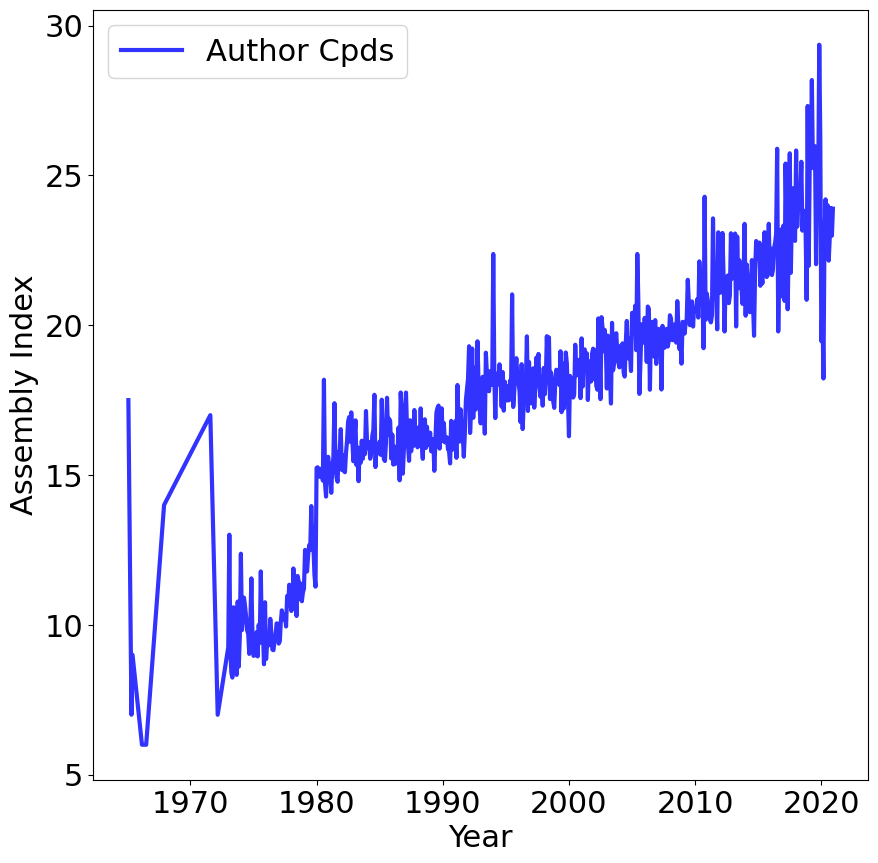

In [48]:
#Assembly values with standard deviation

import matplotlib.ticker as plticker


plt.figure(figsize=(10,10))

plt.plot(MA_df_months["date"], MA_df_months["avg"], color="blue",
            linewidth=3, markersize=10, alpha=0.8, label="Author Cpds")

plt.legend()
plt.xlabel("Year")
plt.ylabel("Assembly Index")

Text(0, 0.5, 'Assembly Index')

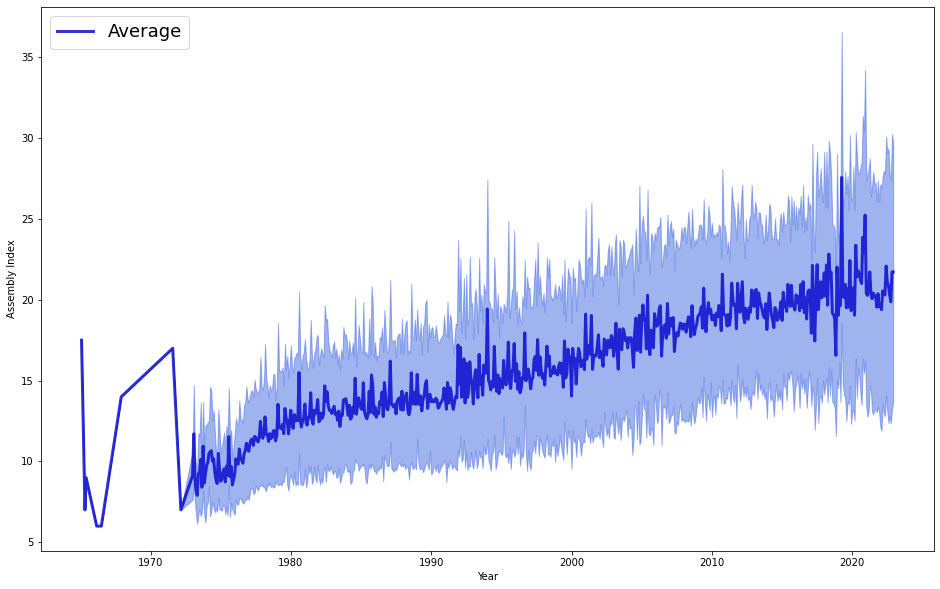

In [64]:
#Assembly values with standard deviation

import matplotlib.ticker as plticker


plt.figure(figsize=(16,10))

plt.plot(MA_df_months["date"], MA_df_months["avg"], color="mediumblue",
            linewidth=3, markersize=10, alpha=0.8, label="Average")

plt.fill_between(MA_df_months["date"], MA_df_months["avg"] + MA_df_months["iqr"]/2, 
                MA_df_months["avg"] - MA_df_months["iqr"]/2, alpha=0.5, color="royalblue")

plt.legend(loc="upper left", prop={"size":"18"})
plt.xlabel("Year")
plt.ylabel("Assembly Index")

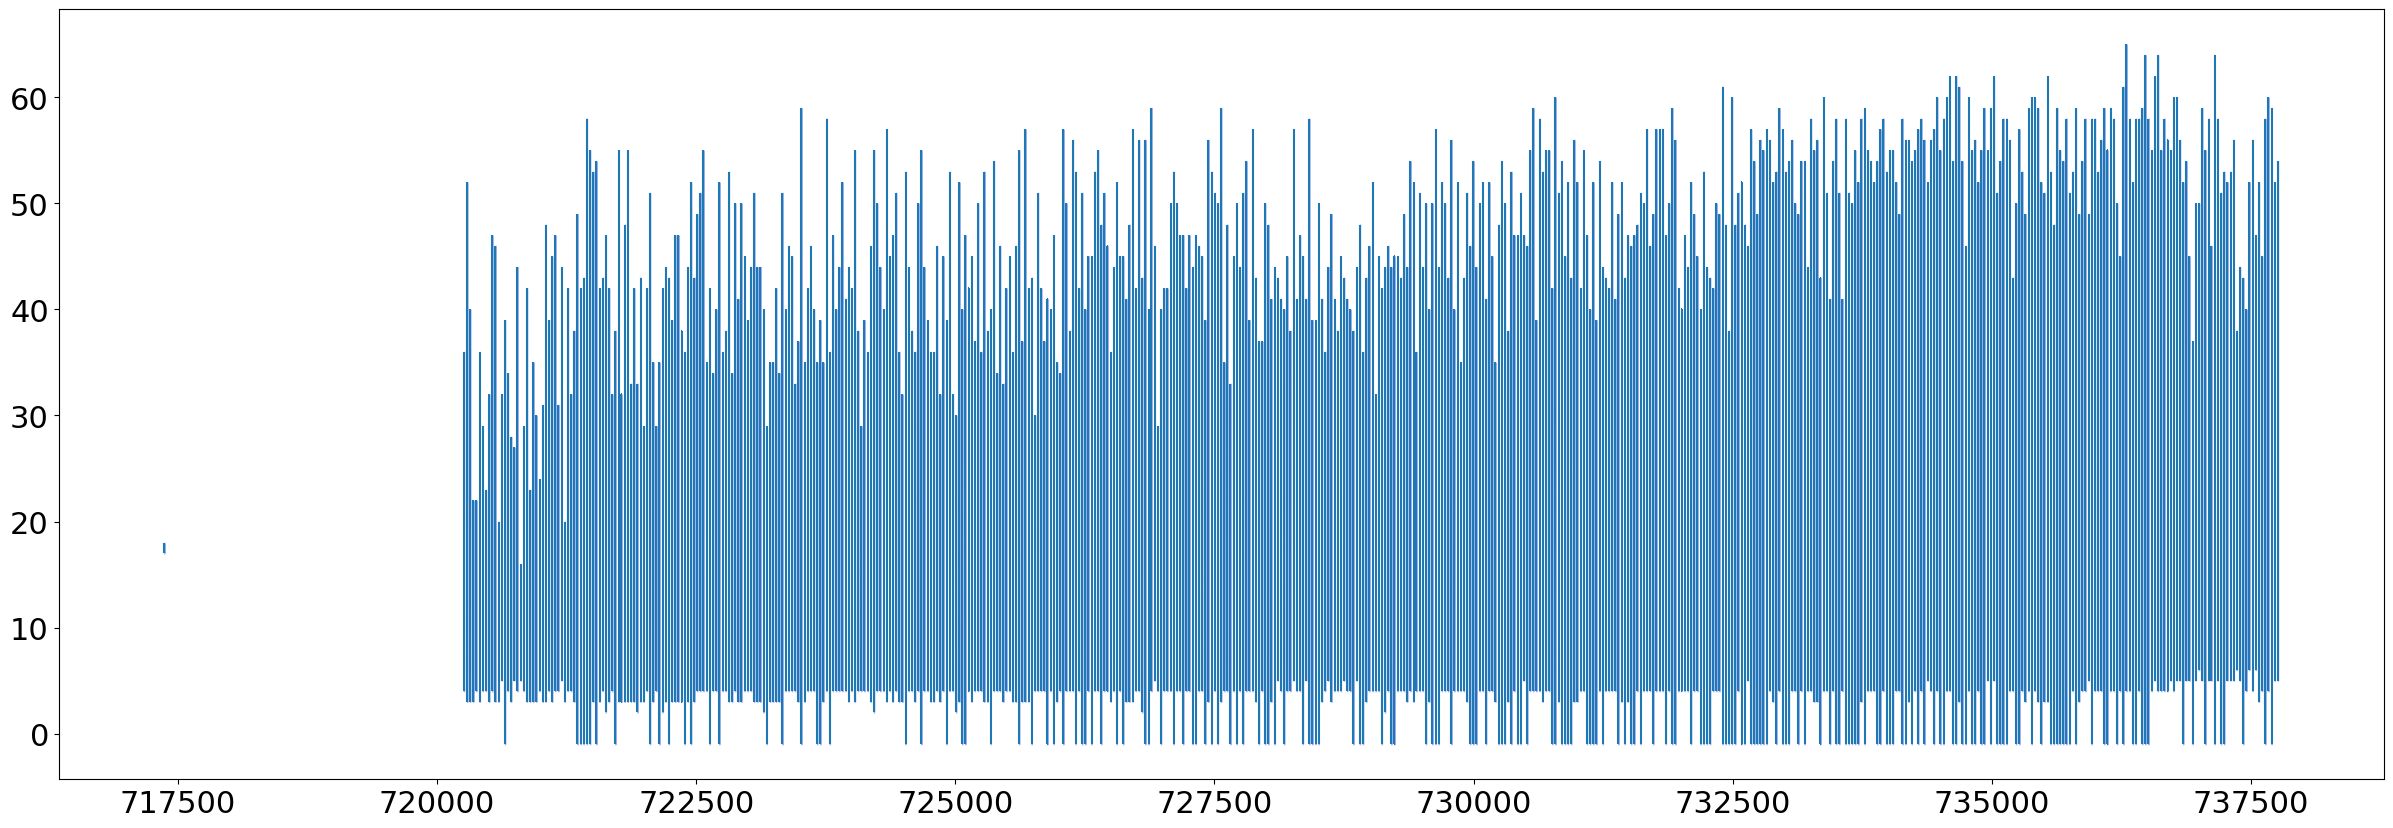

In [64]:
#violin plots - difficult to parse based on amount of months in dataset (maybe coarse-grain to years?)

fig, ax = plt.subplots(figsize=(30,10))

violins = ax.violinplot(MA_df_months["MAs"], positions=MA_df_months["date_ordinal"])

c = "royalblue"
c_body = "skyblue"

# Color all CHNOPS violins
for pc in violins['bodies']:
    pc.set_facecolor(c)
    pc.set_edgecolor(c)
    pc.set_alpha(0.5)

#### Distribution of MAs over time

For Dani - does distribution of MAs change over time? This may be evidence of selection

In [50]:
early_df = MA_df_months[MA_df_months["month"] < "1980"]

early_MAs = [MA for sublist in list(MA_df_months["MAs"]) for MA in sublist]

(-10.0, 60.0)

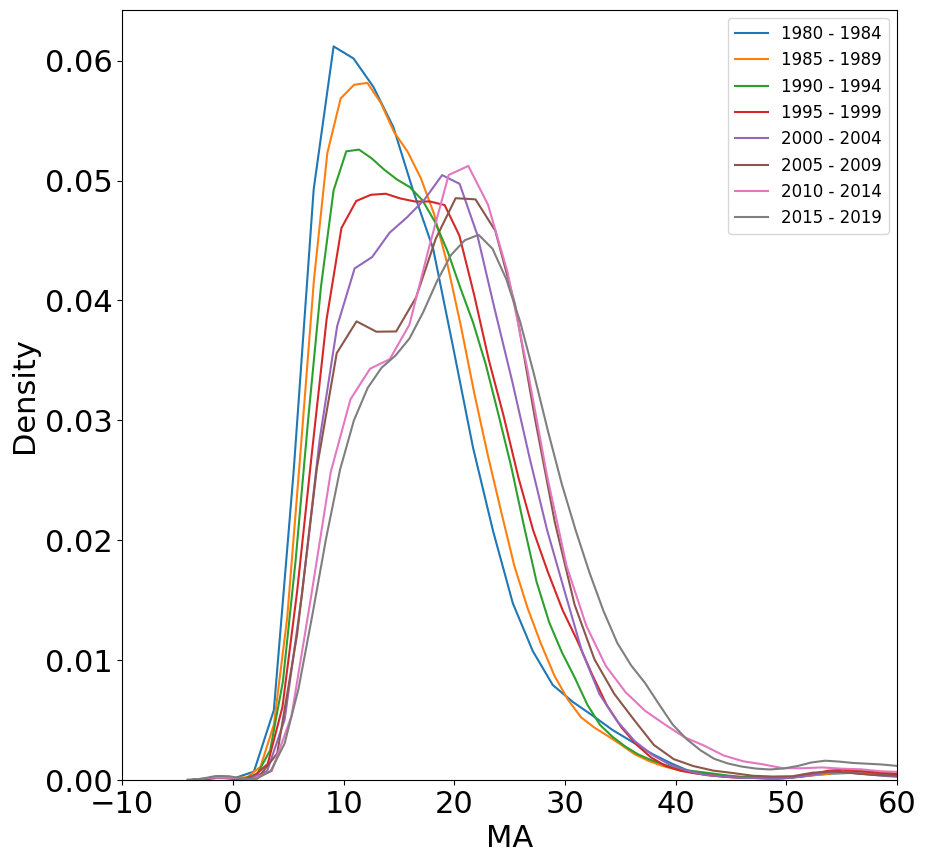

In [12]:
# sns.kdeplot(early_MAs, label = "Pre 1980")
plt.figure(figsize=(10,10))


for times in [("1980", "1984"), ("1985", "1989"), ("1990", "1994"), ("1995", "1999"), ("2000", "2004"), 
              ("2005", "2009"), ("2010", "2014"), ("2015","2019")]:
    sub_df = MA_df_months[MA_df_months["month"] > times[0]]
    sub_df = sub_df[sub_df["month"] <= times[1]]
    sub_MAs = [MA for sublist in list(sub_df["MAs"]) for MA in sublist]

    sns.kdeplot(sub_MAs, label=str(times[0]) + " - " + str(times[1]))

plt.legend(prop={"size":12})
plt.xlabel("MA")

plt.xlim(-10, 60)

Text(0.5, 0, 'MA')

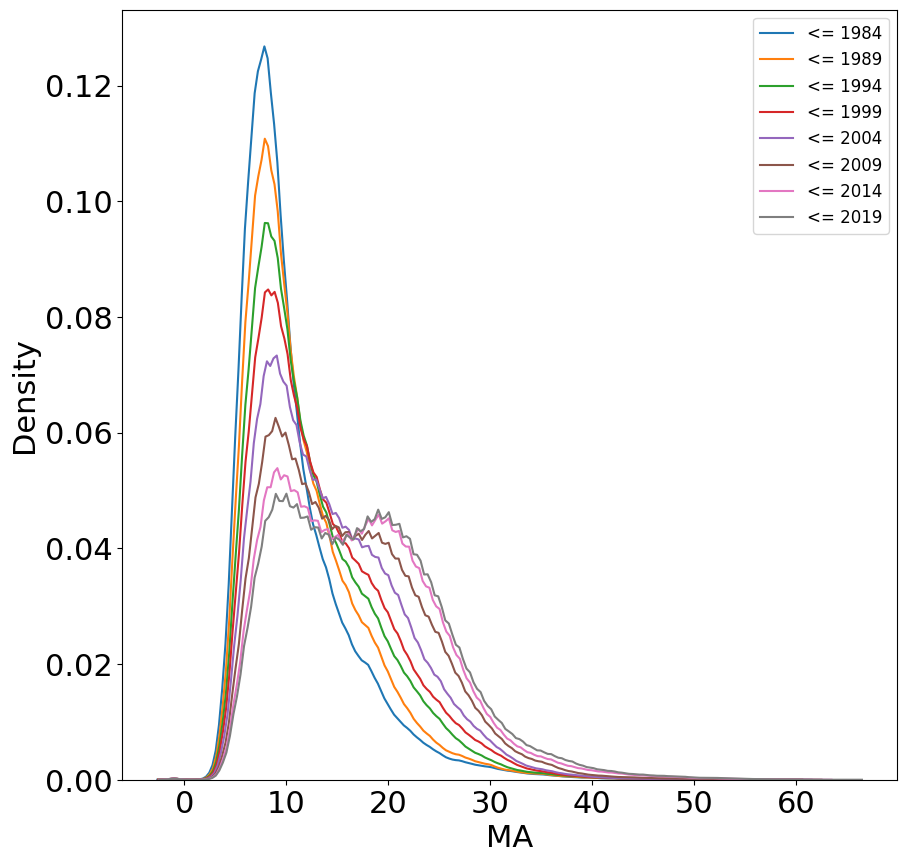

In [51]:
plt.figure(figsize=(10,10))

for times in [("1980", "1984"), ("1985", "1989"), ("1990", "1994"), ("1995", "1999"), ("2000", "2004"), 
              ("2005", "2009"), ("2010", "2014"), ("2015","2019")]:    
    sub_df = MA_df_months[MA_df_months["month"] <= times[1]]
    #sub_df = sub_df[sub_df["month"] <= times[1]]
    sub_MAs = [MA for sublist in list(sub_df["MAs"]) for MA in sublist]

    sns.kdeplot(sub_MAs, label="<= " + str(times[1]))

plt.legend(prop={"size":12})
plt.xlabel("MA")

Testing selection KDE graph on only completed MAs

In [33]:
MA_df_completed["month"] = MA_df_completed["earliest_date"].progress_apply(get_month)
MA_df_completed_months = MA_df_completed.groupby("month")["MA_assemblyGo"].apply(list).reset_index(name="MAs")

100%|██████████| 523270/523270 [00:19<00:00, 27537.79it/s] 
/Users/John/anaconda2/envs/my-rdkit-env/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


(-10.0, 60.0)

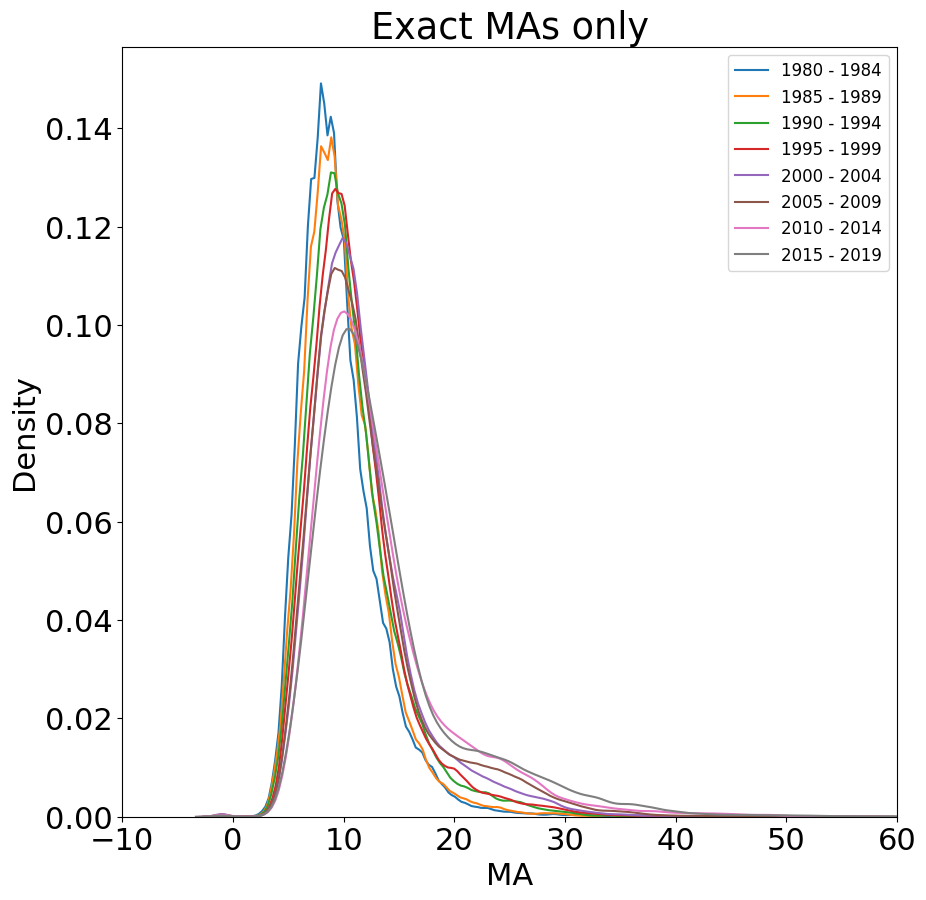

In [35]:
# sns.kdeplot(early_MAs, label = "Pre 1980")
plt.figure(figsize=(10,10))


for times in [("1980", "1984"), ("1985", "1989"), ("1990", "1994"), ("1995", "1999"), ("2000", "2004"), 
              ("2005", "2009"), ("2010", "2014"), ("2015","2019")]:
    sub_df = MA_df_completed_months[MA_df_completed_months["month"] > times[0]]
    sub_df = sub_df[sub_df["month"] <= times[1]]
    sub_MAs = [MA for sublist in list(sub_df["MAs"]) for MA in sublist]

    sns.kdeplot(sub_MAs, label=str(times[0]) + " - " + str(times[1]))

plt.legend(prop={"size":12})
plt.xlabel("MA")
plt.title("Exact MAs only")

plt.xlim(-10, 60)

In [53]:
MA_df_months.to_csv("Data/AssemblyValues/MA_df_months.csv")

### Molecular Weight 

Graph molecular weight of cpds over time

In [13]:
## Load entire SureChemBL dataframe

surechembl_df = pickle.load(file=open("/Volumes/Macintosh HD 4/SureChemBL/Cpd_Data/SureChemBL_allCpds.p", "rb"))

: 

In [ ]:
filtered_sc_df = surechembl_df[surechembl_df["SureChEMBL_ID"].isin(list(MA_df["label"]))]

print(filtered_sc_df)

            SureChEMBL_ID                                             SMILES  \
0                SCHEMBL4                   C[C@H](CS)C(=O)N1CCC[C@H]1C(O)=O   
1                SCHEMBL9  O=C(O)\C=C/C(=O)O.CCOC(=O)[C@H](CCC1=CC=CC=C1)...   
2               SCHEMBL10  OC(=O)C=CC(O)=O.CCOC(=O)[C@H](CCC1=CC=CC=C1)N[...   
6               SCHEMBL18  CCOC(=O)[C@H](CCC1=CC=CC=C1)N[C@@H](C)C(=O)N1C...   
8               SCHEMBL23  CNCC(=O)N[C@@H](CCCNC(N)=N)C(=O)N[C@@H](C(C)C)...   
...                   ...                                                ...   
21640375  SCHEMBL23603834                       C[C@@H](O)C(CO)OC[C@@H](O)CO   
21641139  SCHEMBL23604631                                 CC(C)C(C)(C)C(O)=N   
21646291  SCHEMBL23610245                                 N\C(CN1CCCCC1)=N\O   
21661948  SCHEMBL23627331  COC1=NN(\C(O)=N\S(=O)(=O)C2=CC=CC=C2OC(F)(F)F)...   
21664454  SCHEMBL23630220         CN=C(O)C1=C(I)C(N=C(C)O)=C(I)C(C(O)=O)=C1I   

                                       

In [ ]:
del surechembl_df

In [ ]:
def get_MW(inchi):
    try:
        mol = Chem.MolFromInchi(inchi)
        return Descriptors.ExactMolWt(mol)
    except:
        return -1
    

In [62]:
tqdm.pandas()

filtered_sc_df["mw"] = filtered_sc_df["InChI"].progress_apply(get_MW)

100%|██████████| 2034440/2034440 [39:53<00:00, 849.83it/s] 


In [63]:
## Save molecular weight df
filtered_sc_df.to_csv("Data/molecular_weight_chemblCpds.csv")

In [11]:
filtered_sc_df = pd.read_csv("Data/molecular_weight_chemblCpds.csv")

In [12]:
## Merge MA_df with molecular weight, then perform same time series analysis as MA
print(MA_df)
print(filtered_sc_df)

         Unnamed: 0  Unnamed: 0.1            label  MA_assemblyGo        time  \
0                 0             0        SCHEMBL10           21.0  120.662484   
1                 1             1  SCHEMBL10000006           14.0  119.968879   
2                 2             2  SCHEMBL10000077           19.0  119.948782   
3                 3             3  SCHEMBL10000078           10.0   28.798358   
4                 4             4  SCHEMBL10000080            6.0    0.351274   
...             ...           ...              ...            ...         ...   
2033829      473226         13048  SCHEMBL21609983           25.0         NaN   
2033830      473227         13049  SCHEMBL21610001            7.0         NaN   
2033831      473228         13050  SCHEMBL21610027          133.0         NaN   
2033832      473229         13051  SCHEMBL21610072            8.0         NaN   
2033833      473231         13053  SCHEMBL21610114           27.0         NaN   

        earliest_date  date

In [13]:
mw_df = pd.merge(left=MA_df, right=filtered_sc_df, left_on="label", right_on="SureChEMBL_ID", how="outer")

print(mw_df)

mw_df.to_csv("Data/AssemblyValues/ALLSAMPLEDcpds_AssemblyGo_MW.csv")

         Unnamed: 0_x  Unnamed: 0.1            label  MA_assemblyGo  \
0                   0             0        SCHEMBL10           21.0   
1                   1             1  SCHEMBL10000006           14.0   
2                   2             2  SCHEMBL10000077           19.0   
3                   3             3  SCHEMBL10000078           10.0   
4                   4             4  SCHEMBL10000080            6.0   
...               ...           ...              ...            ...   
2034436        473226         13048  SCHEMBL21609983           25.0   
2034437        473227         13049  SCHEMBL21610001            7.0   
2034438        473228         13050  SCHEMBL21610027          133.0   
2034439        473229         13051  SCHEMBL21610072            8.0   
2034440        473231         13053  SCHEMBL21610114           27.0   

               time earliest_date  date_ordinal    month  Unnamed: 0_y  \
0        120.662484    1980-06-25        722991  1980-06           2.0   

Merging all molecular weights together!

In [37]:
mw_df = pd.read_csv("Data/AssemblyValues/ALLSAMPLEDcpds_AssemblyGo_MW.csv")

In [38]:
full_cpd_df = pd.read_csv("Data/AssemblyValues/fullCpds_AssemblyValues.csv")
new_cpd_df = pd.read_csv("Data/AssemblyValues/newCpds_AssemblyValues.csv")

In [39]:
print(mw_df)

         Unnamed: 0  Unnamed: 0_x  Unnamed: 0.1            label  \
0                 0             0             0        SCHEMBL10   
1                 1             1             1  SCHEMBL10000006   
2                 2             2             2  SCHEMBL10000077   
3                 3             3             3  SCHEMBL10000078   
4                 4             4             4  SCHEMBL10000080   
...             ...           ...           ...              ...   
2034436     2034436        473226         13048  SCHEMBL21609983   
2034437     2034437        473227         13049  SCHEMBL21610001   
2034438     2034438        473228         13050  SCHEMBL21610027   
2034439     2034439        473229         13051  SCHEMBL21610072   
2034440     2034440        473231         13053  SCHEMBL21610114   

         MA_assemblyGo        time earliest_date  date_ordinal    month  \
0                 21.0  120.662484    1980-06-25        722991  1980-06   
1                 14.0  119.96887

In [40]:
print(full_cpd_df)

        Unnamed: 0    month  \
0                0  1980-01   
1                1  1980-01   
2                2  1980-01   
3                3  1980-01   
4                4  1980-01   
...            ...      ...   
468286       11922  2019-12   
468287       11923  2019-12   
468288       11924  2019-12   
468289       11925  2019-12   
468290       11926  2019-12   

                                                    inchi  ai           mw  
0       InChI=1S/C18H36O2.Mg/c1-2-3-4-5-6-7-8-9-10-11-...   8   308.256572  
1       InChI=1S/C50H71N13O12/c1-5-28(4)41(47(72)59-36...  77  1045.534515  
2       InChI=1S/C11H18N2O3.Na/c1-4-6-7(3)11(5-2)8(14)...  13   248.113687  
3       InChI=1S/C10H11ClO/c1-8(12)2-3-9-4-6-10(11)7-5...   8   182.049843  
4       InChI=1S/C14H11Cl2NO2/c15-10-5-3-6-11(16)14(10...  14   295.016684  
...                                                   ...  ..          ...  
468286  InChI=1S/C17H18N4O2S/c1-17(2,3)23-16(22)10-7-2...  25   342.115047  
468287  InC

In [41]:
mw_df_full = pd.concat([mw_df, full_cpd_df.rename(columns={"inchi" : "InChI", "ai" : "MA_assemblyGo"})], ignore_index=True)
print(mw_df_full)

         Unnamed: 0  Unnamed: 0_x  Unnamed: 0.1            label  \
0                 0           0.0           0.0        SCHEMBL10   
1                 1           1.0           1.0  SCHEMBL10000006   
2                 2           2.0           2.0  SCHEMBL10000077   
3                 3           3.0           3.0  SCHEMBL10000078   
4                 4           4.0           4.0  SCHEMBL10000080   
...             ...           ...           ...              ...   
2502727       11922           NaN           NaN              NaN   
2502728       11923           NaN           NaN              NaN   
2502729       11924           NaN           NaN              NaN   
2502730       11925           NaN           NaN              NaN   
2502731       11926           NaN           NaN              NaN   

         MA_assemblyGo        time earliest_date  date_ordinal    month  \
0                 21.0  120.662484    1980-06-25      722991.0  1980-06   
1                 14.0  119.96887

In [42]:
mw_df_full_new = pd.concat([mw_df_full, new_cpd_df.rename(columns={"inchi" : "InChI", "ai" : "MA_assemblyGo"})], ignore_index=True)
print(mw_df_full_new)

         Unnamed: 0  Unnamed: 0_x  Unnamed: 0.1            label  \
0                 0           0.0           0.0        SCHEMBL10   
1                 1           1.0           1.0  SCHEMBL10000006   
2                 2           2.0           2.0  SCHEMBL10000077   
3                 3           3.0           3.0  SCHEMBL10000078   
4                 4           4.0           4.0  SCHEMBL10000080   
...             ...           ...           ...              ...   
2972836       12309           NaN           NaN              NaN   
2972837       12310           NaN           NaN              NaN   
2972838       12311           NaN           NaN              NaN   
2972839       12312           NaN           NaN              NaN   
2972840       12313           NaN           NaN              NaN   

         MA_assemblyGo        time earliest_date  date_ordinal    month  \
0                 21.0  120.662484    1980-06-25      722991.0  1980-06   
1                 14.0  119.96887

In [43]:
mw_df = mw_df_full_new

In [52]:
print(mw_df)

         Unnamed: 0  Unnamed: 0_x  Unnamed: 0.1            label  \
0                 0           0.0           0.0        SCHEMBL10   
1                 1           1.0           1.0  SCHEMBL10000006   
2                 2           2.0           2.0  SCHEMBL10000077   
3                 3           3.0           3.0  SCHEMBL10000078   
4                 4           4.0           4.0  SCHEMBL10000080   
...             ...           ...           ...              ...   
2972836       12309           NaN           NaN              NaN   
2972837       12310           NaN           NaN              NaN   
2972838       12311           NaN           NaN              NaN   
2972839       12312           NaN           NaN              NaN   
2972840       12313           NaN           NaN              NaN   

         MA_assemblyGo        time earliest_date  date_ordinal    month  \
0                 21.0  120.662484    1980-06-25      722991.0  1980-06   
1                 14.0  119.96887

In [15]:
## Get labels for each month, for fragment analysis

ID_df_months = mw_df.groupby("month")["label"].apply(list).reset_index(name="IDs")

print(ID_df_months)

ID_df_months.to_csv("Data/ID_months.csv")

       month                                                IDs
0    1965-02                     [SCHEMBL180193, SCHEMBL180194]
1    1965-05                                      [SCHEMBL8137]
2    1965-06                                    [SCHEMBL211612]
3    1966-03                                      [SCHEMBL9114]
4    1966-07                                     [SCHEMBL37831]
..       ...                                                ...
580  2020-09  [SCHEMBL22364283, SCHEMBL22364284, SCHEMBL2237...
581  2020-10  [SCHEMBL17907879, SCHEMBL17907880, SCHEMBL1906...
582  2020-11  [SCHEMBL22617512, SCHEMBL22617513, SCHEMBL2261...
583  2020-12  [SCHEMBL11164959, SCHEMBL20847802, SCHEMBL2084...
584      NaT  [nan, SCHEMBL23141136, SCHEMBL23630220, SCHEMB...

[585 rows x 2 columns]


In [44]:
MW_df_months = mw_df.groupby("month")["mw"].apply(list).reset_index(name="MWs")

print(MW_df_months)

       month                                                MWs
0    1965-02             [416.3290452679999, 416.3290452679999]
1    1965-05                                    [144.068748256]
2    1965-06                                    [144.068748256]
3    1966-03                                    [199.045570288]
4    1966-07                                    [117.057849224]
..       ...                                                ...
580  2020-09  [462.03967232000014, 398.05058590000016, 402.0...
581  2020-10  [228.13615912, 276.13615912, 219.104799416, 21...
582  2020-11  [239.97602608, 268.007326208, 212.131348512000...
583  2020-12  [240.099773612, 909.4097494760001, 297.0848518...
584      NaT  [nan, 204.08987762400002, 613.769650768, 160.0...

[585 rows x 2 columns]


In [49]:
tqdm.pandas() 

MW_df_months["avg"] = MW_df_months["MWs"].progress_apply(get_mean)
MW_df_months["std"] = MW_df_months["MWs"].progress_apply(get_std)
MW_df_months["iqr"] = MW_df_months["MWs"].progress_apply(get_IQR)

#Change dates to ordinals
MW_df_months["date"] = pd.to_datetime(MW_df_months["month"])
#MW_df_months["date_ordinal"] = MW_df_months["date"].map(dt.toordinal)

100%|████████████████████████████████████████| 585/585 [00:01<00:00, 579.14it/s]


Text(0, 0.5, 'Molecular Weight (Daltons)')

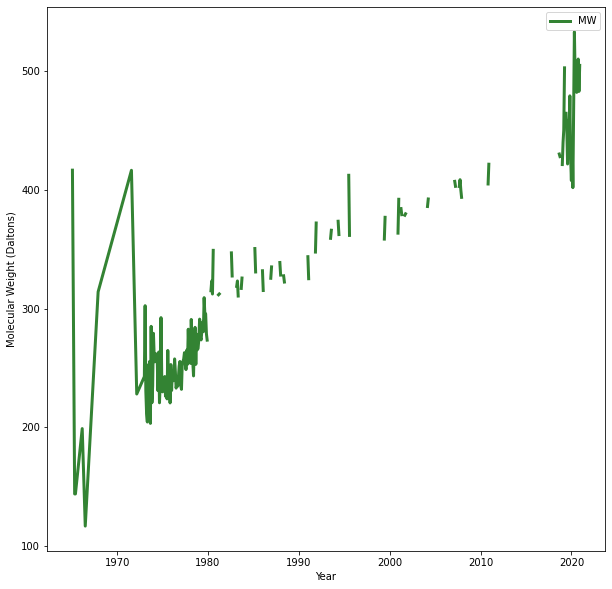

In [50]:
#Assembly values with standard deviation

import matplotlib.ticker as plticker


plt.figure(figsize=(10,10))

plt.plot(MW_df_months["date"], MW_df_months["avg"], color="darkgreen",
            linewidth=3, markersize=10, alpha=0.8, label="MW")

plt.legend()
plt.xlabel("Year")
plt.ylabel("Molecular Weight (Daltons)")

Text(0, 0.5, 'Molecular Weight (Daltons)')

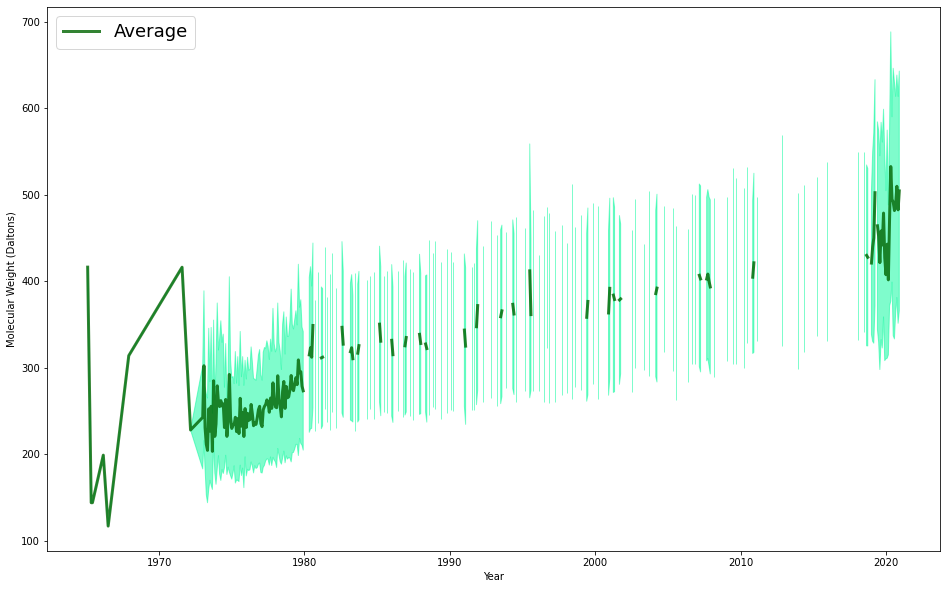

In [51]:
#Assembly values with standard deviation

import matplotlib.ticker as plticker


plt.figure(figsize=(16,10))

plt.plot(MW_df_months["date"], MW_df_months["avg"], color="darkgreen",
            linewidth=3, markersize=10, alpha=0.8, label="Average")

plt.fill_between(MW_df_months["date"], MW_df_months["avg"] + MW_df_months["iqr"]/2, 
                MW_df_months["avg"] - MW_df_months["iqr"]/2, alpha=0.5, color="mediumspringgreen",
                label="")

plt.legend(loc="upper left", prop={"size":"18"})
plt.xlabel("Year")
plt.ylabel("Molecular Weight (Daltons)")

### Combined MA/MW/(eventually) fragment figure

Text(0, 0.5, 'Molecular Weight (Daltons)')

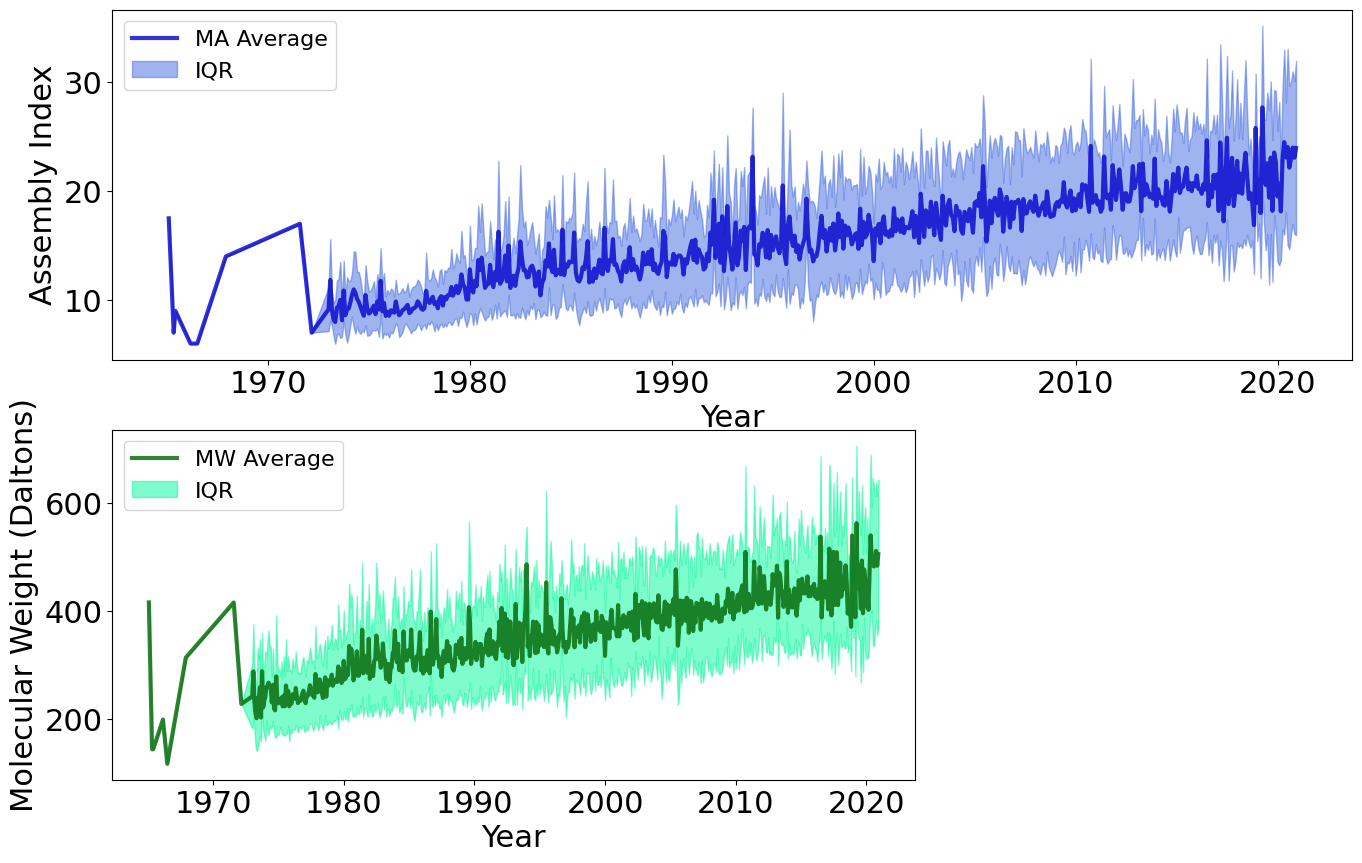

In [139]:
import matplotlib.gridspec as gridspec

gs = gridspec.GridSpec(2,3)

fig = plt.figure(figsize=(16,10))

## MA Figure
ax1 = fig.add_subplot(gs[0,:])
ax1.plot(MA_df_months["date"], MA_df_months["avg"], color="mediumblue",
            linewidth=3, markersize=10, alpha=0.8, label="MA Average")

ax1.fill_between(MA_df_months["date"], MA_df_months["avg"] + MA_df_months["iqr"]/2, 
                MA_df_months["avg"] - MA_df_months["iqr"]/2, alpha=0.5, color="royalblue",
                label="IQR")

ax1.legend(loc="upper left", prop={"size":"16"})
ax1.set_xlabel("Year")
ax1.set_ylabel("Assembly Index")


## MW Figure
ax2 = fig.add_subplot(gs[1,0:2])
ax2.plot(MW_df_months["date"], MW_df_months["avg"], color="darkgreen",
            linewidth=3, markersize=10, alpha=0.8, label="MW Average")

ax2.fill_between(MW_df_months["date"], MW_df_months["avg"] + MW_df_months["iqr"]/2, 
                MW_df_months["avg"] - MW_df_months["iqr"]/2, alpha=0.5, color="mediumspringgreen",
                label="IQR")

ax2.legend(loc="upper left", prop={"size":"16"})
ax2.set_xlabel("Year")
ax2.set_ylabel("Molecular Weight (Daltons)")



## Assembly/MA correlation

Goal is to find 1) linear regression, and 2) logistic regression of MW vs MA plots

In [14]:
print(mw_df)

         Unnamed: 0_x  Unnamed: 0.1            label  MA_assemblyGo  \
0                   0             0        SCHEMBL10           21.0   
1                   1             1  SCHEMBL10000006           14.0   
2                   2             2  SCHEMBL10000077           19.0   
3                   3             3  SCHEMBL10000078           10.0   
4                   4             4  SCHEMBL10000080            6.0   
...               ...           ...              ...            ...   
2034436        473226         13048  SCHEMBL21609983           25.0   
2034437        473227         13049  SCHEMBL21610001            7.0   
2034438        473228         13050  SCHEMBL21610027          133.0   
2034439        473229         13051  SCHEMBL21610072            8.0   
2034440        473231         13053  SCHEMBL21610114           27.0   

               time earliest_date  date_ordinal    month  Unnamed: 0_y  \
0        120.662484    1980-06-25        722991  1980-06           2.0   

(0.0, 100.0)

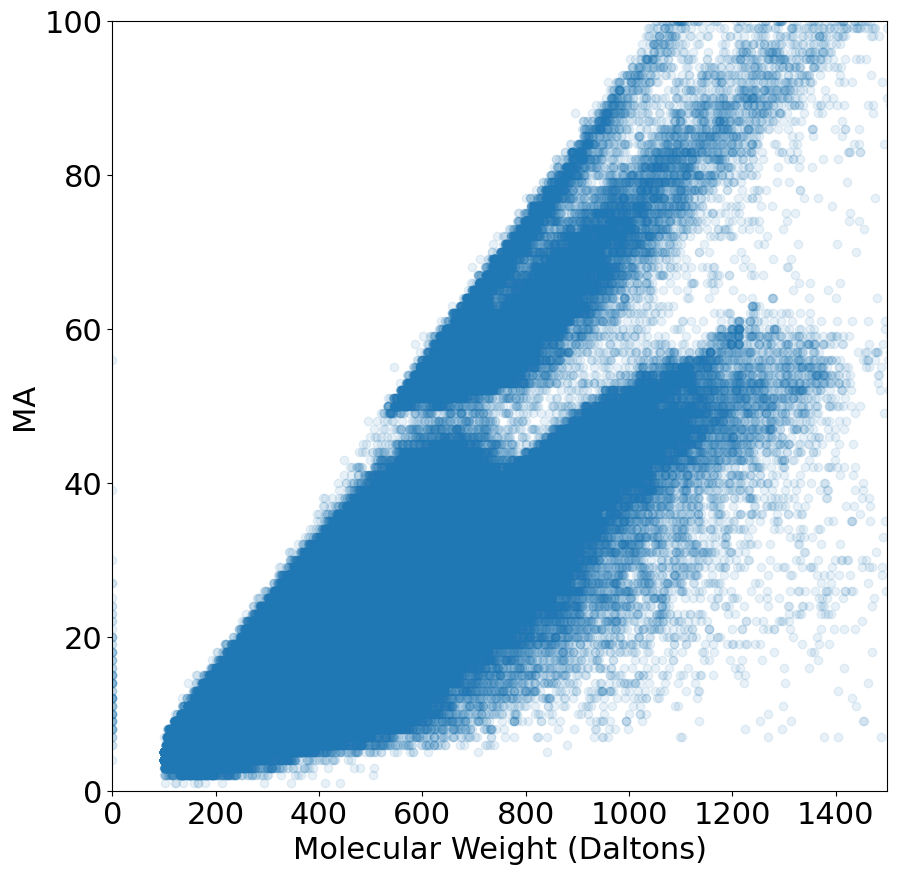

In [38]:
plt.figure(figsize=(10,10))

plt.scatter(mw_df["mw"], mw_df["MA_assemblyGo"], alpha=0.1)

plt.xlabel("Molecular Weight (Daltons)")
plt.ylabel("MA")

plt.xlim(0,1500)
plt.ylim(0,100)

In [21]:
mw_df_completed = mw_df.query("time < 299 and (time > 121 or time < 118)")

print(list(mw_df_completed["time"])[0:100])

[28.798357658, 0.35127431200000003, 0.005756351999999999, 1.41864268, 0.718970757, 0.17606567899999995, 0.58626871, 4.010830751, 0.233398289, 25.997095563000002, 95.109789031, 111.68318077, 1.271380065, 3.224637706, 0.07028456, 0.023217178, 5.535580512999999, 7.24460663, 0.022659568, 0.326210449, 0.621169155, 13.380052062, 26.955227201, 21.930396569000006, 1.100337403, 4.578143277, 0.668886266, 1.919154833, 6.055421757, 115.235026415, 4.115313797, 0.18088512, 121.275106369, 96.461100032, 23.242798199, 0.582226016, 12.854264143, 12.655637475, 32.523105989, 1.2386883690000001, 1.325992515, 0.001712155, 121.00507276200001, 121.172771542, 8.369201955, 121.354730844, 13.936755144000001, 1.262559263, 28.987069737, 52.313647315, 0.154441565, 2.143685076, 17.886357574, 0.099540659, 0.43874349, 1.043481851, 0.263570574, 0.006131461, 0.001342798, 18.869376209000002, 83.26071844399999, 6.998609292, 0.002857963, 1.772013088, 123.502697349, 2.617306491, 0.022426652, 0.567594512, 0.425527088, 0.2493

In [37]:
#Basic linear regression & statistics over MA/MW distribution

MA_slope, MA_intercept = np.polyfit(mw_df_completed["mw"], mw_df_completed["MA_assemblyGo"], 1)

##Calculate Spearman correlation (not assuming normality)
MA_spearman_corr = stats.spearmanr(mw_df_completed["mw"], mw_df_completed["MA_assemblyGo"])

print("Slope:", MA_slope) 
print("Intercept:", MA_intercept)
print(MA_spearman_corr)

Slope: 0.041274655239362044
Intercept: 0.4845856958174196
SpearmanrResult(correlation=0.7824007559808961, pvalue=0.0)


(0.0, 50.0)

<Figure size 1000x1000 with 0 Axes>

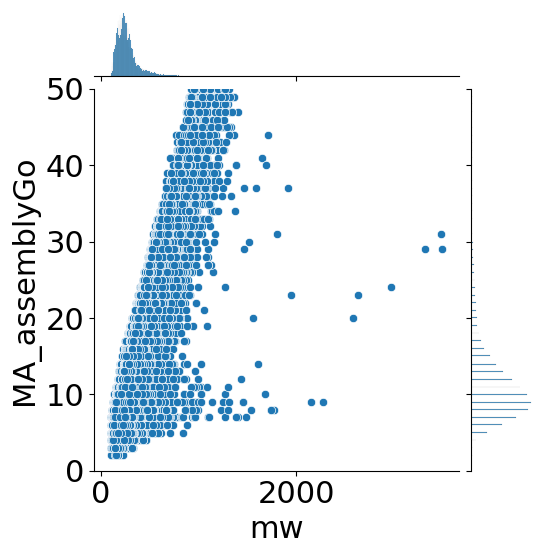

In [23]:
plt.figure(figsize=(10,10))

# plt.scatter(mw_df_completed["mw"], mw_df_completed["MA_assemblyGo"], alpha=0.1)
sns.jointplot(x=mw_df_completed["mw"], y=mw_df_completed["MA_assemblyGo"])

plt.xlabel("Molecular Weight (Daltons)")
plt.ylabel("MA")

plt.ylim(0,50)

(0.0, 50.0)

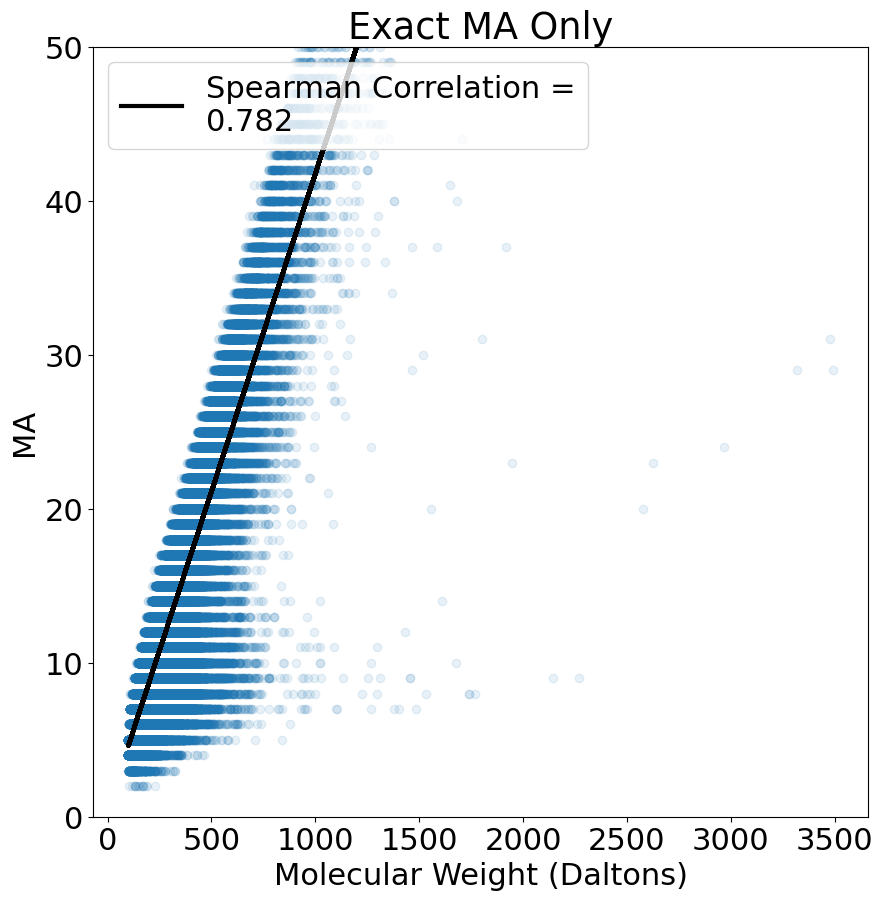

In [38]:
plt.figure(figsize=(10,10))

plt.scatter(mw_df_completed["mw"], mw_df_completed["MA_assemblyGo"], alpha=0.1)
plt.plot(mw_df_completed["mw"], MA_slope * mw_df_completed["mw"] + MA_intercept, color="k", linewidth=3,
        label="Spearman Correlation =\n" + str(round(MA_spearman_corr[0], 3)))

plt.xlabel("Molecular Weight (Daltons)")
plt.ylabel("MA")
plt.legend(loc="upper left")
plt.title("Exact MA Only")

plt.ylim(0,50)

In [54]:
print(mw_df_completed[mw_df_completed["MA_assemblyGo"] > 40].to_csv("TEST.csv"))

None


### MA by Bonds

Total number of bonds (first)

In [46]:
def get_bonds(inchi):

    try:
        m = Chem.MolFromInchi(inchi)
        return len(m.GetBonds())
    except:
        return None

In [26]:
## More testing
inchi = "InChI=1S/C9H8O4/c10-7-3-1-6(2-4-7)5-8(11)9(12)13/h1-4,10H,5H2,(H,12,13)"

m = Chem.MolFromInchi(inchi)
print(set([x.GetBondType() for x in m.GetBonds()]))

{rdkit.Chem.rdchem.BondType.SINGLE, rdkit.Chem.rdchem.BondType.DOUBLE, rdkit.Chem.rdchem.BondType.AROMATIC}


In [27]:
def get_unique_bonds(inchi):

    m = Chem.MolFromInchi(inchi)
    return len(m.GetBonds())

In [28]:
tqdm.pandas()

mw_df_completed["bonds"] = mw_df_completed["InChI"].progress_apply(get_bonds)

100%|██████████| 523337/523337 [07:19<00:00, 1189.92it/s]
/Users/John/anaconda2/envs/my-rdkit-env/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [52]:
#Basic linear regression & statistics over MA/bonds distribution

MA_slope, MA_intercept = np.polyfit(mw_df["bonds"], mw_df["MA_assemblyGo"], 1)

##Calculate Spearman correlation (not assuming normality)
MA_spearman_corr = stats.spearmanr(mw_df["bonds"], mw_df["MA_assemblyGo"])

print("Slope:", MA_slope) 
print("Intercept:", MA_intercept)
print(MA_spearman_corr)

LinAlgError: SVD did not converge in Linear Least Squares

(0.0, 50.0)

<Figure size 1000x1000 with 0 Axes>

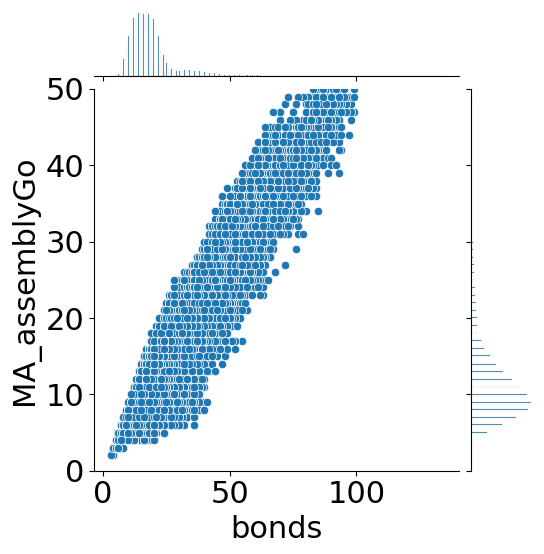

In [30]:
plt.figure(figsize=(10,10))

# plt.scatter(mw_df_completed["mw"], mw_df_completed["MA_assemblyGo"], alpha=0.1)
sns.jointplot(x=mw_df_completed["bonds"], y=mw_df_completed["MA_assemblyGo"])

plt.xlabel("Total Bonds")
plt.ylabel("MA")

plt.ylim(0,50)

(0.0, 75.0)

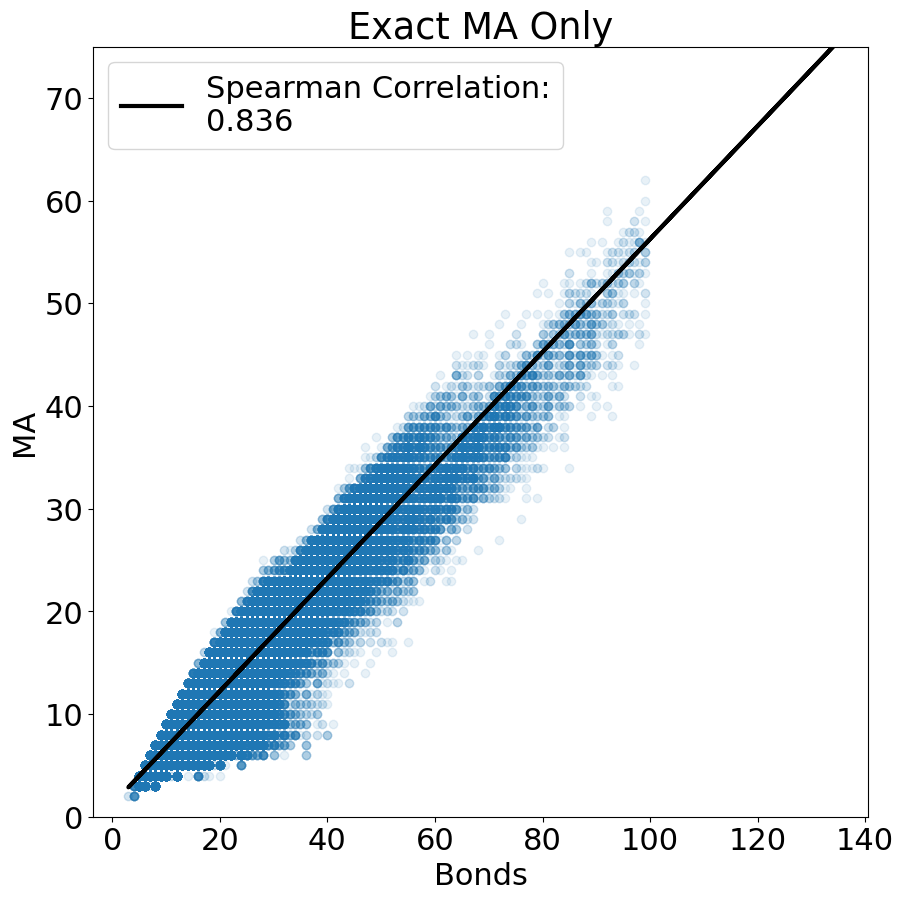

In [48]:
plt.figure(figsize=(10,10))

plt.scatter(mw_df_completed["bonds"], mw_df_completed["MA_assemblyGo"], alpha=0.1)
plt.plot(mw_df_completed["bonds"], MA_slope * mw_df_completed["bonds"] + MA_intercept, color="k", linewidth=3, 
        label="Spearman Correlation:\n" + str(round(MA_spearman_corr[0], 3)))

plt.xlabel("Bonds")
plt.ylabel("MA")
plt.legend()
plt.title("Exact MA Only")

plt.ylim(0,75)

In [47]:
tqdm.pandas()

mw_df["bonds"] = mw_df["InChI"].progress_apply(get_bonds)

100%|██████████| 2034441/2034441 [40:29<00:00, 837.55it/s] 


No handles with labels found to put in legend.


Text(0.5, 1.0, 'All MAs')

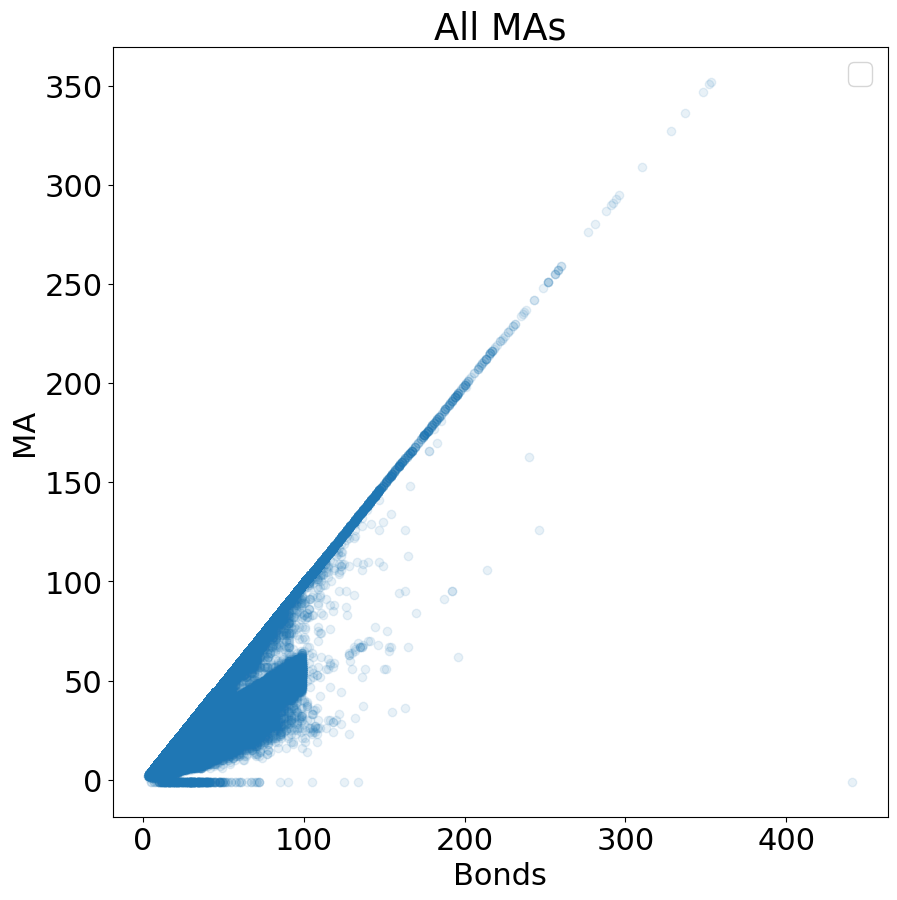

In [53]:
plt.figure(figsize=(10,10))

plt.scatter(mw_df["bonds"], mw_df["MA_assemblyGo"], alpha=0.1)
# plt.plot(mw_df["bonds"], MA_slope * mw_df["bonds"] + MA_intercept, color="k", linewidth=3, 
#         label="Spearman Correlation:\n" + str(round(MA_spearman_corr[0], 3)))

plt.xlabel("Bonds")
plt.ylabel("MA")
plt.legend()
plt.title("All MAs")

# plt.ylim(0,50)

## Time series prediction

"Moore's Law of MA" - Lee

In [14]:
MA_df_months = pd.read_csv("Data/AssemblyValues/MA_df_months.csv")
MW_df_months = pd.read_csv("Data/AssemblyValues/MW_df_months.csv")

In [15]:
print(MA_df_months)

     Unnamed: 0    month                                                MAs  \
0             0  1965-02                                       [17.0, 18.0]   
1             1  1965-05                                              [7.0]   
2             2  1965-06                                              [9.0]   
3             3  1966-03                                              [6.0]   
4             4  1966-07                                              [6.0]   
..          ...      ...                                                ...   
580         580  2020-09  [23.0, 21.0, 17.0, 17.0, 8.0, 26.0, 18.0, 12.0...   
581         581  2020-10  [10.0, 10.0, 9.0, 12.0, 19.0, 17.0, 9.0, 11.0,...   
582         582  2020-11  [11.0, 13.0, 8.0, 14.0, 12.0, 11.0, 11.0, 13.0...   
583         583  2020-12  [9.0, 46.0, 14.0, 46.0, 7.0, 47.0, 41.0, 41.0,...   
584         584      NaT  [nan, nan, nan, nan, nan, nan, nan, nan, nan, ...   

           avg        std   iqr        date  date_o

In [16]:
# Number of samples - starting with MA predictions
n = len(MA_df_months)

x = MA_df_months["date"].values.reshape(n, 1)
y = MA_df_months["avg"].values.reshape(n, 1)

# Train-test split (train on 70%)
prop_train = 0.7
n_train = round(prop_train * n)

In [17]:
#Train new values first
x_train = x[:n_train]
y_train = y[:n_train]

x_test = x[n_train:]
y_test = y[n_train:]

### Gaussian Process

Using https://juanitorduz.github.io/gp_ts_pymc3/ for help

In [77]:
#Set up & train prediction model

with pm.Model() as model:
    # Use a squared exponential kernal, default (?) parameters
    l = 10.0
    tau = 2.0
    b = 0.5
    cov = b + tau + pm.gp.cov.ExpQuad(1, l)

    # # Squared exponential didn't work - let's try default linear instead (failed! And takes ~30 minutes)
    # cov = pm.gp.cov.Linear(input_dim=1, c=pm.Normal(name="c_3", mu=1, sigma=2))

    gp = pm.gp.Marginal(cov_func=cov)

    #Noise (if necessary?)
    sigma = pm.HalfNormal(name="sigma", sigma=10)

    #Likelihood
    y_pred = gp.marginal_likelihood("y_pred", X=x_train, y=y_train.flatten(), noise=sigma)

    #Sample
    trace = pm.sample(draws=500, chains=2, tune=500)


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/deprecat/classic.py:215: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  return wrapped_(*args_, **kwargs_)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [sigma]


Sampling 2 chains for 500 tune and 500 draw iterations (1_000 + 1_000 draws total) took 96 seconds.


In [78]:
# Train 
with model:
    x_train_conditional_2 = gp.conditional("x_train_conditional_2", x_train)
    y_train_pred_samples = pm.fast_sample_posterior_predictive(trace, var_names=["x_train_conditional_2"], samples=100)

    x_test_conditional_2 = gp.conditional("x_test_conditional_2", x_test)
    y_test_pred_samples = pm.fast_sample_posterior_predictive(trace, var_names=["x_test_conditional_2"], samples=100)

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/pymc3/distributions/posterior_predictive.py:248: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  warnings.warn(


In [79]:
#Prediction sample statistics
y_train_pred_samples_mean = y_train_pred_samples['x_train_conditional_2'].mean(axis=0)
y_train_pred_samples_std = y_train_pred_samples['x_train_conditional_2'].std(axis=0)
y_train_pred_samples_mean_plus = y_train_pred_samples_mean + 2*y_train_pred_samples_std
y_train_pred_samples_mean_minus = y_train_pred_samples_mean - 2*y_train_pred_samples_std
# Test
y_test_pred_samples_mean = y_test_pred_samples['x_test_conditional_2'].mean(axis=0)
y_test_pred_samples_std = y_test_pred_samples['x_test_conditional_2'].std(axis=0)
y_test_pred_samples_mean_plus = y_test_pred_samples_mean + 2*y_test_pred_samples_std
y_test_pred_samples_mean_minus = y_test_pred_samples_mean - 2*y_test_pred_samples_std


[Text(0.5, 1.0, 'Model Predictions'), Text(0.5, 0, 't'), Text(0, 0.5, '')]

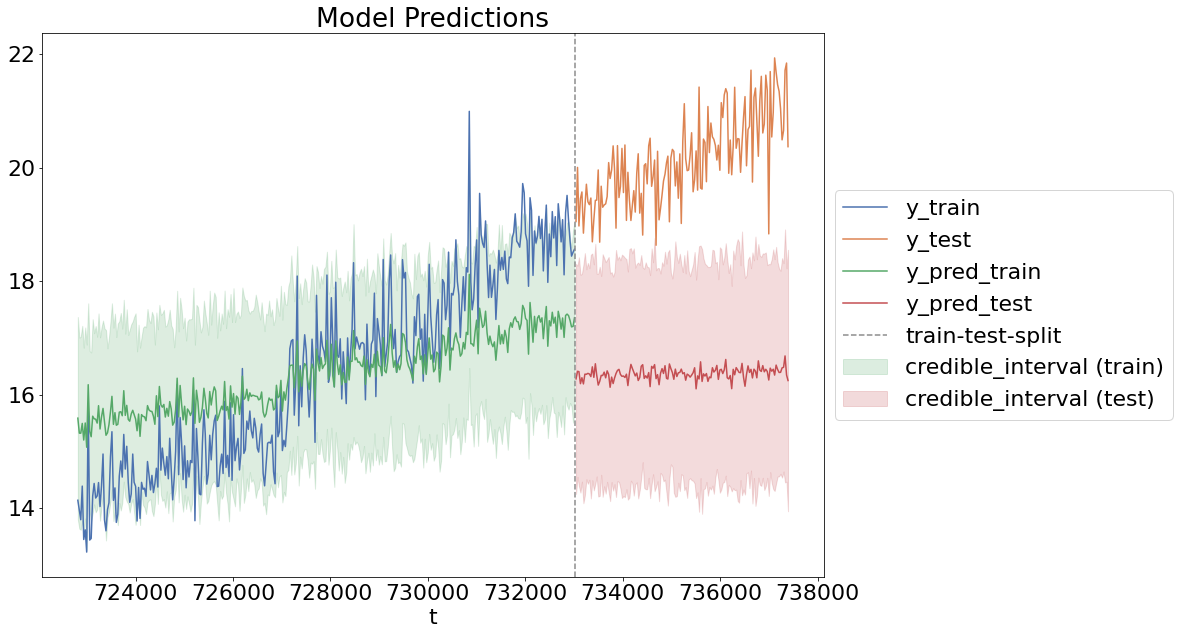

In [80]:
fig, ax = plt.subplots(figsize=(14,10))

sns_c = sns.color_palette(palette='deep')

sns.lineplot(x=x_train.flatten(), y=y_train.flatten(), color=sns_c[0], label='y_train', ax=ax)
sns.lineplot(x=x_test.flatten(), y=y_test.flatten(), color=sns_c[1], label='y_test', ax=ax)
ax.fill_between(
    x=x_train.flatten(), 
    y1=y_train_pred_samples_mean_minus, 
    y2=y_train_pred_samples_mean_plus, 
    color=sns_c[2], 
    alpha=0.2, 
    label='credible_interval (train)'
)
sns.lineplot(x=x_train.flatten(), y=y_train_pred_samples_mean, color=sns_c[2], label='y_pred_train', ax=ax)
ax.fill_between(
    x=x_test.flatten(), 
    y1=y_test_pred_samples_mean_minus, 
    y2=y_test_pred_samples_mean_plus, 
    color=sns_c[3], 
    alpha=0.2, 
    label='credible_interval (test)'
)
sns.lineplot(x=x_test.flatten(), y=y_test_pred_samples_mean, color=sns_c[3], label='y_pred_test', ax=ax)
ax.axvline(x=x_train.flatten()[-1], color=sns_c[7], linestyle='--', label='train-test-split')
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.set(title='Model Predictions', xlabel='t', ylabel='')


### AutoAIRMA

Using first test in https://towardsdatascience.com/3-unique-python-packages-for-time-series-forecasting-2926a09aaf5b

In [ ]:
! pip install statsforecast

In [18]:
from statsforecast import StatsForecast
from statsforecast.models import AutoARIMA, AutoETS, SimpleExponentialSmoothing

In [27]:
#Ensure proper dataframe setup (remove groupby association, change month to datetimes)
MA_df_sf = pd.DataFrame()

## Predict using 1980 onwards
MA_df_months = MA_df_months[MA_df_months["date"] >= "1980"]
MA_df_months["datetime"] = pd.to_datetime(MA_df_months["date"])
print(MA_df_months)

MW_df_sf = pd.DataFrame()

MW_df_months = MW_df_months[MW_df_months["date"] >= "1980"]
MW_df_months["datetime"] = pd.to_datetime(MW_df_months["date"])
print(MW_df_months)

     Unnamed: 0    month                                                MAs  \
92           92  1980-01  [9.0, 9.0, 7.0, 9.0, 9.0, 7.0, 6.0, 6.0, 11.0,...   
93           93  1980-02  [6.0, 9.0, 6.0, 9.0, 9.0, 8.0, 33.0, 6.0, 8.0,...   
94           94  1980-03  [16.0, 7.0, 7.0, 6.0, 10.0, 7.0, 14.0, 16.0, 1...   
95           95  1980-04  [7.0, 8.0, 13.0, 8.0, 7.0, 7.0, 9.0, 3.0, 9.0,...   
96           96  1980-05  [5.0, 9.0, 8.0, 7.0, 9.0, 7.0, 7.0, 7.0, 16.0,...   
..          ...      ...                                                ...   
579         579  2020-08  [9.0, 27.0, 24.0, 12.0, 43.0, 42.0, 44.0, 44.0...   
580         580  2020-09  [23.0, 21.0, 17.0, 17.0, 8.0, 26.0, 18.0, 12.0...   
581         581  2020-10  [10.0, 10.0, 9.0, 12.0, 19.0, 17.0, 9.0, 11.0,...   
582         582  2020-11  [11.0, 13.0, 8.0, 14.0, 12.0, 11.0, 11.0, 13.0...   
583         583  2020-12  [9.0, 46.0, 14.0, 46.0, 7.0, 47.0, 41.0, 41.0,...   

           avg        std   iqr        date  date_o

In [28]:


MA_df_sf["ds"] = MA_df_months["datetime"]
MA_df_sf["y"] = MA_df_months["avg"]
MA_df_sf["unique_id"] = [0] * len(MA_df_sf)
MA_df_sf = MA_df_sf.set_index("unique_id")
MA_df_sf.reset_index()
print(MA_df_sf)

print("----------")


MW_df_sf["ds"] = MW_df_months["datetime"]
MW_df_sf["y"] = MW_df_months["avg"]
MW_df_sf["unique_id"] = [0] * len(MW_df_sf)
MW_df_sf = MW_df_sf.set_index("unique_id")
MW_df_sf.reset_index()
print(MW_df_sf)



                  ds          y
unique_id                      
0         1980-01-01  12.818952
0         1980-02-01  11.160569
0         1980-03-01  10.691535
0         1980-04-01  11.780000
0         1980-05-01  11.270889
...              ...        ...
0         2020-08-01  22.154389
0         2020-09-01  23.023863
0         2020-10-01  23.986946
0         2020-11-01  23.064516
0         2020-12-01  23.950999

[492 rows x 2 columns]
----------
                  ds           y
unique_id                       
0         1980-01-01  307.829584
0         1980-02-01  273.870288
0         1980-03-01  276.118554
0         1980-04-01  291.246548
0         1980-05-01  281.645596
...              ...         ...
0         2020-08-01  482.990063
0         2020-09-01  490.816349
0         2020-10-01  511.683366
0         2020-11-01  484.389556
0         2020-12-01  505.719664

[492 rows x 2 columns]


In [29]:
## Set up training/test dataframes
prop_train = 0.7

n_train = round(prop_train * len(MA_df_sf))
Y_trainMA_df = MA_df_sf[:n_train]
Y_testMA_df = MA_df_sf[n_train:]

n_train = round(prop_train * len(MW_df_sf))
Y_trainMW_df = MW_df_sf[:n_train]
Y_testMW_df = MW_df_sf[n_train:]

print(Y_trainMA_df.head())
print("-----")
print(Y_trainMW_df.head())

                  ds          y
unique_id                      
0         1980-01-01  12.818952
0         1980-02-01  11.160569
0         1980-03-01  10.691535
0         1980-04-01  11.780000
0         1980-05-01  11.270889
-----
                  ds           y
unique_id                       
0         1980-01-01  307.829584
0         1980-02-01  273.870288
0         1980-03-01  276.118554
0         1980-04-01  291.246548
0         1980-05-01  281.645596


In [42]:
## Set up model parameters

season_length = 1 #example is built on 12-month-long cyclical data, but this might work for me too (update: testing 1)
horizon = len(Y_testMA_df)

models = [
AutoARIMA(season_length = season_length),
AutoETS(season_length = season_length, model='ZZZ'),
SimpleExponentialSmoothing(0.99)
]

modelMA = StatsForecast(
df=Y_testMA_df,
models=models,
freq='M',
n_jobs=-1)

modelMW = StatsForecast(
df=Y_testMW_df,
models=models,
freq='M',
n_jobs=-1)

In [43]:
## NOTE: takes ~5 seconds

# Addition to horizon is the number of months in the future (120 corresponds to 10 years)

Y_hatMA_df = modelMA.forecast(horizon + 120, level=[95]).reset_index()
Y_hatMA_df.head()

unique_id         ds  AutoARIMA  AutoARIMA-lo-95  AutoARIMA-hi-95  \
0          0 2020-12-31  22.249626        18.847044        25.652208   
1          0 2021-01-31  22.646257        19.216087        26.076426   
2          0 2021-02-28  22.646257        19.199495        26.093019   
3          0 2021-03-31  22.646257        19.182981        26.109531   
4          0 2021-04-30  22.646257        19.166546        26.125967   

     AutoETS  AutoETS-lo-95  AutoETS-hi-95        SES  
0  22.110113      18.484976      25.735250  23.942225  
1  22.179867      18.543253      25.816481  23.942225  
2  22.249620      18.601414      25.897827  23.942225  
3  22.319374      18.659384      25.979364  23.942225  
4  22.389128      18.717087      26.061169  23.942225

In [48]:
Y_hatMW_df = modelMW.forecast(horizon + 120, level=[95]).reset_index()
Y_hatMW_df.head()
print(Y_hatMW_df["AutoETS"])

0      459.305298
1      460.750702
2      462.124695
3      463.430786
4      464.672394
          ...    
263    488.564331
264    488.564331
265    488.564331
266    488.564331
267    488.564331
Name: AutoETS, Length: 268, dtype: float32


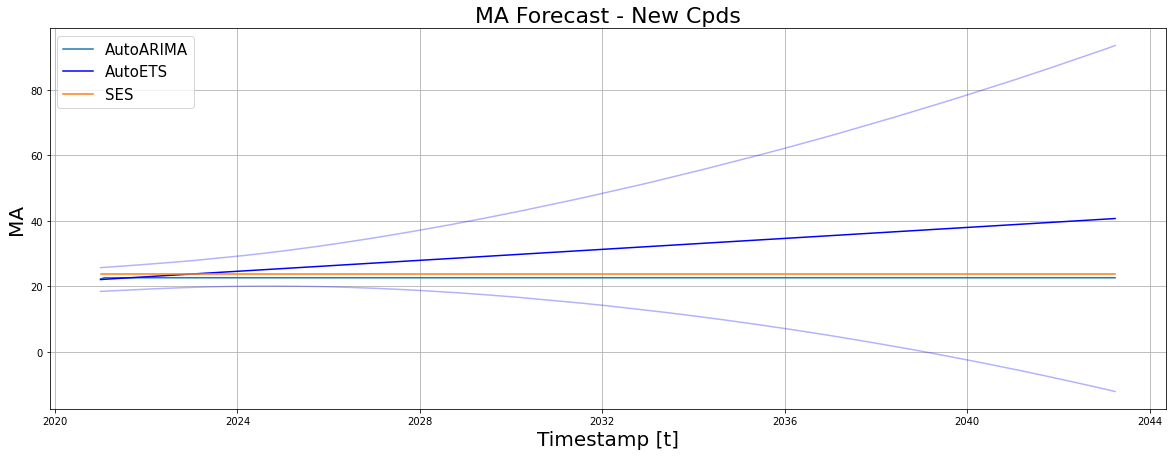

In [45]:
fig, ax = plt.subplots(1, 1, figsize = (20, 7))

plt.plot(Y_hatMA_df["ds"], Y_hatMA_df["AutoARIMA"], label="AutoARIMA")
plt.plot(Y_hatMA_df["ds"], Y_hatMA_df["AutoETS"], label="AutoETS", color="blue")
plt.plot(Y_hatMA_df["ds"], Y_hatMA_df["AutoETS-lo-95"], color="blue", alpha=0.3)
plt.plot(Y_hatMA_df["ds"], Y_hatMA_df["AutoETS-hi-95"], color="blue", alpha=0.3)

plt.plot(Y_hatMA_df["ds"], Y_hatMA_df["SES"], label="SES")

#plt.plot(Y_hatMA_df["ds"], Y_hatMA_df["y"], label="Actual")

#plot_df = pd.concat([Y_train_df, Y_hat_df]).set_index('ds')
# plot_df[['y', 'AutoARIMA', 'ETS']].plot(ax=ax, linewidth=2)

ax.set_title('MA Forecast - New Cpds', fontsize=22)
ax.set_ylabel('MA', fontsize=20)
ax.set_xlabel('Timestamp [t]', fontsize=20)
ax.legend(prop={'size': 15})
ax.grid()

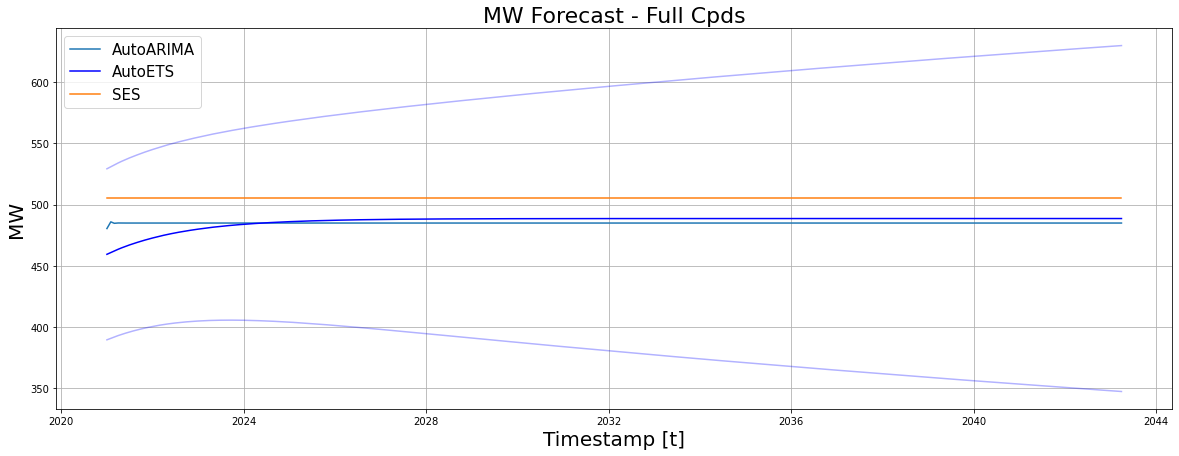

In [46]:
fig, ax = plt.subplots(1, 1, figsize = (20, 7))

plt.plot(Y_hatMW_df["ds"], Y_hatMW_df["AutoARIMA"], label="AutoARIMA")
plt.plot(Y_hatMW_df["ds"], Y_hatMW_df["AutoETS"], label="AutoETS", color="blue")
plt.plot(Y_hatMW_df["ds"], Y_hatMW_df["AutoETS-lo-95"], color="blue", alpha=0.3)
plt.plot(Y_hatMW_df["ds"], Y_hatMW_df["AutoETS-hi-95"], color="blue", alpha=0.3)

plt.plot(Y_hatMW_df["ds"], Y_hatMW_df["SES"], label="SES")

# plt.plot(Y_hatMW_df["ds"], Y_hatMW_df["y"], label="Actual")

#plot_df = pd.concat([Y_train_df, Y_hat_df]).set_index('ds')
# plot_df[['y', 'AutoARIMA', 'ETS']].plot(ax=ax, linewidth=2)

ax.set_title('MW Forecast - Full Cpds', fontsize=22)
ax.set_ylabel('MW', fontsize=20)
ax.set_xlabel('Timestamp [t]', fontsize=20)
ax.legend(prop={'size': 15})
ax.grid()

In [38]:
print(list(Y_hatMA_df["ds"])[-35:])

[Timestamp('2040-05-31 00:00:00'), Timestamp('2040-06-30 00:00:00'), Timestamp('2040-07-31 00:00:00'), Timestamp('2040-08-31 00:00:00'), Timestamp('2040-09-30 00:00:00'), Timestamp('2040-10-31 00:00:00'), Timestamp('2040-11-30 00:00:00'), Timestamp('2040-12-31 00:00:00'), Timestamp('2041-01-31 00:00:00'), Timestamp('2041-02-28 00:00:00'), Timestamp('2041-03-31 00:00:00'), Timestamp('2041-04-30 00:00:00'), Timestamp('2041-05-31 00:00:00'), Timestamp('2041-06-30 00:00:00'), Timestamp('2041-07-31 00:00:00'), Timestamp('2041-08-31 00:00:00'), Timestamp('2041-09-30 00:00:00'), Timestamp('2041-10-31 00:00:00'), Timestamp('2041-11-30 00:00:00'), Timestamp('2041-12-31 00:00:00'), Timestamp('2042-01-31 00:00:00'), Timestamp('2042-02-28 00:00:00'), Timestamp('2042-03-31 00:00:00'), Timestamp('2042-04-30 00:00:00'), Timestamp('2042-05-31 00:00:00'), Timestamp('2042-06-30 00:00:00'), Timestamp('2042-07-31 00:00:00'), Timestamp('2042-08-31 00:00:00'), Timestamp('2042-09-30 00:00:00'), Timestamp('20

Text(0, 0.5, 'Assembly Index')

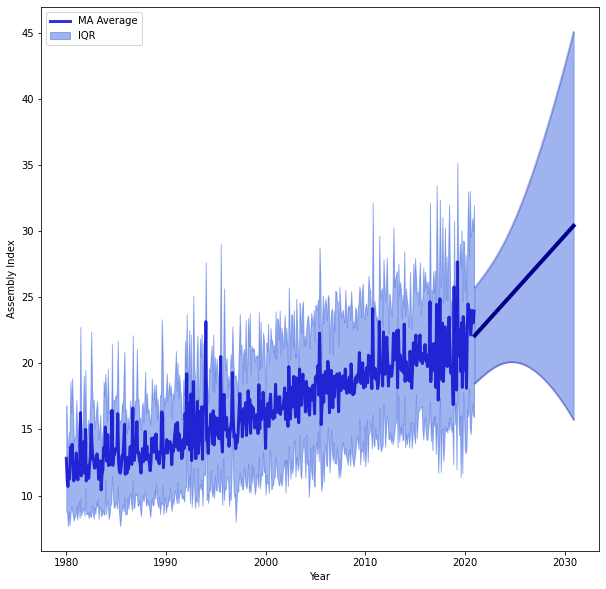

In [49]:
#Assembly values with standard deviation & predicted values (from autoETS)
plt.figure(figsize=(10,10))

new_color = "#f89b00"
full_color= "#313a61"
xs = pd.date_range(start = "1980-01-01", end = "2020-12-01", periods = 480).to_pydatetime().tolist()


## cutoff is the prediction level (number of months in the future)
cutoff = 120

#MA cpd prediction
plt.plot(MA_df_months["datetime"], MA_df_months["avg"], color="mediumblue",
            linewidth=3, markersize=10, alpha=0.8, label="MA Average")

plt.fill_between(MA_df_months["datetime"], MA_df_months["avg"] + MA_df_months["iqr"]/2, 
                MA_df_months["avg"] - MA_df_months["iqr"]/2, alpha=0.5, color="royalblue",
                label="IQR")

plt.plot(list(Y_hatMA_df["ds"])[:cutoff], list(Y_hatMA_df["AutoETS"])[:cutoff], color="darkblue",
    linewidth=4)
plt.plot(list(Y_hatMA_df["ds"])[:cutoff], list(Y_hatMA_df["AutoETS-lo-95"])[:cutoff], color="darkblue",
    linewidth=2, alpha=0.25)
plt.plot(list(Y_hatMA_df["ds"])[:cutoff], list(Y_hatMA_df["AutoETS-hi-95"])[:cutoff], color="darkblue",
    linewidth=2, alpha=0.25)

plt.fill_between(list(Y_hatMA_df["ds"])[:120], list(Y_hatMA_df["AutoETS-lo-95"])[:120], 
    list(Y_hatMA_df["AutoETS-hi-95"])[:120], color="royalblue", alpha=0.5)


# #Full cpd plotting
# plt.plot(xs, full_stats["MA_assemblyGo"]["mean"], color=full_color,
#             linewidth=3, markersize=10, alpha=0.8, label="All Compounds")

# #Full cpd prediction
# plt.plot(list(Y_hatFULL_df["ds"])[-cutoff:], list(Y_hatFULL_df["AutoETS"])[-cutoff:], color=full_color,
#     linewidth=4)
# plt.plot(list(Y_hatFULL_df["ds"])[-cutoff:], list(Y_hatFULL_df["AutoETS-lo-95"])[-cutoff:], color=full_color,
#     linewidth=2, alpha=0.25)
# plt.plot(list(Y_hatFULL_df["ds"])[-cutoff:], list(Y_hatFULL_df["AutoETS-hi-95"])[-cutoff:], color=full_color,
#     linewidth=2, alpha=0.25)

# plt.fill_between(list(Y_hatFULL_df["ds"])[-cutoff:], list(Y_hatFULL_df["AutoETS-lo-95"])[-cutoff:], 
#     list(Y_hatFULL_df["AutoETS-hi-95"])[-cutoff:], color=full_color, alpha=0.5)

plt.legend()
plt.xlabel("Year")
plt.ylabel("Assembly Index")

In [80]:
### Percent coverage at last predicted timestep - should be comparable with MA

final_ma_low = list(Y_hatFULL_df["AutoETS-lo-95"])[-1]
final_ma_high = list(Y_hatFULL_df["AutoETS-hi-95"])[-1]
final_ma_predicted = list(Y_hatFULL_df["AutoETS"])[-1]

print(final_ma_high)
print(final_ma_predicted)

mw_percent = final_ma_predicted / final_ma_high
print("Percent coverage:", (1 - mw_percent) * 100 )

21.082412719726562
19.117979049682617
Percent coverage: 9.31787882231263


## Try simple exponential smoothing

From statsforecast (for now): https://nixtla.github.io/statsforecast/models.html#exponentialsmoothing

In [91]:
models = [
SimpleExponentialSmoothing(0.2)
]

model = StatsForecast(
df=Y_train_df,
models=models,
freq='M',
n_jobs=-1)

In [118]:
Y_hat_df = model.forecast(horizon).reset_index()
Y_hat_df.head()


unique_id         ds        SES
0          0 1980-01-31  14.143757
1          0 1980-02-29  14.143757
2          0 1980-03-31  14.143757
3          0 1980-04-30  14.143757
4          0 1980-05-31  14.143757

In [119]:
y_hat_ds = list(set(list(Y_hat_df["ds"])))
Y_hat_df_2 = Y_hat_df.groupby("unique_id")


In [125]:
print(Y_hat_df_2.head())
print(list(Y_hat_df[Y_hat_df["unique_id"] == 335]["SES"]))

       unique_id         ds        SES
0              0 1980-01-31  14.143757
1              0 1980-02-29  14.143757
2              0 1980-03-31  14.143757
3              0 1980-04-30  14.143757
4              0 1980-05-31  14.143757
...          ...        ...        ...
48240        335 2007-12-31  18.562628
48241        335 2008-01-31  18.562628
48242        335 2008-02-29  18.562628
48243        335 2008-03-31  18.562628
48244        335 2008-04-30  18.562628

[1680 rows x 3 columns]
[18.5626277923584, 18.5626277923584, 18.5626277923584, 18.5626277923584, 18.5626277923584, 18.5626277923584, 18.5626277923584, 18.5626277923584, 18.5626277923584, 18.5626277923584, 18.5626277923584, 18.5626277923584, 18.5626277923584, 18.5626277923584, 18.5626277923584, 18.5626277923584, 18.5626277923584, 18.5626277923584, 18.5626277923584, 18.5626277923584, 18.5626277923584, 18.5626277923584, 18.5626277923584, 18.5626277923584, 18.5626277923584, 18.5626277923584, 18.5626277923584, 18.5626277923584, 18

In [117]:
print(len(y_hat_ds))
print(len(Y_hat_df))

479
336


ValueError: x and y must be the same size

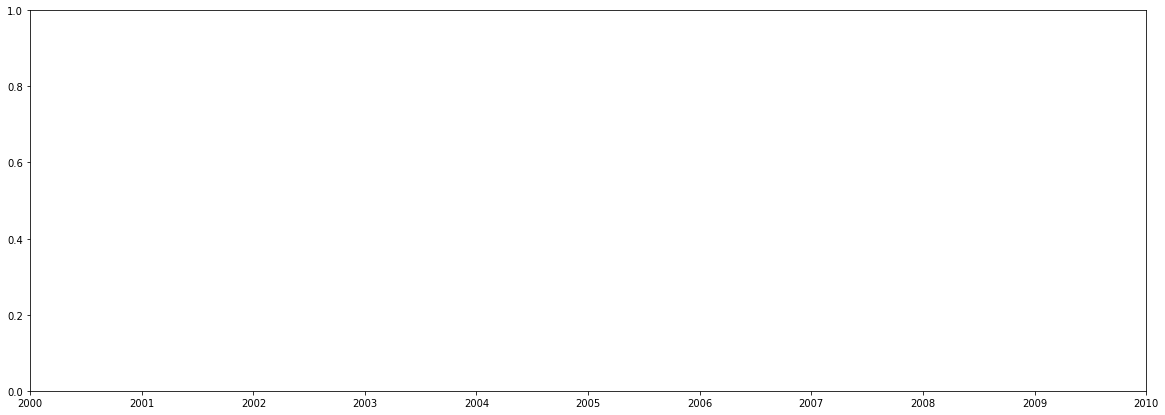

In [111]:
fig, ax = plt.subplots(1, 1, figsize = (20, 7))

#Plot SES
plt.scatter(y_hat_ds, Y_hat_df["SES"]["mean"], label="SES")

#Plot actual Y
plt.plot(Y_train_df["ds"], Y_train_df["y"], label="Y", color="orange")
plt.plot(Y_test_df["ds"], Y_test_df["y"], color="orange")

ax.set_title('Forecast Synthetic Data', fontsize=22)
ax.set_ylabel('Number', fontsize=20)
ax.set_xlabel('Timestamp [t]', fontsize=20)
ax.legend(prop={'size': 15})
ax.grid()

# New / Total Compound Assemblies (Monte Carlo)

There are varying numbers of compounds for each month - so it's necessary to make separate lists for each month. These are stored in a dictionary {month: [assembly values]}

### Plotting

Plot mean, standard deviation, other data for each month

Using two files = fullCpds_ & newCpds_AssemblyValues.csv in Data/AssemblyValues

Goal = get average & std MA, as well as average avg MW, for each month

In [33]:
full_df_old = pd.read_csv("Data/AssemblyValues/fullCpds_AssemblyValues.csv")
new_df_old = pd.read_csv("Data/AssemblyValues/newCpds_AssemblyValues.csv")
print(full_df_old.head())
print("----------------------------------")
print(new_df_old.head())

   Unnamed: 0    month                                              inchi  ai  \
0           0  2003-01             InChI=1S/C6H5Cl/c7-6-4-2-1-3-5-6/h1-5H   4   
1           1  2003-01  InChI=1S/C4H8O2.C3H8O/c1-3-6-4(2)5;1-3(2)4/h3H...   3   
2           2  2003-01  InChI=1S/C31H46O2/c1-22(2)12-9-13-23(3)14-10-1...  18   
3           3  2003-01  InChI=1S/C29H32O13/c1-11-36-9-20-27(40-11)24(3...  28   
4           4  2003-01  InChI=1S/C12H22N4O11P2/c1-16(2,3)26-29(22,23)2...  26   

           mw  
0  112.007978  
1  148.109944  
2  450.349781  
3  588.184291  
4  460.076031  
----------------------------------
   Unnamed: 0    month                                              inchi  ai  \
0           0  1996-01  InChI=1S/C12H19NO2/c1-3-4-5-6-8-11(2)15-12(14)...  11   
1           1  1996-01  InChI=1S/C14H10ClN3S2/c15-11-4-2-1-3-10(11)13-...  18   
2           2  1996-01  InChI=1S/C8H10N2O2/c9-7-3-1-6(2-4-7)5-12-8(10)...   9   
3           3  1996-01  InChI=1S/C13H21NO2/c1-10(9-14(3)4)

In [34]:
#Average mw values per month
full_stats = full_df_old.groupby(["month"]).agg({"ai":["mean","std"],"mw":["mean"]})
new_stats = new_df_old.groupby(["month"]).agg({"ai":["mean","std"],"mw":["mean"]})

print(full_stats)
print("----------------------------------")
print(new_stats)

                ai                     mw
              mean        std        mean
month                                    
1980-01  14.542477   8.578500  288.903786
1980-02  14.957113   9.432218  296.786454
1980-03  14.758230   8.803624  294.921734
1980-04  15.343189   9.410054  301.813923
1980-05  15.006224   9.419604  294.044223
...            ...        ...         ...
2019-08  23.524145  15.969379  404.242385
2019-09  24.048780  18.210526  404.686906
2019-10  24.800403  17.323901  414.404896
2019-11  24.421748  19.445047  413.057041
2019-12  22.172239  16.789918  382.471763

[480 rows x 3 columns]
----------------------------------
                ai                     mw
              mean        std        mean
month                                    
1980-01  17.805846   9.699448  336.580176
1980-02  17.781218   8.823664  337.134343
1980-03  17.573045   8.388716  336.756317
1980-04  17.953608   8.701263  339.631414
1980-05  17.264859  11.150925  336.565682
...            ..

Text(0, 0.5, 'Molecular Weight (Daltons)')

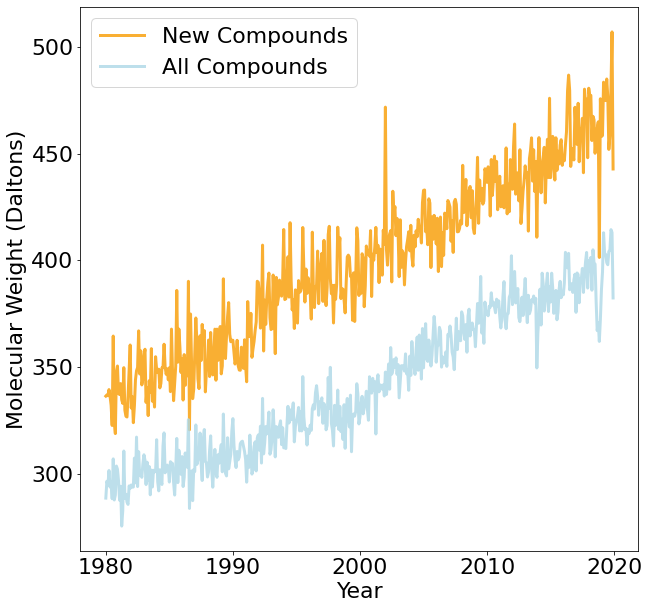

In [35]:
## Avg MA value per month

#Assembly values with standard deviation
plt.figure(figsize=(10,10))

plt.plot(np.arange(1980, 2020, 1/12), new_stats["mw"]["mean"], color="#f89b00",
            linewidth=3, markersize=10, alpha=0.8, label="New Compounds")

plt.plot(np.arange(1980, 2020, 1/12), full_stats["mw"]["mean"], color="lightblue",
            linewidth=3, markersize=10, alpha=0.8, label="All Compounds")

plt.legend()
plt.xlabel("Year")
plt.ylabel("Molecular Weight (Daltons)")

## Test distribution width of AssemblyGo MA & MW

Gage's idea - the narrower distribution is the better predictor of future trends

Data organization & algorithm
- Labels in full_df
- Mol files in Data/AssemblyValues/FullDatabase & NewDatabase
- Use label to load rdkit mol object, return molecular weight

In [37]:
print(full_df_old)

        Unnamed: 0    month  \
0                0  2003-01   
1                1  2003-01   
2                2  2003-01   
3                3  2003-01   
4                4  2003-01   
...            ...      ...   
468286       11801  2012-12   
468287       11802  2012-12   
468288       11803  2012-12   
468289       11804  2012-12   
468290       11805  2012-12   

                                                    inchi  ai          mw  
0                  InChI=1S/C6H5Cl/c7-6-4-2-1-3-5-6/h1-5H   4  112.007978  
1       InChI=1S/C4H8O2.C3H8O/c1-3-6-4(2)5;1-3(2)4/h3H...   3  148.109944  
2       InChI=1S/C31H46O2/c1-22(2)12-9-13-23(3)14-10-1...  18  450.349781  
3       InChI=1S/C29H32O13/c1-11-36-9-20-27(40-11)24(3...  28  588.184291  
4       InChI=1S/C12H22N4O11P2/c1-16(2,3)26-29(22,23)2...  26  460.076031  
...                                                   ...  ..         ...  
468286  InChI=1S/C43H39Cl3N6O4/c44-26-9-11-30(32(46)21...  63  808.209837  
468287  InChI=1S/C3

In [30]:
def get_MW(label):
    mol = Chem.MolFromMolFile("Data/AssemblyValues/FullDatabase/" + label + ".mol")
    return Descriptors.ExactMolWt(mol)

In [31]:
weights = []

for label in tqdm(list(full_df["label"])):
    weights.append(get_MW(label))

KeyError: 'label'

In [42]:
#Apply to full and new dataframes
tqdm.pandas()

full_df["month"] = full_df["label"].apply(get_month)
new_df["month"] = new_df["label"].apply(get_month)

full_df["MW"] = weights

full_df = full_df.dropna()
new_df = new_df.dropna()

print(full_df)


        Unnamed: 0           label  MA_assemblyGo    month          MW
0                0  1994-03_365031             13  1994-03  308.055529
1                1  1994-09_370717             11  1994-09  252.925366
2                2   2017-11_80436             22  2017-11  426.216809
3                3  2010-04_214306              9  2010-04  188.028500
4                4  2005-11_267327             12  2005-11  502.423340
...            ...             ...            ...      ...         ...
467872      467872  2018-01_433720             21  2018-01  458.134794
467873      467873  2016-12_420694             30  2016-12  584.150525
467874      467874  1997-05_238251              7  1997-05  522.573967
467875      467875  1993-03_283329             24  1993-03  474.263091
467876      467876  1982-10_184989             16  1982-10  318.112819

[466872 rows x 5 columns]


[  1  19  44  79  87 107  83  87  84  69  50  57  45  30  20  11  15  15
  13   6  13   6   6   4   4   3   5   3   3   1   1   1   1]
NormaltestResult(statistic=5.731301493661258, pvalue=0.05694606160279805)
Peaks: [5]
Widths: (array([7.5037594]), array([54.]), array([2.28571429]), array([9.78947368]))


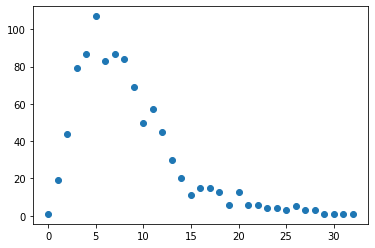

In [75]:
### Testing: get distribution stats for 1980-01
sub_df = full_df[full_df["month"] == "1980-01"]

values, counts = np.unique(sub_df["MA_assemblyGo"], return_counts = True)
print(counts)

# print(sub_df["MA_assemblyGo"].describe())
print(stats.normaltest(counts))

#Find peaks, then find widths
peaks, _ = find_peaks(counts, threshold=max(counts)/10)
# max_loc = np.where(max(counts))
# print(max_loc[0])
# print(max_loc.shape)
print("Peaks:", peaks)

widths = peak_widths(counts, peaks)
print("Widths:", widths)

# print("-----")
# print(sub_df["MW"].describe())
# print(stats.normaltest(sub_df["MW"]))

plt.scatter(np.arange(0, len(counts)), counts)



NormaltestResult(statistic=1022.3143890911133, pvalue=1.0168362579330784e-222)
Peaks: [  4  10  12  22  24  27  29  33  36  44  68  74  93 102 106 109 122 128
 133 141 146 157 201 210 229 236 274 296 332 336 380 397 401 427 464 517
 573 582 646]
Widths: (array([1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1.5, 1. , 1. , 1.5, 1. ,
       1.5, 1. , 1.5, 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. ,
       1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. ]), array([3. , 1.5, 1.5, 1.5, 1.5, 1.5, 2. , 1.5, 2. , 1.5, 1.5, 2. , 2. ,
       2. , 1.5, 2. , 1.5, 1.5, 1.5, 1.5, 1.5, 1.5, 1.5, 1.5, 1.5, 1.5,
       1.5, 1.5, 1.5, 1.5, 1.5, 1.5, 1.5, 1.5, 1.5, 1.5, 1.5, 1.5, 1.5]), array([  3.5,   9.5,  11.5,  21.5,  23.5,  26.5,  28.5,  32.5,  35. ,
        43.5,  67.5,  73. ,  92.5, 101.5, 105.5, 108. , 121.5, 127.5,
       132.5, 140.5, 145.5, 156.5, 200.5, 209.5, 228.5, 235.5, 273.5,
       295.5, 331.5, 335.5, 379.5, 396.5, 400.5, 426.5, 463.5, 516.5,
       572.5, 581.5, 645.5]),

(array([32., 60., 66., 71., 76., 90., 68., 75., 68., 57., 44., 54., 32.,
        27., 25., 15., 10., 17.,  9., 17., 12.,  7.,  7.,  4.,  4.,  4.,
         4.,  2.,  1.,  1.,  4.,  2.,  1.,  1.,  0.,  0.,  0.,  0.,  0.,
         0.,  3.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  2.]),
 array([ 107.07349929,  127.62714076,  148.18078222,  168.73442369,
         189.28806516,  209.84170663,  230.3953481 ,  250.94898957,
         271.50263103,  292.0562725 ,  312.60991397,  333.16355544,
         353.71719691,  374.27083838,  394.82447984,  415.37812131,
         435.93176278,  456.48540425,  477.03904572,  497.59268719,
         518.14632865,  538.69997012,  559.25361159,  579.80725306,
         600.36089453,  620.914536  ,  641.46817746,  662.02181893,
         682.5754604 ,  703.12910187,  723.68274334,  744.23638481,
         764.79002627,  785.34366774,  805.89730921,  826.45095068,
         847.00459215,  867.55823362,  888.11187508,  908.66551655,
         929.21915802,  949.77279949

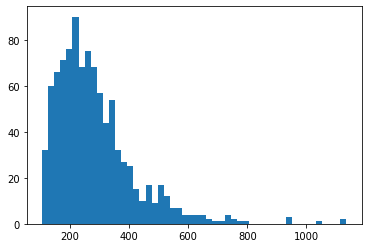

In [79]:
### Testing: get distribution stats for 1980-01
sub_df = full_df[full_df["month"] == "1980-01"]

values, counts = np.unique(sub_df["MW"], return_counts = True)

# print(sub_df["MA_assemblyGo"].describe())
print(stats.normaltest(counts))

#Find peaks, then find widths
peaks, _ = find_peaks(counts, threshold=max(counts)/10)
# max_loc = np.where(max(counts))
# print(max_loc[0])
# print(max_loc.shape)
print("Peaks:", peaks)

widths = peak_widths(counts, peaks)
print("Widths:", widths)

# print("-----")
# print(sub_df["MW"].describe())
# print(stats.normaltest(sub_df["MW"]))

plt.hist(sub_df["MW"], bins=50)



(array([0.31346351, 0.68139774, 0.8684481 , 0.93833505, 0.97327852,
        0.98561151, 0.9938335 , 0.9938335 , 0.99691675, 1.        ]),
 array([ 107.07349929,  209.84170663,  312.60991397,  415.37812131,
         518.14632865,  620.914536  ,  723.68274334,  826.45095068,
         929.21915802, 1031.98736536, 1134.7555727 ]),
 <BarContainer object of 10 artists>)

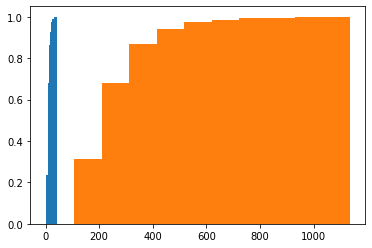

In [89]:
stats.ks_2samp(list(sub_df["MA_assemblyGo"].values), list(sub_df["MW"].values), alternative="greater")

plt.hist(sub_df["MA_assemblyGo"], density=True, cumulative=True)
plt.hist(sub_df["MW"], density=True, cumulative=True)

In [91]:
#Try normalizing data
from sklearn import preprocessing

MAs = preprocessing.normalize([sub_df["MA_assemblyGo"]])

MWs = preprocessing.normalize([sub_df["MW"]])


[[ 0.03539701  0.02781194  0.02781194  0.03539701  0.03539701  0.05056716
   0.01517015  0.02275522  0.02275522  0.02022687  0.01769851  0.01011343
   0.02528358  0.03286866  0.01264179  0.03792537  0.02022687  0.01517015
   0.03539701  0.01517015  0.02022687  0.05056716  0.0303403   0.05309552
   0.01517015  0.02022687  0.01264179  0.0303403   0.02275522  0.01769851
  -0.00252836  0.02781194  0.01769851  0.09860597  0.06573731  0.02275522
   0.02022687  0.03286866  0.02528358  0.03792537  0.04298209  0.01517015
   0.02781194  0.01769851  0.02275522  0.05815224  0.02022687  0.04298209
   0.02275522  0.02022687  0.08343582  0.01769851  0.01517015  0.03286866
   0.02022687  0.04298209  0.01011343  0.02781194  0.0303403   0.04298209
   0.06573731  0.01011343  0.0303403   0.0303403   0.01517015  0.03286866
   0.02275522  0.01769851  0.01769851  0.01769851  0.01769851  0.02022687
   0.04045373  0.03286866  0.03539701  0.0303403   0.01517015  0.02528358
   0.02022687  0.02022687  0.01517015 

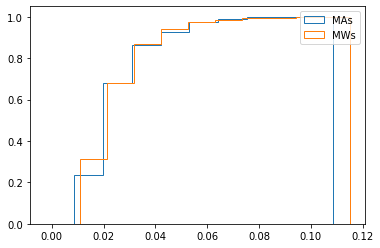

In [97]:
plt.hist(MAs[0], density=True, histtype="step", cumulative=True, label="MAs")
plt.hist(MWs[0], density=True, histtype="step", cumulative=True, label="MWs")

plt.legend()

In [ ]:
### GET PDF - THIS IS THE HOW QUICK THE DISTRIBUTION CHANGES (AND THEREFORE IS A MEASURE OF NARROWNESS, 
# NARROWER DISTRIBUTIONS CHANGE QUICKER)

## Predict MW increases in the future 

Using same AutoETS code for MA

Theory - the smaller distribution in the future (e.g., size of 95% confidence interval) will be helpful in determining which of the two is narrower

In [44]:
from statsforecast import StatsForecast
from statsforecast.models import AutoARIMA, AutoETS, SimpleExponentialSmoothing

In [45]:
full_df_mw = pd.read_csv("Data/AssemblyValues/fullCpds_AssemblyValues.csv")
new_df_old = pd.read_csv("Data/AssemblyValues/newCpds_AssemblyValues.csv")
print(full_df_old.head())
print("----------------------------------")
print(new_df_old.head())

   Unnamed: 0    month                                              inchi  ai  \
0           0  2003-01             InChI=1S/C6H5Cl/c7-6-4-2-1-3-5-6/h1-5H   4   
1           1  2003-01  InChI=1S/C4H8O2.C3H8O/c1-3-6-4(2)5;1-3(2)4/h3H...   3   
2           2  2003-01  InChI=1S/C31H46O2/c1-22(2)12-9-13-23(3)14-10-1...  18   
3           3  2003-01  InChI=1S/C29H32O13/c1-11-36-9-20-27(40-11)24(3...  28   
4           4  2003-01  InChI=1S/C12H22N4O11P2/c1-16(2,3)26-29(22,23)2...  26   

           mw  
0  112.007978  
1  148.109944  
2  450.349781  
3  588.184291  
4  460.076031  
----------------------------------
   Unnamed: 0    month                                              inchi  ai  \
0           0  1996-01  InChI=1S/C12H19NO2/c1-3-4-5-6-8-11(2)15-12(14)...  11   
1           1  1996-01  InChI=1S/C14H10ClN3S2/c15-11-4-2-1-3-10(11)13-...  18   
2           2  1996-01  InChI=1S/C8H10N2O2/c9-7-3-1-6(2-4-7)5-12-8(10)...   9   
3           3  1996-01  InChI=1S/C13H21NO2/c1-10(9-14(3)4)

In [48]:
## Get dataframes with dates (necessary for the AutoARIMA model)
full_df_mw = full_df_old.groupby(["month"]).agg({"mw":["mean","std"]}).reset_index()

new_df_mw = new_df_old.groupby(["month"]).agg({"mw":["mean","std"]}).reset_index()

print(full_df_mw)

       month          mw            
                    mean         std
0    1980-01  288.903786  146.598677
1    1980-02  296.786454  146.024411
2    1980-03  294.921734  140.442600
3    1980-04  301.813923  144.990354
4    1980-05  294.044223  145.079729
..       ...         ...         ...
475  2019-08  404.242385  195.509793
476  2019-09  404.686906  218.538348
477  2019-10  414.404896  201.612743
478  2019-11  413.057041  246.032313
479  2019-12  382.471763  198.892265

[480 rows x 3 columns]


In [50]:
# Turn dates into ordinal values (for training purposes)
months = pd.Series(full_df_mw["month"]) + "-01"

datetimes = []
for date in months:
    datetimes.append(dt.strptime(date, '%Y-%m-%d').date())

In [51]:
#Ensure proper dataframe setup (remove groupby association, change month to datetimes)
full_df_MW = pd.DataFrame()
full_df_MW["ds"] = datetimes
full_df_MW["y"] = full_df_mw["mw"]["mean"]
full_df_MW["unique_id"] = [0] * len(full_df_MW)
full_df_MW = full_df_MW.set_index("unique_id")
full_df_MW.reset_index()
print(full_df_MW)

print("----------")

new_df_MW = pd.DataFrame()
new_df_MW["ds"] = datetimes
new_df_MW["y"] = new_df_mw["mw"]["mean"]
new_df_MW["unique_id"] = [0] * len(new_df_MW)
new_df_MW = new_df_MW.set_index("unique_id")
new_df_MW.reset_index()

print(new_df_MW)


                   ds           y
unique_id                        
0          1980-01-01  288.903786
0          1980-02-01  296.786454
0          1980-03-01  294.921734
0          1980-04-01  301.813923
0          1980-05-01  294.044223
...               ...         ...
0          2019-08-01  404.242385
0          2019-09-01  404.686906
0          2019-10-01  414.404896
0          2019-11-01  413.057041
0          2019-12-01  382.471763

[480 rows x 2 columns]
----------
                   ds           y
unique_id                        
0          1980-01-01  336.580176
0          1980-02-01  337.134343
0          1980-03-01  336.756317
0          1980-04-01  339.631414
0          1980-05-01  336.565682
...               ...         ...
0          2019-08-01  451.904218
0          2019-09-01  458.872211
0          2019-10-01  480.513055
0          2019-11-01  506.845204
0          2019-12-01  442.764811

[480 rows x 2 columns]


In [52]:
## Set up training/test dataframes
Y_trainNEW_df = new_df_MW[:n_train]
Y_testNEW_df = new_df_MW[n_train:]

Y_trainFULL_df = full_df_MW[:n_train]
Y_testFULL_df = full_df_MW[n_train:]

print(Y_trainNEW_df.head())
print("-----")
print(Y_trainFULL_df.head())

                   ds           y
unique_id                        
0          1980-01-01  336.580176
0          1980-02-01  337.134343
0          1980-03-01  336.756317
0          1980-04-01  339.631414
0          1980-05-01  336.565682
-----
                   ds           y
unique_id                        
0          1980-01-01  288.903786
0          1980-02-01  296.786454
0          1980-03-01  294.921734
0          1980-04-01  301.813923
0          1980-05-01  294.044223


In [53]:
## Set up model parameters

season_length = 12 #example is built on 12-month-long cyclical data, but this might work for me too...
horizon = len(Y_testNEW_df)

models = [
AutoARIMA(season_length = season_length),
AutoETS(season_length = season_length, model='ZZZ'),
SimpleExponentialSmoothing(0.99)
]

modelNEW = StatsForecast(
df=Y_trainNEW_df,
models=models,
freq='M',
n_jobs=-1)

modelFULL = StatsForecast(
df=Y_trainFULL_df,
models=models,
freq='M',
n_jobs=-1)

In [54]:
## NOTE: takes ~30 seconds the first time

# Addition to horizon is the number of months in the future (120 corresponds to 10 years)

Y_hatNEW_df = modelNEW.forecast(horizon + 120, level=[95]).reset_index()
Y_hatNEW_df.head()

unique_id         ds   AutoARIMA  AutoARIMA-lo-95  AutoARIMA-hi-95  \
0          0 2007-12-31  417.687653       392.696350       442.678955   
1          0 2008-01-31  417.687653       392.483612       442.891724   
2          0 2008-02-29  417.687653       392.272614       443.102692   
3          0 2008-03-31  417.687653       392.063385       443.311951   
4          0 2008-04-30  417.687653       391.855835       443.519501   

      AutoETS  AutoETS-lo-95  AutoETS-hi-95         SES  
0  420.473694     395.809662     445.137695  418.644958  
1  420.727417     396.013824     445.440979  418.644958  
2  420.981140     396.217926     445.744354  418.644958  
3  421.234863     396.421967     446.047760  418.644958  
4  421.488586     396.625946     446.351227  418.644958

In [55]:
Y_hatFULL_df = modelFULL.forecast(horizon + 120, level=[95]).reset_index()
Y_hatFULL_df.head()

unique_id         ds  AutoARIMA  AutoARIMA-lo-95  AutoARIMA-hi-95  \
0          0 2007-12-31  362.12085       346.046936       378.194733   
1          0 2008-01-31  362.12085       345.849091       378.392609   
2          0 2008-02-29  362.12085       345.653595       378.588104   
3          0 2008-03-31  362.12085       345.460388       378.781311   
4          0 2008-04-30  362.12085       345.269379       378.972290   

      AutoETS  AutoETS-lo-95  AutoETS-hi-95         SES  
0  363.313232     347.479858     379.146606  362.494415  
1  363.523987     347.621826     379.426117  362.494415  
2  363.734711     347.763977     379.705475  362.494415  
3  363.945465     347.906250     379.984711  362.494415  
4  364.156219     348.048645     380.263763  362.494415

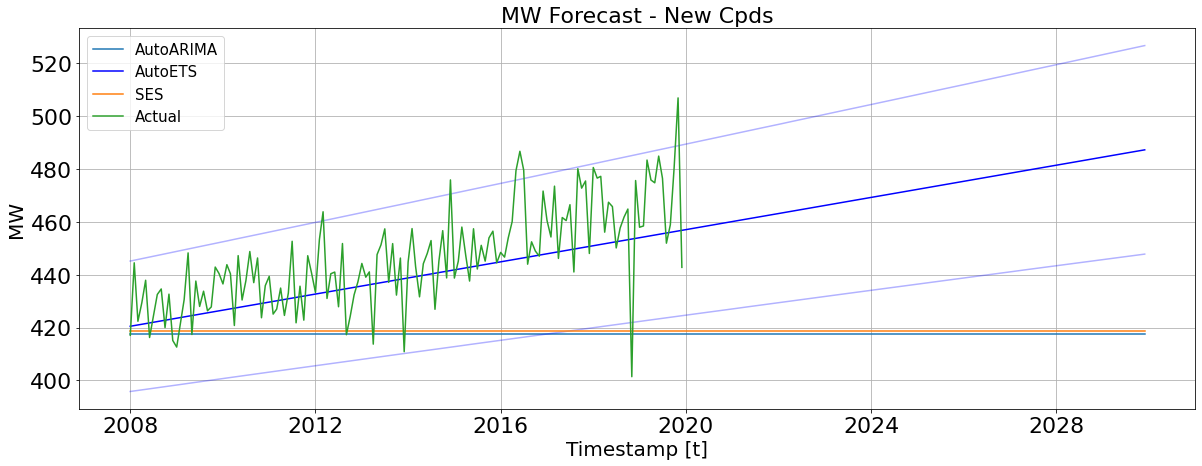

In [56]:
fig, ax = plt.subplots(1, 1, figsize = (20, 7))

plt.plot(Y_hatNEW_df["ds"], Y_hatNEW_df["AutoARIMA"], label="AutoARIMA")
plt.plot(Y_hatNEW_df["ds"], Y_hatNEW_df["AutoETS"], label="AutoETS", color="blue")
plt.plot(Y_hatNEW_df["ds"], Y_hatNEW_df["AutoETS-lo-95"], color="blue", alpha=0.3)
plt.plot(Y_hatNEW_df["ds"], Y_hatNEW_df["AutoETS-hi-95"], color="blue", alpha=0.3)

plt.plot(Y_hatNEW_df["ds"], Y_hatNEW_df["SES"], label="SES")

plt.plot(Y_testNEW_df["ds"], Y_testNEW_df["y"], label="Actual")

#plot_df = pd.concat([Y_train_df, Y_hat_df]).set_index('ds')
# plot_df[['y', 'AutoARIMA', 'ETS']].plot(ax=ax, linewidth=2)

ax.set_title('MW Forecast - New Cpds', fontsize=22)
ax.set_ylabel('MW', fontsize=20)
ax.set_xlabel('Timestamp [t]', fontsize=20)
ax.legend(prop={'size': 15})
ax.grid()

Text(0, 0.5, 'Molecular Weight (Daltons)')

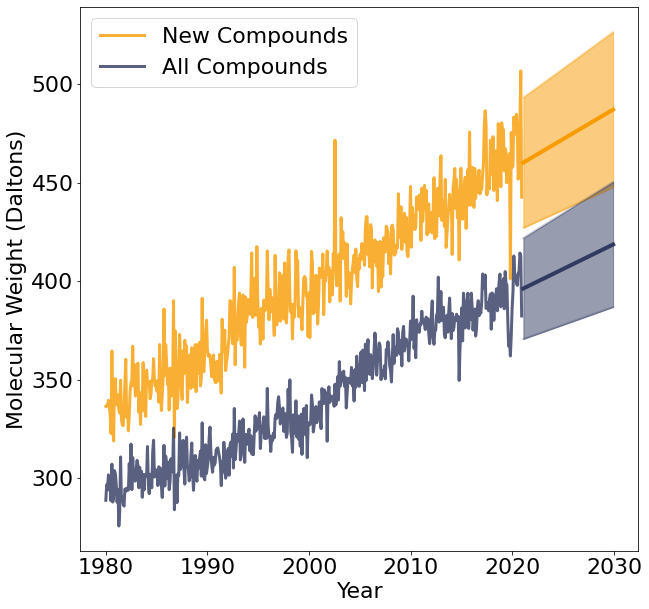

In [57]:
#Assembly values with standard deviation & predicted values (from autoETS)
plt.figure(figsize=(10,10))

new_color = "#f89b00"
full_color= "#313a61"
xs = pd.date_range(start = "1980-01-01", end = "2020-12-01", periods = 480).to_pydatetime().tolist()

plt.plot(xs, new_stats["mw"]["mean"], color=new_color,
            linewidth=3, markersize=10, alpha=0.8, label="New Compounds")

## cutoff is the prediction level (number of months in the future, minus 13 - not entirely sure why this works)
cutoff = 120 - 13

#New cpd prediction
plt.plot(list(Y_hatNEW_df["ds"])[-cutoff:], list(Y_hatNEW_df["AutoETS"])[-cutoff:], color=new_color,
    linewidth=4)
plt.plot(list(Y_hatNEW_df["ds"])[-cutoff:], list(Y_hatNEW_df["AutoETS-lo-95"])[-cutoff:], color=new_color,
    linewidth=2, alpha=0.25)
plt.plot(list(Y_hatNEW_df["ds"])[-cutoff:], list(Y_hatNEW_df["AutoETS-hi-95"])[-cutoff:], color=new_color,
    linewidth=2, alpha=0.25)

plt.fill_between(list(Y_hatNEW_df["ds"])[-cutoff:], list(Y_hatNEW_df["AutoETS-lo-95"])[-cutoff:], 
    list(Y_hatNEW_df["AutoETS-hi-95"])[-cutoff:], color=new_color, alpha=0.5)


#Full cpd plotting
plt.plot(xs, full_stats["mw"]["mean"], color=full_color,
            linewidth=3, markersize=10, alpha=0.8, label="All Compounds")

#Full cpd prediction
plt.plot(list(Y_hatFULL_df["ds"])[-cutoff:], list(Y_hatFULL_df["AutoETS"])[-cutoff:], color=full_color,
    linewidth=4)
plt.plot(list(Y_hatFULL_df["ds"])[-cutoff:], list(Y_hatFULL_df["AutoETS-lo-95"])[-cutoff:], color=full_color,
    linewidth=2, alpha=0.25)
plt.plot(list(Y_hatFULL_df["ds"])[-cutoff:], list(Y_hatFULL_df["AutoETS-hi-95"])[-cutoff:], color=full_color,
    linewidth=2, alpha=0.25)

plt.fill_between(list(Y_hatFULL_df["ds"])[-cutoff:], list(Y_hatFULL_df["AutoETS-lo-95"])[-cutoff:], 
    list(Y_hatFULL_df["AutoETS-hi-95"])[-cutoff:], color=full_color, alpha=0.5)

plt.legend()
plt.xlabel("Year")
plt.ylabel("Molecular Weight (Daltons)")

In [63]:
### Percent coverage at last predicted timestep - should be comparable with MA

final_mw_low = list(Y_hatFULL_df["AutoETS-lo-95"])[-1]
final_mw_high = list(Y_hatFULL_df["AutoETS-hi-95"])[-1]
final_mw_predicted = list(Y_hatFULL_df["AutoETS"])[-1]

print(final_mw_high)
print(final_mw_predicted)

mw_percent = final_mw_predicted / final_mw_high
print("Percent coverage:", (1 - mw_percent) * 100 )


450.4697570800781
418.7395324707031
Percent coverage: 7.043807960616199


## MA with Standard Deviation

And other tests!

Text(0, 0.5, 'Assembly Index')

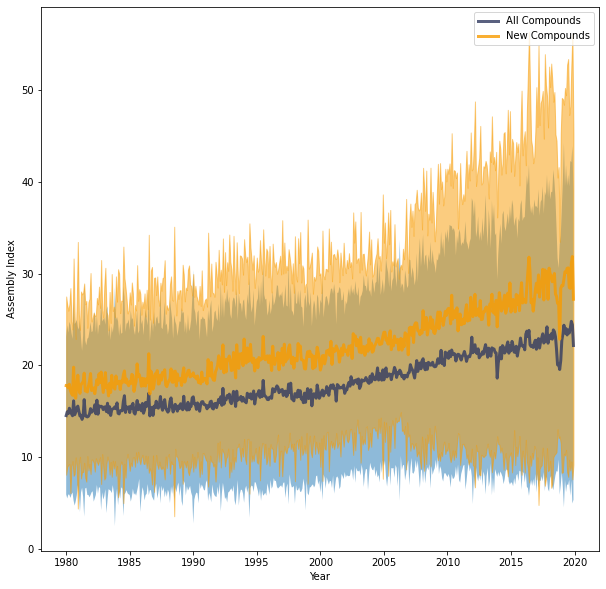

In [11]:
#Assembly values with standard deviation
plt.figure(figsize=(10,10))

# plt.errorbar(np.arange(1980, 2019, 1/12), full_month_avgs, yerr=full_month_stds, color="#313a61",
#             elinewidth=1, linewidth=3, markersize=10, alpha=0.8, label="All Compounds")
plt.plot(np.arange(1980, 2020, 1/12), full_stats["ai"]["mean"], color="#313a61",
            linewidth=3, markersize=10, alpha=0.8, label="All Compounds")
plt.fill_between(np.arange(1980, 2020, 1/12), full_stats["ai"]["mean"] - full_stats["ai"]["std"], 
                full_stats["ai"]["mean"] + full_stats["ai"]["std"], alpha=0.5)

# # plt.errorbar(np.arange(1980, 2019, 1/12), new_month_avgs, yerr=new_month_stds, color="#f89b00",
# #             elinewidth=1, linewidth=3, markersize=10, alpha=0.4, label="New Compounds")

plt.plot(np.arange(1980, 2020, 1/12), new_stats["ai"]["mean"], color="#f89b00",
            linewidth=3, markersize=10, alpha=0.8, label="New Compounds")
plt.fill_between(np.arange(1980, 2020, 1/12), new_stats["ai"]["mean"] - new_stats["ai"]["std"], 
                new_stats["ai"]["mean"] + new_stats["ai"]["std"], alpha=0.5, color="#f89b00")

#plt.axes().xaxis.set_major_locator(MaxNLocator(integer=True))
plt.legend()
plt.xlabel("Year")
plt.ylabel("Assembly Index")

Text(0, 0.5, 'Assembly Index')

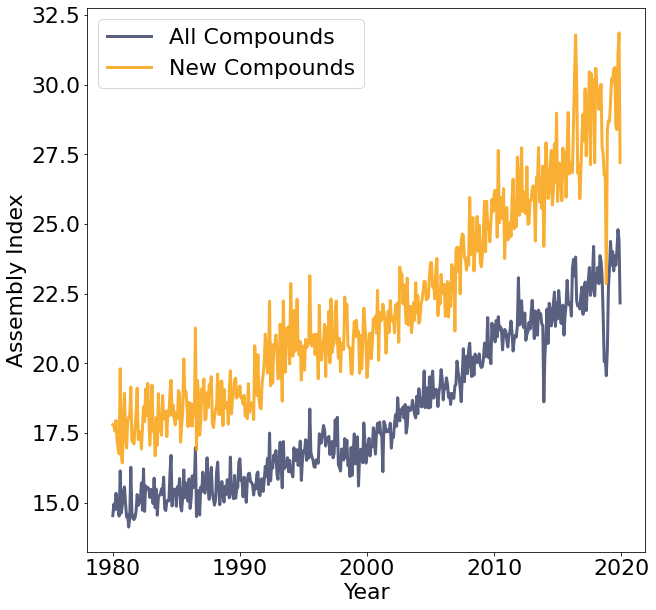

In [22]:
#Assembly values with standard deviation
plt.figure(figsize=(10,10))

plt.plot(np.arange(1980, 2020, 1/12), full_stats["ai"]["mean"], color="#313a61",
            linewidth=3, markersize=10, alpha=0.8, label="All Compounds")

plt.plot(np.arange(1980, 2020, 1/12), new_stats["ai"]["mean"], color="#f89b00",
            linewidth=3, markersize=10, alpha=0.8, label="New Compounds")

plt.legend()
plt.xlabel("Year")
plt.ylabel("Assembly Index")

## Expected Assembly Values

Based on linear regression of a large assortment of assembly values (in ~/Lab/AssemblyValues/)

x = 0.0456; b = 2.4826

In [27]:
#Add a "expected assembly value" column to each results dataframe
full_stats["ExpectedMA"] = 2.4826 + 0.0456*full_stats["mw"]["mean"]
new_stats["ExpectedMA"] = 2.4826 + 0.0456*new_stats["mw"]["mean"]

Text(0, 0.5, 'Assembly Index')

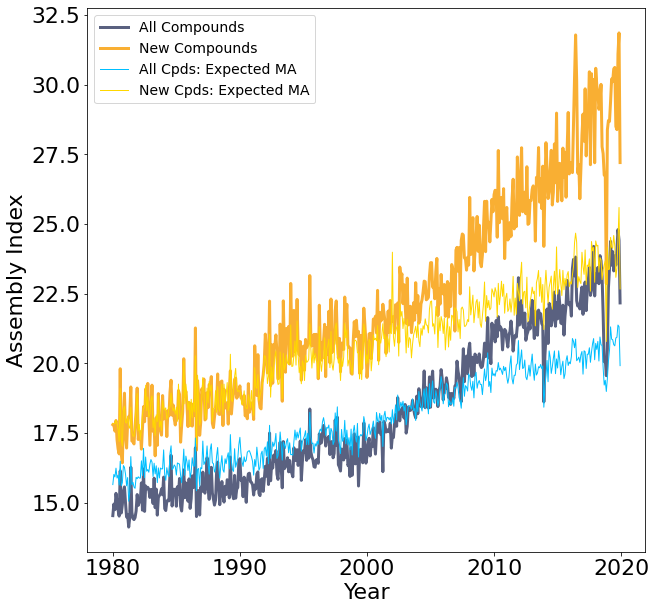

In [34]:
#Assembly values with standard deviation
plt.figure(figsize=(10,10))

xs = np.arange(1980, 2020, 1/12)

#Average assembly Values
plt.plot(xs, full_stats["ai"]["mean"], color="#313a61",
            linewidth=3, markersize=10, alpha=0.8, label="All Compounds")

plt.plot(xs, new_stats["ai"]["mean"], color="#f89b00",
            linewidth=3, markersize=10, alpha=0.8, label="New Compounds")

#Expected MA values
plt.plot(xs, full_stats["ExpectedMA"], color="deepskyblue", linewidth=1, label="All Cpds: Expected MA")
plt.plot(xs, new_stats["ExpectedMA"], color="gold", linewidth=1, label="New Cpds: Expected MA")

plt.legend(prop={"size":14})
plt.xlabel("Year")
plt.ylabel("Assembly Index")

# Stats on assembly distributions

Perform statistics to test:

- Normality of distributions
- Significance of difference between new & full MA distributions

In [18]:
#Get lists of all MA values for each month
full_MA = full_df.groupby("month").agg({"ai":list})
new_MA = new_df.groupby("month").agg({"ai":list})

print(new_MA)

                                                        ai
month                                                     
1980-01  [10, 14, 18, 7, 8, 9, 17, 5, 8, 7, 13, 12, 11,...
1980-02  [9, 9, 7, 30, 5, 14, 6, 9, 8, 22, 8, 21, 10, 2...
1980-03  [19, 10, 23, 12, 11, 14, 6, 8, 10, 15, 15, 19,...
1980-04  [34, 35, 24, 22, 17, 6, 9, 9, 11, 13, 12, 6, 5...
1980-05  [8, 18, 5, 6, 31, 7, 8, 12, 9, 21, 17, 18, 13,...
...                                                    ...
2019-08  [42, 61, 76, 21, 17, 30, 26, 17, 18, 24, 27, 2...
2019-09  [22, 34, 29, 29, 32, 33, 21, 18, 27, 29, 20, 1...
2019-10  [14, 14, 13, 24, 19, 21, 16, 26, 22, 23, 11, 6...
2019-11  [15, 34, 73, 28, 56, 61, 28, 28, 29, 14, 29, 2...
2019-12  [7, 28, 49, 28, 16, 15, 21, 15, 14, 12, 13, 31...

[480 rows x 1 columns]


## Test for Normality

Test each distribution for normal distribution

Text(0.5, 1.0, 'New Cpds, 1980-01')

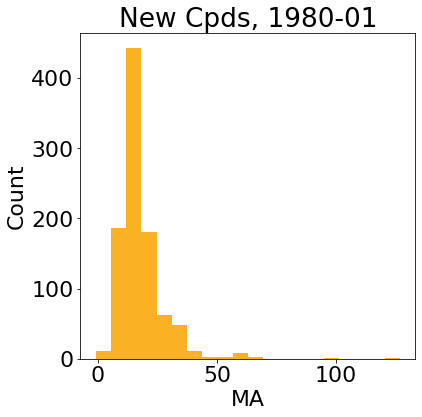

In [38]:
#Plot 1980 & 2019 for both datasets
plt.figure(figsize=(6,6))

plt.hist(new_MA.loc["1980-01"]["ai"], bins=20, color=colors["new"])

plt.xlabel("MA")
plt.ylabel("Count")
plt.title("New Cpds, 1980-01")

In [ ]:
for month, row in new_MA.iterrows():
    print(month)

    print(stats.shapiro(row["ai"]))
    print()


## Test difference between distributions

Is there a significant difference between full and new MA distributions within each month?

In [42]:
#Mann-Whitney U rank test (non-parametric)
months = build_month_increments(1980, 2019)

for month in months[0:12]:
    print(stats.mannwhitneyu(full_MA.loc[month]["ai"], new_MA.loc[month]["ai"]))

MannwhitneyuResult(statistic=341046.5, pvalue=4.511971652068771e-25)
MannwhitneyuResult(statistic=346974.5, pvalue=1.4222405157820336e-21)
MannwhitneyuResult(statistic=356178.5, pvalue=5.402311037826035e-21)
MannwhitneyuResult(statistic=348704.0, pvalue=6.434678202030446e-20)
MannwhitneyuResult(statistic=377746.5, pvalue=3.719511629092984e-12)
MannwhitneyuResult(statistic=376241.0, pvalue=5.628169663383528e-17)
MannwhitneyuResult(statistic=353232.0, pvalue=4.19446663391659e-19)
MannwhitneyuResult(statistic=359116.0, pvalue=8.40243821615334e-21)
MannwhitneyuResult(statistic=362088.5, pvalue=4.6886455470052366e-17)
MannwhitneyuResult(statistic=361537.5, pvalue=2.1541743396872751e-16)
MannwhitneyuResult(statistic=367975.5, pvalue=2.295500637851385e-17)
MannwhitneyuResult(statistic=385028.5, pvalue=1.7137172972616657e-14)


In [ ]:
#z-test (assumes normality, but from https://www.researchgate.net/post/Hello-could-you-please-share-with-me-the-formula-of-Mann-Whitney-U-Test-critical-values-for-large-samples-n100, at large values of n, parametric tests can be used)
months = build_month_increments(1980, 2019)

for month in months:
    #Null hypothesis - no difference between the distributions (therefore, if p-value is <0.5, then the distributions are different)
    zstat, pval = ztest(full_MA.loc[month]["ai"], new_MA.loc[month]["ai"], value=0) 
    if pval > 0.05:
        print(month, "is not significantly different")
    else:
        print(month + "," +str(zstat) + "," + str(pval))

### Wasserstein Distancxe

Find monthly & average wasserstein distance between each distribution

In [61]:
months = build_month_increments(1980, 2019)
w_dist = []

for month in months:
    w_dist.append(stats.wasserstein_distance(full_MA.loc[month]["ai"], new_MA.loc[month]["ai"]))

print("Average Wasserstein distance:", np.mean(w_dist))

Average Wasserstein distance: 4.115881048100523


Text(0, 0.5, 'Wasserstein Distance')

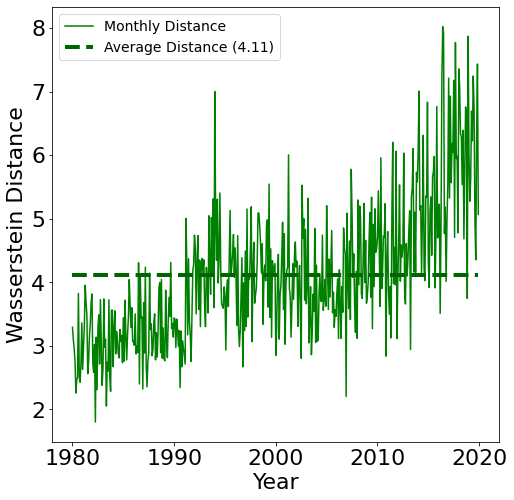

In [75]:
plt.figure(figsize=(8,8))

xs = np.arange(1980, 2020, 1/12)

plt.plot(xs, w_dist, color="green", label="Monthly Distance")
plt.plot(xs, [np.mean(w_dist)]*len(xs), color="darkgreen", linestyle="--", linewidth=4, label="Average Distance (4.11)")

plt.legend(prop={"size":14})
plt.xlabel("Year")
plt.ylabel("Wasserstein Distance")

# Changing Compounds Assemblies

Analyze the assembly values of fast-changing (min & max percentiles) compounds

Sets to analyze:
1. Compounds in 99.99th percentile
2. Changing compounds, 99.99th percentile (maxPercentile_0.01_99.99*)
3. Changing compounds, below 0.01st percentile (minPercentile_0.01_99.99*)
4. Changing compounds, 99.9th percentile (maxPercentile_0.1_99.9*)
5. Changing compounds, below 0.1st percentile (minPercentile_0.1_99.9*) 

In [4]:
## Matplotlib defaults ##
colors = {"1980": "#aa0f35", 
         "1985": "#fdc799",
         "1990": "#abdbfc",
         "1995": "#a0a75c",
         "2000": "#603734",
         "2005": "#009ecb",
         "2010": "#430057",
         "2015": "#f89b00"}

font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 22}

plt.rcParams.update({'font.size': 22})

### Compounds in 99.99th percentile 

Plot & analyze the most connected compounds in SureChemBL

------  (2015, 2019) -----
DescribeResult(nobs=722, minmax=(1, 119), mean=15.637119113573407, variance=256.75579085680477, skewness=3.308937717875287, kurtosis=12.829833350312803)
------  (2010, 2014) -----
DescribeResult(nobs=695, minmax=(1, 119), mean=15.751079136690647, variance=284.97973586548625, skewness=3.264398959689537, kurtosis=11.761944878282671)
------  (2005, 2009) -----
DescribeResult(nobs=540, minmax=(1, 119), mean=17.15, variance=354.5655844155844, skewness=2.748878893799469, kurtosis=7.721047532280789)
------  (2000, 2004) -----
DescribeResult(nobs=265, minmax=(1, 100), mean=16.60377358490566, variance=346.93710691823895, skewness=2.4396828094647396, kurtosis=5.448874109651744)
------  (1995, 1999) -----
DescribeResult(nobs=163, minmax=(2, 87), mean=15.50920245398773, variance=322.7082481254261, skewness=2.2988947899026977, kurtosis=4.296780402120956)
------  (1990, 1994) -----
DescribeResult(nobs=126, minmax=(3, 87), mean=16.73015873015873, variance=393.7986031746031,

Text(0, 0.5, 'Compound Density')

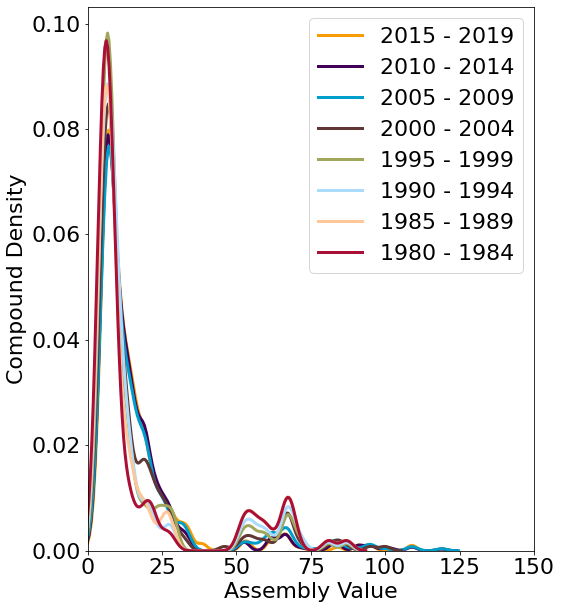

In [48]:
pairs = [(1980, 1984), (1985,1989), (1990,1994), (1995,1999), (2000,2004), (2005,2009), (2010,2014), (2015,2019)]

full_ais = []

plt.figure(figsize=(8,10))

for pair in reversed(pairs):
    print("------ ", pair, "-----")
    start = pair[0]
    stop = pair[1]
    ids = pickle.load(file=open("Data/Cpd_Data/ids_above99_99percentile" + str(start) + "_" + 
                                str(stop) + "cpdData_assembly.p", "rb"))
    
    ais = []
    for cpd in ids:
        ais.append(cpd["ai"])
        
    #Remove -1s
    ais = [x for x in ais if x != -1]
    full_ais.append(ais)

    print(stats.describe(ais))
    
    #plt.hist(ais, bins=100, color=colors[str(start)], label= str(start) + " - " + str(stop))
    sns.kdeplot(ais, bw_method=0.1, color=colors[str(start)], label= str(start) + " - " + str(stop), linewidth=3)

plt.legend()
plt.xlim(0,150)
plt.xlabel("Assembly Value")
plt.ylabel("Compound Density")

In [54]:
combos = itertools.combinations(range(0,len(full_ais)), 2)
for combo in combos:
    print(combo)
    print(stats.ks_2samp(full_ais[combo[0]], full_ais[combo[1]]))
    print(stats.anderson_ksamp([full_ais[combo[0]], full_ais[combo[1]]]))
    print("Wasserstein Distance:", stats.wasserstein_distance(full_ais[combo[0]], full_ais[combo[1]]))
    print()

(0, 1)
KstestResult(statistic=0.011891428685306602, pvalue=0.9999999977077801)
Anderson_ksampResult(statistic=-1.0699860338119844, critical_values=array([0.325, 1.226, 1.961, 2.718, 3.752, 4.592, 6.546]), significance_level=0.25)
Wasserstein Distance: 0.5383247972259305

(0, 2)
KstestResult(statistic=0.03345644813788858, pvalue=0.864307761582229)
Anderson_ksampResult(statistic=-0.7580090187166283, critical_values=array([0.325, 1.226, 1.961, 2.718, 3.752, 4.592, 6.546]), significance_level=0.25)
Wasserstein Distance: 1.5986713860675081

(0, 3)
KstestResult(statistic=0.07503789264621336, pvalue=0.21189782394499013)
Anderson_ksampResult(statistic=2.095567746527271, critical_values=array([0.325, 1.226, 1.961, 2.718, 3.752, 4.592, 6.546]), significance_level=0.044571432106303426)
Wasserstein Distance: 2.4402341504207357

(0, 4)
KstestResult(statistic=0.15266896657206463, pvalue=0.00355205398259939)
Anderson_ksampResult(statistic=7.680779381202069, critical_values=array([0.325, 1.226, 1.961,

c:\users\group\anaconda3\envs\my-rdkit-env\lib\site-packages\ipykernel_launcher.py:5: UserWarning: p-value capped: true value larger than 0.25
  """
c:\users\group\anaconda3\envs\my-rdkit-env\lib\site-packages\ipykernel_launcher.py:5: UserWarning: p-value floored: true value smaller than 0.001
  """


Anderson_ksampResult(statistic=9.969150247135532, critical_values=array([0.325, 1.226, 1.961, 2.718, 3.752, 4.592, 6.546]), significance_level=0.001)
Wasserstein Distance: 4.8081519663993895

(3, 4)
KstestResult(statistic=0.07952309295057298, pvalue=0.5130898912449378)
Anderson_ksampResult(statistic=0.4417356012385059, critical_values=array([0.325, 1.226, 1.961, 2.718, 3.752, 4.592, 6.546]), significance_level=0.21880182947808205)
Wasserstein Distance: 1.445630281282555

(3, 5)
KstestResult(statistic=0.0746031746031746, pvalue=0.6925072704114961)
Anderson_ksampResult(statistic=0.08146284297910673, critical_values=array([0.325, 1.226, 1.961, 2.718, 3.752, 4.592, 6.546]), significance_level=0.25)
Wasserstein Distance: 2.2620545073375258

(3, 6)
KstestResult(statistic=0.10302672955974843, pvalue=0.4094223190343369)
Anderson_ksampResult(statistic=0.4713304271827982, critical_values=array([0.325, 1.226, 1.961, 2.718, 3.752, 4.592, 6.546]), significance_level=0.21247405604335284)
Wasserstein

### Changing compounds, 99.9th percentile 

------  (2015, 2019) -----
DescribeResult(nobs=255, minmax=(2, 72), mean=10.011764705882353, variance=70.38962482630848, skewness=3.9867883140560094, kurtosis=20.504278861694107)

------  (2010, 2014) -----
DescribeResult(nobs=192, minmax=(2, 72), mean=9.916666666666666, variance=75.68935427574172, skewness=4.255366022937834, kurtosis=22.321515447802124)

------  (2005, 2009) -----
DescribeResult(nobs=44, minmax=(3, 59), mean=11.272727272727273, variance=159.69133192389006, skewness=2.8373976748006977, kurtosis=7.087474216438332)

------  (2000, 2004) -----
DescribeResult(nobs=11, minmax=(5, 28), mean=10.272727272727273, variance=41.41818181818182, skewness=2.0420616823932276, kurtosis=3.4622930639371434)

------  (1995, 1999) -----
DescribeResult(nobs=143, minmax=(2, 72), mean=10.23076923076923, variance=94.27735644637053, skewness=4.001581217375285, kurtosis=18.41325504799777)

------  (1990, 1994) -----
DescribeResult(nobs=193, minmax=(2, 72), mean=9.963730569948186, variance=76.587

Text(0, 0.5, 'Compound Density')

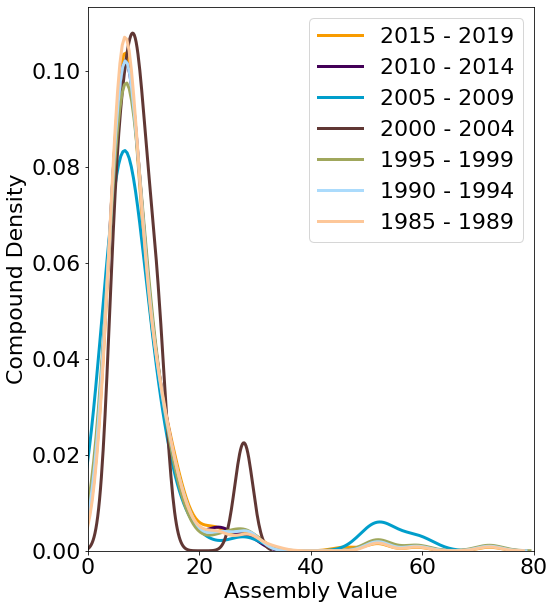

In [49]:
pairs = [(1985,1989), (1990,1994), (1995,1999), (2000,2004), (2005,2009), (2010,2014), (2015,2019)]

full_ais = []

plt.figure(figsize=(8,10))

for pair in reversed(pairs):
    print("------ ", pair, "-----")
    start = pair[0]
    stop = pair[1]
    ids = pickle.load(file=open("Data/Cpd_Data/ids_change_maxPercentile_0.1_99.9_" + str(start-1) + "_" + 
                                str(stop) + "cpdData_assembly.p", "rb"))
    
    ais = []
    for cpd in ids:
        ais.append(cpd["ai"])
        
    #Remove -1s
    ais = [x for x in ais if x != -1]
    full_ais.append(ais)

    print(stats.describe(ais))
    print()
    
    #plt.hist(ais, bins=100, color=colors[str(start)], alpha=0.8, label= str(start-1) + " - " + str(stop))
    sns.kdeplot(ais, bw_method=0.25, color=colors[str(start)], label= str(start) + " - " + str(stop), linewidth=3)
    

plt.legend()
plt.xlim(0,80)
plt.xlabel("Assembly Value")
plt.ylabel("Compound Density")

In [56]:
combos = itertools.combinations(range(0,len(full_ais)), 2)
for combo in combos:
    print(combo)
    print(stats.ks_2samp(full_ais[combo[0]], full_ais[combo[1]]))
    print(stats.anderson_ksamp([full_ais[combo[0]], full_ais[combo[1]]]))
    print("Wasserstein Distance:", stats.wasserstein_distance(full_ais[combo[0]], full_ais[combo[1]]))
    print()

(0, 1)
KstestResult(statistic=0.01997549019607843, pvalue=0.9999999995237022)
Anderson_ksampResult(statistic=-1.2325645468887758, critical_values=array([0.325, 1.226, 1.961, 2.718, 3.752, 4.592, 6.546]), significance_level=0.25)
Wasserstein Distance: 0.2848039215686279

(0, 2)
KstestResult(statistic=0.08360071301247772, pvalue=0.9325351708624212)
Anderson_ksampResult(statistic=-0.49182366723549, critical_values=array([0.325, 1.226, 1.961, 2.718, 3.752, 4.592, 6.546]), significance_level=0.25)
Wasserstein Distance: 2.154545454545455

(0, 3)
KstestResult(statistic=0.22923351158645278, pvalue=0.5602536950607762)
Anderson_ksampResult(statistic=-0.7006021084284263, critical_values=array([0.325, 1.226, 1.961, 2.718, 3.752, 4.592, 6.546]), significance_level=0.25)
Wasserstein Distance: 1.7283422459893059

(0, 4)
KstestResult(statistic=0.02243246949129302, pvalue=0.9999999981044085)
Anderson_ksampResult(statistic=-1.2121593830680966, critical_values=array([0.325, 1.226, 1.961, 2.718, 3.752, 4.

c:\users\group\anaconda3\envs\my-rdkit-env\lib\site-packages\ipykernel_launcher.py:5: UserWarning: p-value capped: true value larger than 0.25
  """


### Changing compounds, below 0.1st percentile 


------  (2015, 2019) -----
DescribeResult(nobs=14, minmax=(5, 23), mean=9.214285714285714, variance=19.719780219780223, skewness=2.2753652312810235, kurtosis=4.823006522592599)

------  (2010, 2014) -----
DescribeResult(nobs=33, minmax=(5, 23), mean=8.181818181818182, variance=11.090909090909088, skewness=2.7821910406362513, kurtosis=9.941764226686384)

------  (2005, 2009) -----
DescribeResult(nobs=151, minmax=(3, 53), mean=9.655629139072847, variance=36.84061810154526, skewness=3.627597139606427, kurtosis=18.859142589807984)

------  (2000, 2004) -----
DescribeResult(nobs=389, minmax=(3, 81), mean=10.352185089974293, variance=39.69265629555031, skewness=4.987640846788539, kurtosis=45.03610802378697)

------  (1995, 1999) -----
DescribeResult(nobs=216, minmax=(3, 53), mean=9.787037037037036, variance=32.43815676141257, skewness=3.3281999121769847, kurtosis=17.82198377577295)

------  (1990, 1994) -----
DescribeResult(nobs=434, minmax=(2, 81), mean=10.264976958525345, variance=42.84186

Text(0, 0.5, 'Compound Density')

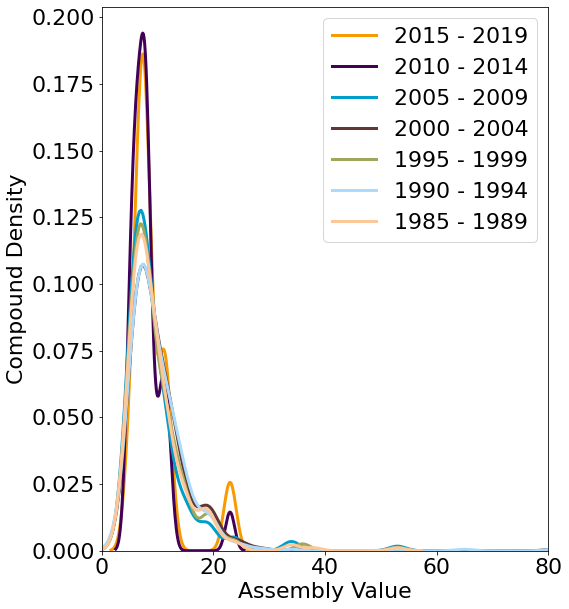

In [50]:
pairs = [(1985,1989), (1990,1994), (1995,1999), (2000,2004), (2005,2009), (2010,2014), (2015,2019)]

full_ais = []

plt.figure(figsize=(8,10))

for pair in reversed(pairs):
    print("------ ", pair, "-----")
    start = pair[0]
    stop = pair[1]
    ids = pickle.load(file=open("Data/Cpd_Data/ids_change_minPercentile_0.1_99.9_" + str(start-1) + "_" + 
                                str(stop) + "cpdData_assembly.p", "rb"))
    
    ais = []
    for cpd in ids:
        ais.append(cpd["ai"])
        
    #Remove -1s
    ais = [x for x in ais if x != -1]
    full_ais.append(ais)

    print(stats.describe(ais))
    print()
    
    #plt.hist(ais, bins=100, color=colors[str(start)], alpha=0.8, label= str(start-1) + " - " + str(stop))
    sns.kdeplot(ais, bw_method=0.25, color=colors[str(start)], label= str(start) + " - " + str(stop), linewidth=3)
    

plt.legend()
plt.xlim(0,80)
plt.xlabel("Assembly Value")
plt.ylabel("Compound Density")

In [58]:
combos = itertools.combinations(range(0,len(full_ais)), 2)
for combo in combos:
    print(combo)
    print(stats.ks_2samp(full_ais[combo[0]], full_ais[combo[1]]))
    print(stats.anderson_ksamp([full_ais[combo[0]], full_ais[combo[1]]]))
    print("Wasserstein Distance:", stats.wasserstein_distance(full_ais[combo[0]], full_ais[combo[1]]))
    print()

(0, 1)
KstestResult(statistic=0.16017316017316016, pvalue=0.9137835326059303)
Anderson_ksampResult(statistic=-0.6886537335030235, critical_values=array([0.325, 1.226, 1.961, 2.718, 3.752, 4.592, 6.546]), significance_level=0.25)
Wasserstein Distance: 1.0324675324675323

(0, 2)
KstestResult(statistic=0.16177861873226113, pvalue=0.8342558375814302)
Anderson_ksampResult(statistic=-0.8290556286861674, critical_values=array([0.325, 1.226, 1.961, 2.718, 3.752, 4.592, 6.546]), significance_level=0.25)
Wasserstein Distance: 1.1556291390728484

(0, 3)
KstestResult(statistic=0.15956665442526624, pvalue=0.8283453243806849)
Anderson_ksampResult(statistic=-0.33110729841668524, critical_values=array([0.325, 1.226, 1.961, 2.718, 3.752, 4.592, 6.546]), significance_level=0.25)
Wasserstein Distance: 1.6972089607051064

(0, 4)
KstestResult(statistic=0.14417989417989419, pvalue=0.9095928141227335)
Anderson_ksampResult(statistic=-0.7078635438065096, critical_values=array([0.325, 1.226, 1.961, 2.718, 3.752

c:\users\group\anaconda3\envs\my-rdkit-env\lib\site-packages\ipykernel_launcher.py:5: UserWarning: p-value capped: true value larger than 0.25
  """


## Assembly / Degree Correlation

In [10]:
#Read in assembly data into a dictionary, {ID:MA_value}
MA_df = pd.read_csv("Data/AssemblyValues/assigneeCpds_AssemblyGo.csv")
cpd_MA_links = dict(zip(MA_df["label"], MA_df["MA_assemblyGo"]))
print(list(cpd_MA_links.items())[0:5])

print(cpd_MA_links["SCHEMBL10000057"])

# TODO: add author cpds

[('SCHEMBL10000057', 10.0), ('SCHEMBL10000065', 8.0), ('SCHEMBL10000069', 12.0), ('SCHEMBL1000007', 19.0), ('SCHEMBL10000081', 16.0)]
10.0


In [7]:
#TODO: get full coverage of degrees (this is just testing right now)

#Read in degree data (I think...)
degree_df = pd.read_csv("Data/AssemblyDegreeCorr/sample_byDegreeQuantile_2019-12.csv")
degree_df = degree_df.rename({"Unnamed: 0": "SureChEMBL_ID"}, axis=1)
print(degree_df)

        SureChEMBL_ID  Degree  quantile
0       SCHEMBL121895       4         0
1       SCHEMBL249368      17         0
2     SCHEMBL14695391       9         0
3      SCHEMBL1418691      19         0
4      SCHEMBL4394698      11         0
...               ...     ...       ...
9370     SCHEMBL83796   17996        49
9371     SCHEMBL37162   18007        49
9372     SCHEMBL25918   18603        49
9373     SCHEMBL27798   21644        49
9374     SCHEMBL26078   16948        49

[9375 rows x 3 columns]


In [33]:
### TESTING - to find best cpd:ID relation ###

""" Full ID degrees - dict of all degrees for a compound for each month in a given timeframe
    {ID:[degree per month]}
"""
## full_id_degrees = pickle.load(file=open("/Volumes/Macintosh HD 4/SureChemBL/Degrees/full_id_degrees_1980_1984.p", "rb"))

""" List of degree values (no ID associated here)
"""
## cpd_degrees = pickle.load(file=open("/Volumes/Macintosh HD 4/SureChemBL/Degrees/Months/CpdDegrees/cpd_degrees_1980-01.p", "rb"))

""" Dictionary of all ID:degree pairs within a given month, doesn't include ids which don't appear in that month
    {ID: degree}
"""
## id_degrees = pickle.load(file=open("/Volumes/Macintosh HD 4/SureChemBL/Degrees/Months/IDDegrees/id_degrees_1980-01.p", "rb"))

In [36]:
### ID/Degree relation: use 2015-2019 full ID list to find final degree value
full_id_degrees = pickle.load(file=open("/Volumes/Macintosh HD 4/SureChemBL/Degrees/full_id_degrees_2015_2019.p", "rb"))

print(list(full_id_degrees.items())[0:5])

[('SCHEMBL8038039', [418, 418, 418, 418, 418, 418, 418, 418, 418, 418, 418, 418, 418, 418, 418, 418, 418, 418, 418, 418, 418, 418, 418, 418, 418, 418, 418, 418, 418, 418, 418, 418, 418, 418, 418, 418, 418, 418, 418, 418, 418, 418, 418, 418, 418, 418, 418, 418, 418, 418, 418, 418, 418, 418, 418, 418, 418, 418, 418, 418]), ('SCHEMBL656810', [1877, 1877, 1877, 3744, 7513, 9389, 9389, 9389, 13151, 15023, 16895, 16895, 20644, 20644, 20644, 20644, 22525, 22525, 22525, 24406, 24406, 24406, 26278, 26278, 28153, 28153, 31932, 31932, 31932, 33832, 33832, 35734, 35734, 35734, 35734, 35734, 35734, 35734, 37630, 37630, 37630, 37630, 37630, 37630, 37630, 37630, 37630, 37630, 37630, 37630, 37630, 37630, 37630, 39493, 39493, 43224, 43224, 43224, 43224, 43224]), ('SCHEMBL16387018', [103, 201, 201, 201, 201, 201, 201, 201, 201, 201, 201, 201, 201, 201, 201, 201, 201, 201, 201, 201, 201, 201, 201, 201, 201, 201, 201, 201, 201, 201, 201, 201, 201, 201, 201, 201, 201, 201, 201, 201, 201, 201, 201, 201, 201

In [37]:
def get_degree(ID, full_id_degrees):
    if ID in full_id_degrees:
        return full_id_degrees[ID][-1]
    else:
        return -1

In [40]:
#Testing - shold be 43224 
get_degree("SCHEMBL656810", full_id_degrees)

43224

In [8]:
def get_MA(ID, cpd_MA_links):
    if ID in cpd_MA_links:
        return cpd_MA_links[ID]
    else:
        return -1

In [41]:
print(MA_df)

        Unnamed: 0            label  MA_assemblyGo        time
0                0  SCHEMBL10000057           10.0    4.039986
1                1  SCHEMBL10000065            8.0    0.524358
2                2  SCHEMBL10000069           12.0    1.133103
3                3   SCHEMBL1000007           19.0  120.066312
4                4  SCHEMBL10000081           16.0  120.249062
...            ...              ...            ...         ...
332241      332241   SCHEMBL9999740           18.0  120.064376
332242      332242    SCHEMBL999979           20.0  121.223274
332243      332243   SCHEMBL9999803           29.0  119.850716
332244      332244   SCHEMBL9999899           11.0   46.285976
332245      332245   SCHEMBL9999952           13.0  119.925215

[332246 rows x 4 columns]


In [42]:
#Add degree values to MA dataframe
tqdm.pandas()

MA_df["degree"] = MA_df["label"].progress_apply(get_degree, args=(full_id_degrees,))

100%|██████████| 332246/332246 [00:06<00:00, 48334.47it/s] 


In [43]:
#Filter out all -1 MAs (indicates these MAs were not sampled)

MA_df_filtered = MA_df[MA_df["degree"] > 0]

In [44]:
#Correlation between mc_ai, frag_ai, and Degree
MA_df_filtered.corr()

Unnamed: 0  MA_assemblyGo      time    degree
Unnamed: 0       1.000000      -0.108742 -0.122482  0.037941
MA_assemblyGo   -0.108742       1.000000  0.706156 -0.042797
time            -0.122482       0.706156  1.000000 -0.052819
degree           0.037941      -0.042797 -0.052819  1.000000

In [45]:
print(MA_df_filtered)

        Unnamed: 0            label  MA_assemblyGo        time  degree
0                0  SCHEMBL10000057           10.0    4.039986     593
1                1  SCHEMBL10000065            8.0    0.524358     593
2                2  SCHEMBL10000069           12.0    1.133103     593
3                3   SCHEMBL1000007           19.0  120.066312     117
6                6  SCHEMBL10000085            8.0    0.854777     593
...            ...              ...            ...         ...     ...
332240      332240   SCHEMBL9999693           14.0   17.637188     162
332241      332241   SCHEMBL9999740           18.0  120.064376   10657
332242      332242    SCHEMBL999979           20.0  121.223274     959
332244      332244   SCHEMBL9999899           11.0   46.285976    5023
332245      332245   SCHEMBL9999952           13.0  119.925215   20402

[141578 rows x 5 columns]


Text(0, 0.5, 'MA')

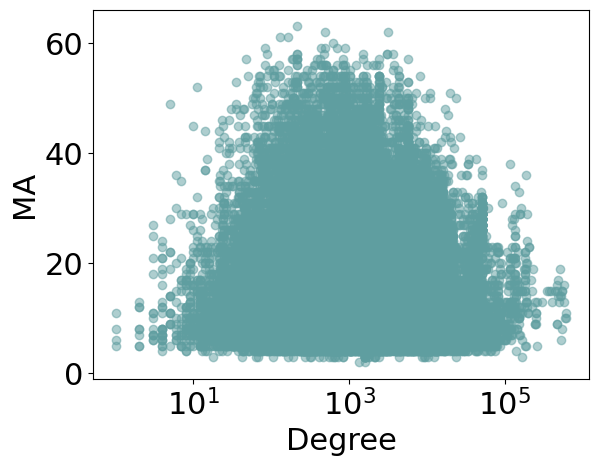

In [47]:
#Visual representation of 0 correlation (lol)
plt.Figure(figsize=(10,10))
plt.scatter(MA_df_filtered["degree"], MA_df_filtered["MA_assemblyGo"], color="cadetblue", alpha=0.5)


plt.xscale("log")

plt.xlabel("Degree")
plt.ylabel("MA")

## Fragment analysis

Do the number / diversity of fragments within the assembly code increase as time goes on? Could this explain MA increase?

In [9]:
### TESTING - need to see if two igraph graphs (C-C=C and C=C-C) are isomorphic

g1 = ig.Graph(3)
g2 = ig.Graph(3)

In [10]:
g1.add_edges([(0,1), (1, 2)])
g2.add_edges([(0,1), (1, 2)])

print(g1)
print("------")
print(g2)

IGRAPH U--- 3 2 --
+ edges:
0--1 1--2
------
IGRAPH U--- 3 2 --
+ edges:
0--1 1--2


In [11]:
#Add edge & vertex colors
g1.vs["color"] = ["C", "C", "C"]
g1.es["color"] = ["single", "double"]

g2.vs["color"] = ["C", "C", "C"]
g2.es["color"] = ["double", "single"]

In [21]:
#Check regular isomorphic (should be true)
print("G1 - iso - G2:", g1.isomorphic(g2))

#Check including colors (should also be true)
print("G1 - iso with colors - G2:", g1.isomorphic_vf2(g2, color1=[4, 4, 4], color2=[4, 4, 4], edge_color1=[-1, -2], edge_color2=[-2, -1]))


G1 - iso - G2: True
G1 - iso with colors - G2: True


In [25]:
from random import randint

In [29]:
#Speed test
graphs = [g1] * 1000000

iso = []
for g in tqdm(graphs):
    iso.append(g.isomorphic_vf2(g2, color1=[randint(0,10), 4, 4], color2=[4, 4, 4], edge_color1=[randint(0,10), -2], edge_color2=[-2, -1]))

100%|██████████| 1000000/1000000 [00:04<00:00, 241006.41it/s]


In [28]:
print(iso[0:100])

[False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False]
